In [32]:
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
#import warnings
#warnings.filterwarnings("ignore")

from nupack import *
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.SeqUtils import GC, molecular_weight

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, \
                             AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import sklearn.gaussian_process as gp
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [1]:











from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, KFold, RandomizedSearchCV

from sklearn.pipeline import Pipeline


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import r2_score, mean_squared_error

In [1]:
CONFIG = {
    'path': 'datasets/rna-logic-gates',
    'remove_control': True,
    'remove_shared_sequence': True,
    'logscale': True,
    'use_median': True, #otherwise use mean
    'model_nostacking': True
}

In [2]:
def get_kmers(sequence, size=3):
    return [sequence[x:x+size].upper() for x in range(len(sequence)-size+1)]

def generate_seq_features(data, kmers):
    
    feats = pd.DataFrame()
    labels = []
    for k in kmers:
        words5 = data['rna5'].apply(lambda x: get_kmers(str(x), k))
        words3 = data['rna3'].apply(lambda x: get_kmers(str(x), k))
        texts = list(words5 + words3)
        for i in range(len(texts)):
            texts[i] = ' '.join(texts[i])

        cv = CountVectorizer()
        cv.fit(texts)
        seq_feats = pd.DataFrame(cv.transform(texts).toarray())
        feats = pd.concat([feats, seq_feats], axis=1)
        feats.columns = np.arange(feats.shape[1])
        labels.extend(cv.get_feature_names_out())
    
    return feats, labels

In [3]:
def preprocess_data(raw_data, config=CONFIG):
    
    data = raw_data.copy()
    if config['remove_shared_sequence']:
        data['rna5'] = data['rna5'].apply(lambda x: x.replace('T', 'U')[577:-49]) #hardcoded position for the non-shared region of 5-egs
        data['rna3'] = data['rna3'].apply(lambda x: x.replace('T', 'U')[68:-732]) #hardcoded position for the non-shared region of 3-egs
    data['rna5_rna3'] = data['rna5'] + data['rna3']
    if config['use_median']:
        data['fluo'] = data[['fluo1', 'fluo2', 'fluo3']].median(axis=1)
    else:
        data['fluo'] = data[['fluo1', 'fluo2', 'fluo3']].mean(axis=1)
    if config['logscale']:
        data['fluo'] = np.log10(data['fluo'])
    data['len5'] = data['rna5'].apply(lambda x: len(x))
    data['len3'] = data['rna3'].apply(lambda x: len(x))
    if config['remove_control']:
        data = data[data['len5']>0].reset_index(drop=True) #remove control because controls do not have non-shared 5-egs
    
    return data.drop(['fluo1', 'fluo2', 'fluo3'], axis=1)

In [8]:
raw_data = pd.read_csv('{}/egs.csv'.format(CONFIG['path']))
data = preprocess_data(raw_data)
data.shape

(1296, 6)

In [9]:
def generate_thermo_features(data, config=CONFIG, encode_non_numeric=True):
    
    models = [Model(material='RNA', ensemble='stacking')]
    if config['model_nostacking']:
        models.append(Model(material='RNA', ensemble='nostacking'))
        
    for i, model in tqdm(enumerate(models)):
        arr = [pfunc(strands=[str1, str2], model=model) \
               for str1, str2 in zip(data['rna5'].tolist(), data['rna3'].tolist())]
        data['pfunc-0_{}'.format(i)] = [x[0] for x in arr]
        data['pfunc-1_{}'.format(i)] = [x[1] for x in arr]
        
        data['pfunc-0_{}'.format(i)] = data['pfunc-0_{}'.format(i)].astype(float)
        
    for i, model in tqdm(enumerate(models)):
        arr = [pairs(strands=[str1, str2], model=model) \
               for str1, str2 in zip(data['rna5'].tolist(), data['rna3'].tolist())]
        data['prob_matrix_{}'.format(i)] = [x.to_array().ravel() for x in arr]
 
    for i, model in tqdm(enumerate(models)):
        arr = [mfe(strands=[str1, str2], model=model) \
               for str1, str2 in zip(data['rna5'].tolist(), data['rna3'].tolist())]
        data['mfe_energy_{}'.format(i)] = [x[0].energy for x in arr]
        data['mfe_stack_energy_{}'.format(i)] = [x[0].stack_energy for x in arr]
        data['mfe_structure_{}'.format(i)] = [str(x[0].structure) for x in arr]
        data['mfe_matrix_{}'.format(i)] = [x[0].structure.matrix().ravel() for x in arr]
        data['mfe_pairlist_{}'.format(i)] = [x[0].structure.pairlist() for x in arr]
        data['mfe_nicks_{}'.format(i)] = [x[0].structure.nicks() for x in arr]
        
    for i, model in tqdm(enumerate(models)):
        arr = [structure_energy(strands=[str1, str2], structure=structure, model=model) \
               for str1, str2, structure in zip(data['rna5'].tolist(), data['rna3'].tolist(), \
               data['mfe_structure_{}'.format(i)])]
        data['struct_dg_{}'.format(i)] = arr
    
    for i, model in tqdm(enumerate(models)):
        arr = [structure_probability(strands=[str1, str2], structure=structure, model=model) \
               for str1, str2, structure in zip(data['rna5'].tolist(), data['rna3'].tolist(), \
               data['mfe_structure_{}'.format(i)])]
        data['struct_proba_{}'.format(i)] = arr

    for i, model in tqdm(enumerate(models)):
        arr = [subopt(strands=[str1, str2], energy_gap=1.5, model=model) \
               for str1, str2 in zip(data['rna5'].tolist(), data['rna3'].tolist())]
        data['subopt_energy_{}'.format(i)] = [x[0].energy for x in arr]
        data['subopt_stack_energy_{}'.format(i)] = [x[0].stack_energy for x in arr]
        
    for i, model in tqdm(enumerate(models)):
        arr = [ensemble_size(strands=[str1, str2], model=model) \
               for str1, str2 in zip(data['rna5'].tolist(), data['rna3'].tolist())]
        data['ensemble_{}'.format(i)] = arr
    
    try:
        for i, model in tqdm(enumerate(models)):
            arr = [defect(strands=[str1, str2], structure=structure, model=model) \
                   for str1, str2, structure in zip(data['rna5'].tolist(), data['rna3'].tolist(), \
                   data['mfe_structure_{}'.format(i)])]
            data['defect_{}'.format(i)] = arr
    except:
        print('***DEFECT does not work***')

    data['distance'] = [seq_distance(str1, str2)
                        for str1, str2 in zip(data['rna5'].tolist(), data['rna3'].tolist())]
    data['global_alg'] = [pairwise2.align.globalxx(str1, str2, score_only=True)
                          for str1, str2 in zip(data['rna5'].tolist(), data['rna3'].tolist())]
    data['local_alg'] = [pairwise2.align.localxx(str1, str2, score_only=True)
                         for str1, str2 in zip(data['rna5'].tolist(), data['rna3'].tolist())]

    data['gc5'] = [GC(x) for x in data['rna5']]
    data['gc3'] = [GC(x) for x in data['rna3']]
    data['weight5'] = [molecular_weight(x, 'RNA') for x in data['rna5']]
    data['weight3'] = [molecular_weight(x, 'RNA') for x in data['rna3']]
    data['C5'] = [Seq(x).count('C') for x in data['rna5']]
    data['C3'] = [Seq(x).count('C') for x in data['rna3']]
    data['G5'] = [Seq(x).count('G') for x in data['rna5']]
    data['G3'] = [Seq(x).count('G') for x in data['rna3']]
    data['U5'] = [Seq(x).count('U') for x in data['rna5']]
    data['U3'] = [Seq(x).count('U') for x in data['rna3']]
    data['A5'] = [Seq(x).count('A') for x in data['rna5']]
    data['A3'] = [Seq(x).count('A') for x in data['rna3']]
    
    if encode_non_numeric:
        #dealing with non numeric features
        for i, model in tqdm(enumerate(models)):
            temp = pd.DataFrame(data['prob_matrix_{}'.format(i)].tolist())
            temp.columns = ['pme_{}_{}'.format(i, j) for j in np.arange(temp.shape[1])]
            temp.drop([col for col, val in temp.sum().iteritems() if val==0], axis=1, inplace=True)
            data.drop('prob_matrix_{}'.format(i), axis=1, inplace=True)
            data = pd.concat([data, temp], axis=1)

        for i, model in tqdm(enumerate(models)):
            temp = pd.DataFrame(data['mfe_matrix_{}'.format(i)].tolist())
            temp.columns = ['mme_{}_{}'.format(i, j) for j in np.arange(temp.shape[1])]
            temp.drop([col for col, val in temp.sum().iteritems() if val==0 or val==1296], axis=1, inplace=True)
            data.drop('mfe_matrix_{}'.format(i), axis=1, inplace=True)
            data = pd.concat([data, temp], axis=1)

        for i, model in tqdm(enumerate(models)):
            temp = pd.DataFrame(data['mfe_pairlist_{}'.format(i)].tolist())
            temp.columns = ['mpe_{}_{}'.format(i, j) for j in np.arange(temp.shape[1])]
            data.drop('mfe_pairlist_{}'.format(i), axis=1, inplace=True)
            data = pd.concat([data, temp], axis=1)

        for i, model in tqdm(enumerate(models)):
            temp = pd.DataFrame(data['mfe_nicks_{}'.format(i)].tolist())
            temp.columns = ['mne_{}_{}'.format(i, j) for j in np.arange(temp.shape[1])]
            data.drop('mfe_nicks_{}'.format(i), axis=1, inplace=True)
            data = pd.concat([data, temp], axis=1)

        for i, model in tqdm(enumerate(models)):
            data['mfe_structure_{}_dot'.format(i)] = data['mfe_structure_{}'.format(i)].apply(lambda x: x.count('.'))
            data['mfe_structure_{}_left_bracket'.format(i)] = data['mfe_structure_{}'.format(i)].apply(lambda x: x.count('('))
            data['mfe_structure_{}_plus'.format(i)] = data['mfe_structure_{}'.format(i)].apply(lambda x: x.count('+'))
            data['mfe_structure_{}_right_bracket'.format(i)] = data['mfe_structure_{}'.format(i)].apply(lambda x: x.count(')'))
            data.drop('mfe_structure_{}'.format(i), axis=1, inplace=True)
    else:
        for i, model in tqdm(enumerate(models)):
            data.drop(['prob_matrix_{}'.format(i), 'mfe_matrix_{}'.format(i), 'mfe_pairlist_{}'.format(i),
                       'mfe_nicks_{}'.format(i), 'mfe_structure_{}'.format(i)], axis=1, inplace=True)
      
    return data.drop(['rna5', 'rna3', 'rna5_rna3'], axis=1)

Create train-test split manually.

In [13]:
def create_train_test_split(data, num_test=4):
    
    out_rna5_list = data['rna5'].unique().tolist()
    random.shuffle(out_rna5_list)
    out_rna5 = out_rna5_list[:num_test]
    out_rna3_list = data['rna3'].unique().tolist()
    random.shuffle(out_rna3_list)
    out_rna3 = out_rna3_list[:num_test]
    
    data_a = data[(~data['rna5'].isin(out_rna5)) & (~data['rna3'].isin(out_rna3))]
    data_b = data[(~data['rna5'].isin(out_rna5)) & (data['rna3'].isin(out_rna3))]
    data_c = data[(data['rna5'].isin(out_rna5)) & (~data['rna3'].isin(out_rna3))]
    data_d = data[(data['rna5'].isin(out_rna5)) & (data['rna3'].isin(out_rna3))]
    
    return data_a, data_b, data_c, data_d

In [14]:
data_a, data_b, data_c, data_d = create_train_test_split(data)
data_a.shape[0], data_b.shape[0], data_c.shape[0], data_d.shape[0]

(1024, 128, 128, 16)

In [22]:
training_data = data[data.index.isin(data_a.index)].reset_index(drop=True)
test_data = data[data.index.isin(data_d.index)].reset_index(drop=True)
thermo_feat_train = generate_thermo_features(training_data, encode_non_numeric=False)
thermo_feat_test = generate_thermo_features(test_data, encode_non_numeric=False)
thermo_feat_train.shape, thermo_feat_test.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((1024, 38), (16, 38))

Quick-test using a gradient boosting model.

/Users/mardian/Documents/Edinburgh/intein-based-circuits/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


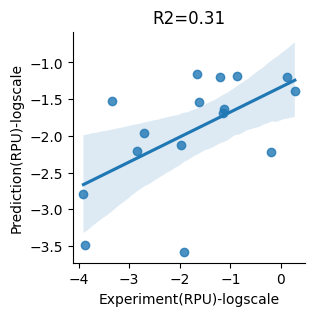

In [27]:
X_train = thermo_feat_train.drop('fluo', axis=1)
y_train = thermo_feat_train['fluo']
X_test = thermo_feat_test.drop('fluo', axis=1)
y_test = thermo_feat_test['fluo']

estimator = HistGradientBoostingRegressor()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
plt.figure(figsize=[3, 3])
sns.regplot(y_test, y_pred)
plt.title('R2={}'.format(np.round(r2_score(y_test, y_pred), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

Feature engineering then train-test split.

In [28]:
thermo_feats = generate_thermo_features(data, encode_non_numeric=True)
thermo_feats.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1296, 6480)

Quick-test using a gradient boosting model.

/Users/mardian/Documents/Edinburgh/intein-based-circuits/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


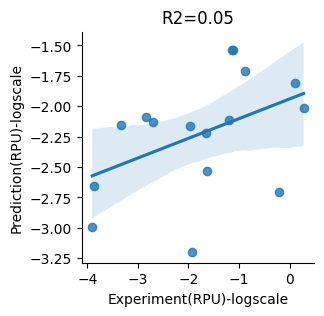

In [29]:
thermo_feat_train = thermo_feats[thermo_feats.index.isin(data_a.index)].reset_index(drop=True)
thermo_feat_test = thermo_feats[thermo_feats.index.isin(data_d.index)].reset_index(drop=True)

X_train = thermo_feat_train.drop('fluo', axis=1)
y_train = thermo_feat_train['fluo']
X_test = thermo_feat_test.drop('fluo', axis=1)
y_test = thermo_feat_test['fluo']

estimator = HistGradientBoostingRegressor()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
plt.figure(figsize=[3, 3])
sns.regplot(y_test, y_pred)
plt.title('R2={}'.format(np.round(r2_score(y_test, y_pred), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

Random split thermodynamics features.

In [33]:
#all the models
regressors = [
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    HistGradientBoostingRegressor(),
    XGBRegressor(),
    CatBoostRegressor(),
    LGBMRegressor(),
    MLPRegressor(),
    SGDRegressor(),
    SVR(),
    LinearRegression(),
    ElasticNet(),
    KernelRidge(),
    BayesianRidge()
]

In [18]:
X = thermo_feats.drop('fluo', axis=1)
y = thermo_feats['fluo']

In [21]:
kf = KFold(n_splits=5, shuffle=True)
est_performances = []
 
for estimator in tqdm(regressors):
    
    r2_scores = []
    y_tests = []
    y_preds = []

    for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):

        X_train = thermo_feats.loc[train_index].drop('fluo', axis=1).values
        X_test = thermo_feats.loc[test_index].drop('fluo', axis=1).values
        y_train = thermo_feats.loc[train_index]['fluo'].values
        y_test = thermo_feats.loc[test_index]['fluo'].values

        #pipe = Pipeline(steps=[#('preprocessor', preprocessor),
        #                  ('regressor', regressor)])
        #pipe.fit(X_train, y_train)
        
        #estimator = HistGradientBoostingRegressor()
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred))
        y_tests.append(y_test.tolist())
        y_preds.append(y_pred.tolist())
        
    est_performances.append((r2_scores, y_tests, y_preds))

  0%|                                                    | 0/14 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [01:07, 67.72s/it]
2it [02:16, 68.39s/it]
3it [03:25, 68.54s/it]
4it [04:30, 67.27s/it]
5it [05:39, 67.88s/it]
  7%|██▉                                      | 1/14 [05:39<1:13:32, 339.42s/it]
0it [00:00, ?it/s]
1it [00:31, 31.08s/it]
2it [01:02, 31.09s/it]
3it [01:33, 31.10s/it]
4it [02:04, 31.06s/it]
5it [02:35, 31.05s/it]
 14%|██████▏                                    | 2/14 [08:14<46:12, 231.08s/it]
0it [00:00, ?it/s]
1it [00:13, 13.77s/it]
2it [00:27, 13.69s/it]
3it [00:41, 13.65s/it]
4it [00:54, 13.77s/it]
5it [01:08, 13.72s/it]
 21%|█████████▏                                 | 3/14 [09:23<28:45, 156.88s/it]
0it [00:00, ?it/s]
1it [00:21, 21.36s/it]
2it [00:42, 21.11s/it]
3it [01:03, 20.97s/it]
4it [01:24, 21.03s/it]
5it [01:45, 21.02s/it]
 29%|████████████▎                              | 4/14 [11:08<22:44, 136.43s/it]
0it [00:00, ?it/s]
1it [00:06,  6.47s/it]
2it [00:12,  6.41

Learning rate set to 0.041172
0:	learn: 0.9159105	total: 354ms	remaining: 5m 53s
1:	learn: 0.9039894	total: 520ms	remaining: 4m 19s
2:	learn: 0.8886303	total: 645ms	remaining: 3m 34s
3:	learn: 0.8761851	total: 759ms	remaining: 3m 9s
4:	learn: 0.8629386	total: 875ms	remaining: 2m 54s
5:	learn: 0.8523470	total: 992ms	remaining: 2m 44s
6:	learn: 0.8399943	total: 1.11s	remaining: 2m 37s
7:	learn: 0.8258988	total: 1.23s	remaining: 2m 32s
8:	learn: 0.8134981	total: 1.35s	remaining: 2m 29s
9:	learn: 0.8043080	total: 1.49s	remaining: 2m 27s
10:	learn: 0.7907728	total: 1.61s	remaining: 2m 24s
11:	learn: 0.7833140	total: 1.72s	remaining: 2m 21s
12:	learn: 0.7748093	total: 1.84s	remaining: 2m 19s
13:	learn: 0.7649482	total: 1.96s	remaining: 2m 17s
14:	learn: 0.7563887	total: 2.08s	remaining: 2m 16s
15:	learn: 0.7464995	total: 2.2s	remaining: 2m 15s
16:	learn: 0.7355194	total: 2.32s	remaining: 2m 14s
17:	learn: 0.7267675	total: 2.44s	remaining: 2m 13s
18:	learn: 0.7184655	total: 2.57s	remaining: 2

158:	learn: 0.3169628	total: 19.4s	remaining: 1m 42s
159:	learn: 0.3157846	total: 19.5s	remaining: 1m 42s
160:	learn: 0.3143873	total: 19.6s	remaining: 1m 42s
161:	learn: 0.3132216	total: 19.8s	remaining: 1m 42s
162:	learn: 0.3121866	total: 19.9s	remaining: 1m 42s
163:	learn: 0.3113184	total: 20s	remaining: 1m 41s
164:	learn: 0.3099670	total: 20.1s	remaining: 1m 41s
165:	learn: 0.3090507	total: 20.2s	remaining: 1m 41s
166:	learn: 0.3076307	total: 20.4s	remaining: 1m 41s
167:	learn: 0.3062325	total: 20.5s	remaining: 1m 41s
168:	learn: 0.3051523	total: 20.6s	remaining: 1m 41s
169:	learn: 0.3045316	total: 20.7s	remaining: 1m 41s
170:	learn: 0.3032653	total: 20.8s	remaining: 1m 40s
171:	learn: 0.3028565	total: 20.9s	remaining: 1m 40s
172:	learn: 0.3022891	total: 21.1s	remaining: 1m 40s
173:	learn: 0.3009928	total: 21.2s	remaining: 1m 40s
174:	learn: 0.3002658	total: 21.3s	remaining: 1m 40s
175:	learn: 0.2995302	total: 21.4s	remaining: 1m 40s
176:	learn: 0.2989275	total: 21.5s	remaining: 1m

314:	learn: 0.1913165	total: 37.7s	remaining: 1m 22s
315:	learn: 0.1907121	total: 37.8s	remaining: 1m 21s
316:	learn: 0.1904184	total: 38s	remaining: 1m 21s
317:	learn: 0.1899063	total: 38.1s	remaining: 1m 21s
318:	learn: 0.1897546	total: 38.2s	remaining: 1m 21s
319:	learn: 0.1890538	total: 38.3s	remaining: 1m 21s
320:	learn: 0.1889016	total: 38.4s	remaining: 1m 21s
321:	learn: 0.1883503	total: 38.5s	remaining: 1m 21s
322:	learn: 0.1876991	total: 38.7s	remaining: 1m 21s
323:	learn: 0.1873004	total: 38.8s	remaining: 1m 20s
324:	learn: 0.1871668	total: 38.9s	remaining: 1m 20s
325:	learn: 0.1863872	total: 39s	remaining: 1m 20s
326:	learn: 0.1859007	total: 39.2s	remaining: 1m 20s
327:	learn: 0.1855242	total: 39.3s	remaining: 1m 20s
328:	learn: 0.1849468	total: 39.4s	remaining: 1m 20s
329:	learn: 0.1844414	total: 39.5s	remaining: 1m 20s
330:	learn: 0.1842947	total: 39.7s	remaining: 1m 20s
331:	learn: 0.1837197	total: 39.8s	remaining: 1m 20s
332:	learn: 0.1830660	total: 39.9s	remaining: 1m 1

472:	learn: 0.1257109	total: 56.7s	remaining: 1m 3s
473:	learn: 0.1251695	total: 56.8s	remaining: 1m 3s
474:	learn: 0.1250132	total: 57s	remaining: 1m 2s
475:	learn: 0.1247003	total: 57.1s	remaining: 1m 2s
476:	learn: 0.1243292	total: 57.2s	remaining: 1m 2s
477:	learn: 0.1242374	total: 57.3s	remaining: 1m 2s
478:	learn: 0.1238425	total: 57.4s	remaining: 1m 2s
479:	learn: 0.1234822	total: 57.6s	remaining: 1m 2s
480:	learn: 0.1231960	total: 57.7s	remaining: 1m 2s
481:	learn: 0.1228997	total: 57.8s	remaining: 1m 2s
482:	learn: 0.1225751	total: 57.9s	remaining: 1m 1s
483:	learn: 0.1225344	total: 58s	remaining: 1m 1s
484:	learn: 0.1219905	total: 58.1s	remaining: 1m 1s
485:	learn: 0.1218889	total: 58.3s	remaining: 1m 1s
486:	learn: 0.1214268	total: 58.4s	remaining: 1m 1s
487:	learn: 0.1210517	total: 58.5s	remaining: 1m 1s
488:	learn: 0.1209879	total: 58.6s	remaining: 1m 1s
489:	learn: 0.1205147	total: 58.7s	remaining: 1m 1s
490:	learn: 0.1202835	total: 58.9s	remaining: 1m 1s
491:	learn: 0.11

632:	learn: 0.0854947	total: 1m 15s	remaining: 43.8s
633:	learn: 0.0853536	total: 1m 15s	remaining: 43.6s
634:	learn: 0.0850539	total: 1m 15s	remaining: 43.5s
635:	learn: 0.0847873	total: 1m 15s	remaining: 43.4s
636:	learn: 0.0844708	total: 1m 15s	remaining: 43.3s
637:	learn: 0.0843526	total: 1m 16s	remaining: 43.1s
638:	learn: 0.0840638	total: 1m 16s	remaining: 43s
639:	learn: 0.0839353	total: 1m 16s	remaining: 42.9s
640:	learn: 0.0837833	total: 1m 16s	remaining: 42.8s
641:	learn: 0.0834701	total: 1m 16s	remaining: 42.7s
642:	learn: 0.0833240	total: 1m 16s	remaining: 42.6s
643:	learn: 0.0831272	total: 1m 16s	remaining: 42.4s
644:	learn: 0.0828724	total: 1m 16s	remaining: 42.3s
645:	learn: 0.0825335	total: 1m 17s	remaining: 42.2s
646:	learn: 0.0823110	total: 1m 17s	remaining: 42.1s
647:	learn: 0.0821133	total: 1m 17s	remaining: 42s
648:	learn: 0.0818921	total: 1m 17s	remaining: 41.9s
649:	learn: 0.0816660	total: 1m 17s	remaining: 41.8s
650:	learn: 0.0814002	total: 1m 17s	remaining: 41.

788:	learn: 0.0589051	total: 1m 33s	remaining: 25.1s
789:	learn: 0.0588656	total: 1m 33s	remaining: 25s
790:	learn: 0.0587470	total: 1m 34s	remaining: 24.8s
791:	learn: 0.0587211	total: 1m 34s	remaining: 24.7s
792:	learn: 0.0585853	total: 1m 34s	remaining: 24.6s
793:	learn: 0.0584102	total: 1m 34s	remaining: 24.5s
794:	learn: 0.0583617	total: 1m 34s	remaining: 24.4s
795:	learn: 0.0582548	total: 1m 34s	remaining: 24.2s
796:	learn: 0.0580596	total: 1m 34s	remaining: 24.1s
797:	learn: 0.0578638	total: 1m 34s	remaining: 24s
798:	learn: 0.0577460	total: 1m 34s	remaining: 23.9s
799:	learn: 0.0576424	total: 1m 35s	remaining: 23.8s
800:	learn: 0.0575079	total: 1m 35s	remaining: 23.6s
801:	learn: 0.0573157	total: 1m 35s	remaining: 23.5s
802:	learn: 0.0571574	total: 1m 35s	remaining: 23.4s
803:	learn: 0.0571122	total: 1m 35s	remaining: 23.3s
804:	learn: 0.0570743	total: 1m 35s	remaining: 23.2s
805:	learn: 0.0569387	total: 1m 35s	remaining: 23.1s
806:	learn: 0.0568186	total: 1m 35s	remaining: 22.

944:	learn: 0.0412670	total: 1m 52s	remaining: 6.52s
945:	learn: 0.0412354	total: 1m 52s	remaining: 6.4s
946:	learn: 0.0411293	total: 1m 52s	remaining: 6.28s
947:	learn: 0.0411097	total: 1m 52s	remaining: 6.17s
948:	learn: 0.0409718	total: 1m 52s	remaining: 6.05s
949:	learn: 0.0408616	total: 1m 52s	remaining: 5.93s
950:	learn: 0.0407935	total: 1m 52s	remaining: 5.81s
951:	learn: 0.0406771	total: 1m 52s	remaining: 5.69s
952:	learn: 0.0405167	total: 1m 53s	remaining: 5.57s
953:	learn: 0.0403777	total: 1m 53s	remaining: 5.45s
954:	learn: 0.0402506	total: 1m 53s	remaining: 5.34s
955:	learn: 0.0401232	total: 1m 53s	remaining: 5.22s
956:	learn: 0.0401064	total: 1m 53s	remaining: 5.1s
957:	learn: 0.0400016	total: 1m 53s	remaining: 4.98s
958:	learn: 0.0399399	total: 1m 53s	remaining: 4.86s
959:	learn: 0.0399021	total: 1m 53s	remaining: 4.74s
960:	learn: 0.0398849	total: 1m 53s	remaining: 4.62s
961:	learn: 0.0397925	total: 1m 54s	remaining: 4.5s
962:	learn: 0.0396699	total: 1m 54s	remaining: 4.


1it [01:58, 118.94s/it]

998:	learn: 0.0366956	total: 1m 58s	remaining: 118ms
999:	learn: 0.0366543	total: 1m 58s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9023282	total: 169ms	remaining: 2m 49s
1:	learn: 0.8886964	total: 365ms	remaining: 3m 2s
2:	learn: 0.8725493	total: 499ms	remaining: 2m 45s
3:	learn: 0.8586183	total: 619ms	remaining: 2m 34s
4:	learn: 0.8470012	total: 737ms	remaining: 2m 26s
5:	learn: 0.8348930	total: 853ms	remaining: 2m 21s
6:	learn: 0.8224286	total: 970ms	remaining: 2m 17s
7:	learn: 0.8120607	total: 1.09s	remaining: 2m 15s
8:	learn: 0.8011476	total: 1.21s	remaining: 2m 12s
9:	learn: 0.7907808	total: 1.32s	remaining: 2m 11s
10:	learn: 0.7822319	total: 1.44s	remaining: 2m 9s
11:	learn: 0.7710977	total: 1.56s	remaining: 2m 8s
12:	learn: 0.7614629	total: 1.68s	remaining: 2m 7s
13:	learn: 0.7507898	total: 1.8s	remaining: 2m 6s
14:	learn: 0.7398921	total: 1.91s	remaining: 2m 5s
15:	learn: 0.7305571	total: 2.02s	remaining: 2m 4s
16:	learn: 0.7231999	total: 2.14s	remaining: 2m 3s
1

157:	learn: 0.3006799	total: 18.8s	remaining: 1m 40s
158:	learn: 0.3000006	total: 18.9s	remaining: 1m 40s
159:	learn: 0.2987152	total: 19s	remaining: 1m 39s
160:	learn: 0.2977087	total: 19.1s	remaining: 1m 39s
161:	learn: 0.2968158	total: 19.3s	remaining: 1m 39s
162:	learn: 0.2956295	total: 19.4s	remaining: 1m 39s
163:	learn: 0.2948831	total: 19.5s	remaining: 1m 39s
164:	learn: 0.2942560	total: 19.6s	remaining: 1m 39s
165:	learn: 0.2927744	total: 19.7s	remaining: 1m 39s
166:	learn: 0.2921504	total: 19.8s	remaining: 1m 38s
167:	learn: 0.2917693	total: 20s	remaining: 1m 38s
168:	learn: 0.2912026	total: 20.1s	remaining: 1m 38s
169:	learn: 0.2902068	total: 20.2s	remaining: 1m 38s
170:	learn: 0.2888791	total: 20.3s	remaining: 1m 38s
171:	learn: 0.2877236	total: 20.4s	remaining: 1m 38s
172:	learn: 0.2874983	total: 20.5s	remaining: 1m 38s
173:	learn: 0.2864928	total: 20.6s	remaining: 1m 37s
174:	learn: 0.2852122	total: 20.8s	remaining: 1m 37s
175:	learn: 0.2843674	total: 20.9s	remaining: 1m 3

313:	learn: 0.1812829	total: 37.1s	remaining: 1m 20s
314:	learn: 0.1807512	total: 37.2s	remaining: 1m 20s
315:	learn: 0.1800257	total: 37.3s	remaining: 1m 20s
316:	learn: 0.1794741	total: 37.4s	remaining: 1m 20s
317:	learn: 0.1787751	total: 37.5s	remaining: 1m 20s
318:	learn: 0.1783280	total: 37.6s	remaining: 1m 20s
319:	learn: 0.1780069	total: 37.8s	remaining: 1m 20s
320:	learn: 0.1775629	total: 37.9s	remaining: 1m 20s
321:	learn: 0.1769128	total: 38s	remaining: 1m 20s
322:	learn: 0.1764090	total: 38.1s	remaining: 1m 19s
323:	learn: 0.1759474	total: 38.2s	remaining: 1m 19s
324:	learn: 0.1753291	total: 38.3s	remaining: 1m 19s
325:	learn: 0.1747942	total: 38.5s	remaining: 1m 19s
326:	learn: 0.1742422	total: 38.6s	remaining: 1m 19s
327:	learn: 0.1737245	total: 38.7s	remaining: 1m 19s
328:	learn: 0.1732578	total: 38.8s	remaining: 1m 19s
329:	learn: 0.1724581	total: 38.9s	remaining: 1m 19s
330:	learn: 0.1720277	total: 39s	remaining: 1m 18s
331:	learn: 0.1715992	total: 39.2s	remaining: 1m 1

471:	learn: 0.1185202	total: 55.9s	remaining: 1m 2s
472:	learn: 0.1182653	total: 56s	remaining: 1m 2s
473:	learn: 0.1178766	total: 56.1s	remaining: 1m 2s
474:	learn: 0.1177952	total: 56.3s	remaining: 1m 2s
475:	learn: 0.1173951	total: 56.4s	remaining: 1m 2s
476:	learn: 0.1173036	total: 56.5s	remaining: 1m 1s
477:	learn: 0.1169698	total: 56.6s	remaining: 1m 1s
478:	learn: 0.1166404	total: 56.7s	remaining: 1m 1s
479:	learn: 0.1162671	total: 56.9s	remaining: 1m 1s
480:	learn: 0.1158305	total: 57s	remaining: 1m 1s
481:	learn: 0.1154491	total: 57.1s	remaining: 1m 1s
482:	learn: 0.1151250	total: 57.2s	remaining: 1m 1s
483:	learn: 0.1147655	total: 57.3s	remaining: 1m 1s
484:	learn: 0.1144501	total: 57.5s	remaining: 1m 1s
485:	learn: 0.1140492	total: 57.6s	remaining: 1m
486:	learn: 0.1137305	total: 57.7s	remaining: 1m
487:	learn: 0.1135843	total: 57.8s	remaining: 1m
488:	learn: 0.1131421	total: 58s	remaining: 1m
489:	learn: 0.1128287	total: 58.1s	remaining: 1m
490:	learn: 0.1124756	total: 58.2

631:	learn: 0.0788370	total: 1m 15s	remaining: 44s
632:	learn: 0.0787330	total: 1m 15s	remaining: 43.9s
633:	learn: 0.0786294	total: 1m 15s	remaining: 43.8s
634:	learn: 0.0782390	total: 1m 15s	remaining: 43.7s
635:	learn: 0.0781883	total: 1m 16s	remaining: 43.5s
636:	learn: 0.0779786	total: 1m 16s	remaining: 43.4s
637:	learn: 0.0777524	total: 1m 16s	remaining: 43.3s
638:	learn: 0.0775938	total: 1m 16s	remaining: 43.2s
639:	learn: 0.0773489	total: 1m 16s	remaining: 43.1s
640:	learn: 0.0771039	total: 1m 16s	remaining: 43s
641:	learn: 0.0768629	total: 1m 16s	remaining: 42.8s
642:	learn: 0.0766713	total: 1m 16s	remaining: 42.7s
643:	learn: 0.0764553	total: 1m 17s	remaining: 42.6s
644:	learn: 0.0763142	total: 1m 17s	remaining: 42.5s
645:	learn: 0.0760309	total: 1m 17s	remaining: 42.4s
646:	learn: 0.0759584	total: 1m 17s	remaining: 42.3s
647:	learn: 0.0757599	total: 1m 17s	remaining: 42.2s
648:	learn: 0.0756005	total: 1m 17s	remaining: 42.1s
649:	learn: 0.0754631	total: 1m 17s	remaining: 42s

787:	learn: 0.0554119	total: 1m 35s	remaining: 25.8s
788:	learn: 0.0553171	total: 1m 35s	remaining: 25.7s
789:	learn: 0.0550930	total: 1m 36s	remaining: 25.6s
790:	learn: 0.0550004	total: 1m 36s	remaining: 25.4s
791:	learn: 0.0549556	total: 1m 36s	remaining: 25.3s
792:	learn: 0.0547922	total: 1m 36s	remaining: 25.2s
793:	learn: 0.0545809	total: 1m 36s	remaining: 25.1s
794:	learn: 0.0544512	total: 1m 36s	remaining: 24.9s
795:	learn: 0.0542801	total: 1m 36s	remaining: 24.8s
796:	learn: 0.0541031	total: 1m 36s	remaining: 24.7s
797:	learn: 0.0540608	total: 1m 37s	remaining: 24.6s
798:	learn: 0.0540164	total: 1m 37s	remaining: 24.5s
799:	learn: 0.0538721	total: 1m 37s	remaining: 24.3s
800:	learn: 0.0537171	total: 1m 37s	remaining: 24.2s
801:	learn: 0.0535979	total: 1m 37s	remaining: 24.1s
802:	learn: 0.0534470	total: 1m 37s	remaining: 24s
803:	learn: 0.0533315	total: 1m 37s	remaining: 23.9s
804:	learn: 0.0531747	total: 1m 37s	remaining: 23.7s
805:	learn: 0.0530075	total: 1m 38s	remaining: 2

943:	learn: 0.0385748	total: 1m 54s	remaining: 6.8s
944:	learn: 0.0385614	total: 1m 54s	remaining: 6.68s
945:	learn: 0.0384660	total: 1m 54s	remaining: 6.56s
946:	learn: 0.0382678	total: 1m 55s	remaining: 6.44s
947:	learn: 0.0381532	total: 1m 55s	remaining: 6.32s
948:	learn: 0.0381206	total: 1m 55s	remaining: 6.19s
949:	learn: 0.0380233	total: 1m 55s	remaining: 6.07s
950:	learn: 0.0378812	total: 1m 55s	remaining: 5.95s
951:	learn: 0.0377488	total: 1m 55s	remaining: 5.83s
952:	learn: 0.0376825	total: 1m 55s	remaining: 5.71s
953:	learn: 0.0375889	total: 1m 55s	remaining: 5.58s
954:	learn: 0.0374972	total: 1m 55s	remaining: 5.46s
955:	learn: 0.0373952	total: 1m 56s	remaining: 5.34s
956:	learn: 0.0372991	total: 1m 56s	remaining: 5.22s
957:	learn: 0.0372720	total: 1m 56s	remaining: 5.1s
958:	learn: 0.0372245	total: 1m 56s	remaining: 4.98s
959:	learn: 0.0371094	total: 1m 56s	remaining: 4.86s
960:	learn: 0.0370208	total: 1m 56s	remaining: 4.73s
961:	learn: 0.0370044	total: 1m 56s	remaining: 4


2it [04:00, 120.63s/it]

999:	learn: 0.0343286	total: 2m 1s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9157594	total: 177ms	remaining: 2m 56s
1:	learn: 0.9020970	total: 422ms	remaining: 3m 30s
2:	learn: 0.8888876	total: 556ms	remaining: 3m 4s
3:	learn: 0.8781505	total: 680ms	remaining: 2m 49s
4:	learn: 0.8667074	total: 807ms	remaining: 2m 40s
5:	learn: 0.8547237	total: 930ms	remaining: 2m 34s
6:	learn: 0.8427179	total: 1.05s	remaining: 2m 28s
7:	learn: 0.8278528	total: 1.17s	remaining: 2m 24s
8:	learn: 0.8164458	total: 1.28s	remaining: 2m 21s
9:	learn: 0.8049939	total: 1.4s	remaining: 2m 18s
10:	learn: 0.7906876	total: 1.52s	remaining: 2m 16s
11:	learn: 0.7822652	total: 1.65s	remaining: 2m 15s
12:	learn: 0.7707992	total: 1.78s	remaining: 2m 14s
13:	learn: 0.7590931	total: 1.89s	remaining: 2m 13s
14:	learn: 0.7507452	total: 2.01s	remaining: 2m 11s
15:	learn: 0.7393017	total: 2.14s	remaining: 2m 11s
16:	learn: 0.7298472	total: 2.25s	remaining: 2m 10s
17:	learn: 0.7196740	total: 2.37s	remaining: 2m 

157:	learn: 0.3048235	total: 19.3s	remaining: 1m 42s
158:	learn: 0.3041487	total: 19.4s	remaining: 1m 42s
159:	learn: 0.3030365	total: 19.5s	remaining: 1m 42s
160:	learn: 0.3019746	total: 19.6s	remaining: 1m 42s
161:	learn: 0.3008985	total: 19.7s	remaining: 1m 42s
162:	learn: 0.3002559	total: 19.9s	remaining: 1m 41s
163:	learn: 0.2990661	total: 20s	remaining: 1m 41s
164:	learn: 0.2981192	total: 20.1s	remaining: 1m 41s
165:	learn: 0.2971796	total: 20.2s	remaining: 1m 41s
166:	learn: 0.2965160	total: 20.3s	remaining: 1m 41s
167:	learn: 0.2955092	total: 20.5s	remaining: 1m 41s
168:	learn: 0.2946074	total: 20.6s	remaining: 1m 41s
169:	learn: 0.2941002	total: 20.7s	remaining: 1m 40s
170:	learn: 0.2935898	total: 20.8s	remaining: 1m 40s
171:	learn: 0.2925512	total: 20.9s	remaining: 1m 40s
172:	learn: 0.2917189	total: 21s	remaining: 1m 40s
173:	learn: 0.2910001	total: 21.2s	remaining: 1m 40s
174:	learn: 0.2903432	total: 21.3s	remaining: 1m 40s
175:	learn: 0.2898182	total: 21.4s	remaining: 1m 4

313:	learn: 0.1881485	total: 37.9s	remaining: 1m 22s
314:	learn: 0.1879190	total: 38s	remaining: 1m 22s
315:	learn: 0.1877434	total: 38.1s	remaining: 1m 22s
316:	learn: 0.1870192	total: 38.3s	remaining: 1m 22s
317:	learn: 0.1864994	total: 38.4s	remaining: 1m 22s
318:	learn: 0.1858426	total: 38.5s	remaining: 1m 22s
319:	learn: 0.1850853	total: 38.6s	remaining: 1m 22s
320:	learn: 0.1844405	total: 38.7s	remaining: 1m 21s
321:	learn: 0.1839625	total: 38.9s	remaining: 1m 21s
322:	learn: 0.1832474	total: 39s	remaining: 1m 21s
323:	learn: 0.1826997	total: 39.1s	remaining: 1m 21s
324:	learn: 0.1824800	total: 39.2s	remaining: 1m 21s
325:	learn: 0.1817706	total: 39.3s	remaining: 1m 21s
326:	learn: 0.1813720	total: 39.5s	remaining: 1m 21s
327:	learn: 0.1807417	total: 39.6s	remaining: 1m 21s
328:	learn: 0.1801850	total: 39.7s	remaining: 1m 20s
329:	learn: 0.1793859	total: 39.8s	remaining: 1m 20s
330:	learn: 0.1786140	total: 39.9s	remaining: 1m 20s
331:	learn: 0.1780424	total: 40.1s	remaining: 1m 2

471:	learn: 0.1191024	total: 56.9s	remaining: 1m 3s
472:	learn: 0.1189473	total: 57s	remaining: 1m 3s
473:	learn: 0.1185662	total: 57.1s	remaining: 1m 3s
474:	learn: 0.1181942	total: 57.3s	remaining: 1m 3s
475:	learn: 0.1177362	total: 57.4s	remaining: 1m 3s
476:	learn: 0.1172666	total: 57.5s	remaining: 1m 3s
477:	learn: 0.1168513	total: 57.6s	remaining: 1m 2s
478:	learn: 0.1163719	total: 57.7s	remaining: 1m 2s
479:	learn: 0.1159592	total: 57.9s	remaining: 1m 2s
480:	learn: 0.1158747	total: 58s	remaining: 1m 2s
481:	learn: 0.1156010	total: 58.1s	remaining: 1m 2s
482:	learn: 0.1151366	total: 58.2s	remaining: 1m 2s
483:	learn: 0.1148772	total: 58.3s	remaining: 1m 2s
484:	learn: 0.1143733	total: 58.5s	remaining: 1m 2s
485:	learn: 0.1141001	total: 58.6s	remaining: 1m 1s
486:	learn: 0.1136202	total: 58.7s	remaining: 1m 1s
487:	learn: 0.1135382	total: 58.8s	remaining: 1m 1s
488:	learn: 0.1132965	total: 59s	remaining: 1m 1s
489:	learn: 0.1129558	total: 59.1s	remaining: 1m 1s
490:	learn: 0.1126

631:	learn: 0.0789729	total: 1m 16s	remaining: 44.6s
632:	learn: 0.0786858	total: 1m 16s	remaining: 44.5s
633:	learn: 0.0784253	total: 1m 16s	remaining: 44.3s
634:	learn: 0.0782215	total: 1m 16s	remaining: 44.2s
635:	learn: 0.0781485	total: 1m 17s	remaining: 44.1s
636:	learn: 0.0780184	total: 1m 17s	remaining: 44s
637:	learn: 0.0777472	total: 1m 17s	remaining: 43.9s
638:	learn: 0.0775146	total: 1m 17s	remaining: 43.8s
639:	learn: 0.0774708	total: 1m 17s	remaining: 43.7s
640:	learn: 0.0772857	total: 1m 17s	remaining: 43.5s
641:	learn: 0.0770330	total: 1m 17s	remaining: 43.4s
642:	learn: 0.0769042	total: 1m 17s	remaining: 43.3s
643:	learn: 0.0767710	total: 1m 18s	remaining: 43.2s
644:	learn: 0.0765812	total: 1m 18s	remaining: 43.1s
645:	learn: 0.0763809	total: 1m 18s	remaining: 42.9s
646:	learn: 0.0763382	total: 1m 18s	remaining: 42.8s
647:	learn: 0.0761674	total: 1m 18s	remaining: 42.7s
648:	learn: 0.0759528	total: 1m 18s	remaining: 42.6s
649:	learn: 0.0756401	total: 1m 18s	remaining: 4

787:	learn: 0.0542070	total: 1m 35s	remaining: 25.7s
788:	learn: 0.0539840	total: 1m 35s	remaining: 25.6s
789:	learn: 0.0538244	total: 1m 35s	remaining: 25.5s
790:	learn: 0.0535716	total: 1m 35s	remaining: 25.3s
791:	learn: 0.0534490	total: 1m 36s	remaining: 25.2s
792:	learn: 0.0533235	total: 1m 36s	remaining: 25.1s
793:	learn: 0.0531827	total: 1m 36s	remaining: 25s
794:	learn: 0.0531350	total: 1m 36s	remaining: 24.9s
795:	learn: 0.0530931	total: 1m 36s	remaining: 24.7s
796:	learn: 0.0530627	total: 1m 36s	remaining: 24.6s
797:	learn: 0.0528958	total: 1m 36s	remaining: 24.5s
798:	learn: 0.0527532	total: 1m 36s	remaining: 24.4s
799:	learn: 0.0527090	total: 1m 36s	remaining: 24.2s
800:	learn: 0.0526369	total: 1m 37s	remaining: 24.1s
801:	learn: 0.0525450	total: 1m 37s	remaining: 24s
802:	learn: 0.0523636	total: 1m 37s	remaining: 23.9s
803:	learn: 0.0521956	total: 1m 37s	remaining: 23.8s
804:	learn: 0.0520305	total: 1m 37s	remaining: 23.6s
805:	learn: 0.0520060	total: 1m 37s	remaining: 23.

943:	learn: 0.0383015	total: 1m 56s	remaining: 6.91s
944:	learn: 0.0382421	total: 1m 56s	remaining: 6.79s
945:	learn: 0.0381564	total: 1m 56s	remaining: 6.67s
946:	learn: 0.0380996	total: 1m 56s	remaining: 6.54s
947:	learn: 0.0379681	total: 1m 57s	remaining: 6.42s
948:	learn: 0.0378958	total: 1m 57s	remaining: 6.3s
949:	learn: 0.0377881	total: 1m 57s	remaining: 6.18s
950:	learn: 0.0376977	total: 1m 57s	remaining: 6.06s
951:	learn: 0.0375775	total: 1m 57s	remaining: 5.94s
952:	learn: 0.0374902	total: 1m 57s	remaining: 5.81s
953:	learn: 0.0374222	total: 1m 58s	remaining: 5.69s
954:	learn: 0.0373077	total: 1m 58s	remaining: 5.57s
955:	learn: 0.0372166	total: 1m 58s	remaining: 5.44s
956:	learn: 0.0372072	total: 1m 58s	remaining: 5.32s
957:	learn: 0.0371004	total: 1m 58s	remaining: 5.2s
958:	learn: 0.0369854	total: 1m 58s	remaining: 5.07s
959:	learn: 0.0368824	total: 1m 58s	remaining: 4.95s
960:	learn: 0.0368736	total: 1m 58s	remaining: 4.83s
961:	learn: 0.0368059	total: 1m 59s	remaining: 4


3it [06:05, 122.35s/it]

999:	learn: 0.0337647	total: 2m 3s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9224385	total: 258ms	remaining: 4m 17s
1:	learn: 0.9091612	total: 521ms	remaining: 4m 20s
2:	learn: 0.8987658	total: 639ms	remaining: 3m 32s
3:	learn: 0.8859639	total: 762ms	remaining: 3m 9s
4:	learn: 0.8753078	total: 883ms	remaining: 2m 55s
5:	learn: 0.8644953	total: 1.01s	remaining: 2m 47s
6:	learn: 0.8532154	total: 1.13s	remaining: 2m 40s
7:	learn: 0.8409077	total: 1.26s	remaining: 2m 36s
8:	learn: 0.8277320	total: 1.38s	remaining: 2m 32s
9:	learn: 0.8159818	total: 1.53s	remaining: 2m 31s
10:	learn: 0.8062083	total: 1.73s	remaining: 2m 35s
11:	learn: 0.7934816	total: 1.93s	remaining: 2m 39s
12:	learn: 0.7837892	total: 2.07s	remaining: 2m 37s
13:	learn: 0.7748567	total: 2.22s	remaining: 2m 36s
14:	learn: 0.7645573	total: 2.36s	remaining: 2m 34s
15:	learn: 0.7531925	total: 2.5s	remaining: 2m 33s
16:	learn: 0.7423152	total: 2.63s	remaining: 2m 32s
17:	learn: 0.7341210	total: 2.78s	remaining: 2m 

157:	learn: 0.3139846	total: 22.5s	remaining: 1m 59s
158:	learn: 0.3128777	total: 22.6s	remaining: 1m 59s
159:	learn: 0.3119697	total: 22.7s	remaining: 1m 59s
160:	learn: 0.3110571	total: 22.9s	remaining: 1m 59s
161:	learn: 0.3098700	total: 23s	remaining: 1m 58s
162:	learn: 0.3083313	total: 23.1s	remaining: 1m 58s
163:	learn: 0.3071202	total: 23.2s	remaining: 1m 58s
164:	learn: 0.3061664	total: 23.4s	remaining: 1m 58s
165:	learn: 0.3056881	total: 23.5s	remaining: 1m 57s
166:	learn: 0.3047553	total: 23.6s	remaining: 1m 57s
167:	learn: 0.3036582	total: 23.7s	remaining: 1m 57s
168:	learn: 0.3023764	total: 23.9s	remaining: 1m 57s
169:	learn: 0.3011030	total: 24s	remaining: 1m 57s
170:	learn: 0.3005467	total: 24.1s	remaining: 1m 56s
171:	learn: 0.2992972	total: 24.2s	remaining: 1m 56s
172:	learn: 0.2984075	total: 24.3s	remaining: 1m 56s
173:	learn: 0.2976644	total: 24.5s	remaining: 1m 56s
174:	learn: 0.2961494	total: 24.6s	remaining: 1m 55s
175:	learn: 0.2953932	total: 24.7s	remaining: 1m 5

313:	learn: 0.1860329	total: 41.6s	remaining: 1m 30s
314:	learn: 0.1853707	total: 41.7s	remaining: 1m 30s
315:	learn: 0.1850470	total: 41.8s	remaining: 1m 30s
316:	learn: 0.1842894	total: 41.9s	remaining: 1m 30s
317:	learn: 0.1841038	total: 42s	remaining: 1m 30s
318:	learn: 0.1834990	total: 42.1s	remaining: 1m 29s
319:	learn: 0.1830927	total: 42.3s	remaining: 1m 29s
320:	learn: 0.1825043	total: 42.4s	remaining: 1m 29s
321:	learn: 0.1817767	total: 42.5s	remaining: 1m 29s
322:	learn: 0.1815697	total: 42.6s	remaining: 1m 29s
323:	learn: 0.1808320	total: 42.7s	remaining: 1m 29s
324:	learn: 0.1801218	total: 42.8s	remaining: 1m 28s
325:	learn: 0.1796151	total: 43s	remaining: 1m 28s
326:	learn: 0.1792891	total: 43.1s	remaining: 1m 28s
327:	learn: 0.1788330	total: 43.2s	remaining: 1m 28s
328:	learn: 0.1783522	total: 43.3s	remaining: 1m 28s
329:	learn: 0.1777444	total: 43.5s	remaining: 1m 28s
330:	learn: 0.1771342	total: 43.6s	remaining: 1m 28s
331:	learn: 0.1765266	total: 43.7s	remaining: 1m 2

469:	learn: 0.1212504	total: 60s	remaining: 1m 7s
470:	learn: 0.1209558	total: 1m	remaining: 1m 7s
471:	learn: 0.1205985	total: 1m	remaining: 1m 7s
472:	learn: 0.1205255	total: 1m	remaining: 1m 7s
473:	learn: 0.1201478	total: 1m	remaining: 1m 7s
474:	learn: 0.1198101	total: 1m	remaining: 1m 6s
475:	learn: 0.1194083	total: 1m	remaining: 1m 6s
476:	learn: 0.1193403	total: 1m	remaining: 1m 6s
477:	learn: 0.1189867	total: 1m	remaining: 1m 6s
478:	learn: 0.1186985	total: 1m 1s	remaining: 1m 6s
479:	learn: 0.1184658	total: 1m 1s	remaining: 1m 6s
480:	learn: 0.1181698	total: 1m 1s	remaining: 1m 6s
481:	learn: 0.1178186	total: 1m 1s	remaining: 1m 5s
482:	learn: 0.1173658	total: 1m 1s	remaining: 1m 5s
483:	learn: 0.1172954	total: 1m 1s	remaining: 1m 5s
484:	learn: 0.1168573	total: 1m 1s	remaining: 1m 5s
485:	learn: 0.1164501	total: 1m 1s	remaining: 1m 5s
486:	learn: 0.1162063	total: 1m 1s	remaining: 1m 5s
487:	learn: 0.1158285	total: 1m 2s	remaining: 1m 5s
488:	learn: 0.1157783	total: 1m 2s	rem

627:	learn: 0.0805163	total: 1m 18s	remaining: 46.5s
628:	learn: 0.0804831	total: 1m 18s	remaining: 46.4s
629:	learn: 0.0803411	total: 1m 18s	remaining: 46.3s
630:	learn: 0.0801988	total: 1m 18s	remaining: 46.1s
631:	learn: 0.0801362	total: 1m 19s	remaining: 46s
632:	learn: 0.0801061	total: 1m 19s	remaining: 45.9s
633:	learn: 0.0799036	total: 1m 19s	remaining: 45.7s
634:	learn: 0.0796419	total: 1m 19s	remaining: 45.6s
635:	learn: 0.0795029	total: 1m 19s	remaining: 45.5s
636:	learn: 0.0792902	total: 1m 19s	remaining: 45.4s
637:	learn: 0.0790859	total: 1m 19s	remaining: 45.2s
638:	learn: 0.0788300	total: 1m 19s	remaining: 45.1s
639:	learn: 0.0785632	total: 1m 19s	remaining: 45s
640:	learn: 0.0785211	total: 1m 20s	remaining: 44.8s
641:	learn: 0.0782522	total: 1m 20s	remaining: 44.7s
642:	learn: 0.0779665	total: 1m 20s	remaining: 44.6s
643:	learn: 0.0779387	total: 1m 20s	remaining: 44.5s
644:	learn: 0.0778255	total: 1m 20s	remaining: 44.4s
645:	learn: 0.0775608	total: 1m 20s	remaining: 44.

784:	learn: 0.0553172	total: 1m 37s	remaining: 26.6s
785:	learn: 0.0551519	total: 1m 37s	remaining: 26.5s
786:	learn: 0.0551334	total: 1m 37s	remaining: 26.4s
787:	learn: 0.0550127	total: 1m 37s	remaining: 26.3s
788:	learn: 0.0549670	total: 1m 37s	remaining: 26.1s
789:	learn: 0.0548435	total: 1m 37s	remaining: 26s
790:	learn: 0.0546244	total: 1m 37s	remaining: 25.9s
791:	learn: 0.0545225	total: 1m 38s	remaining: 25.8s
792:	learn: 0.0544237	total: 1m 38s	remaining: 25.6s
793:	learn: 0.0542098	total: 1m 38s	remaining: 25.5s
794:	learn: 0.0540379	total: 1m 38s	remaining: 25.4s
795:	learn: 0.0538421	total: 1m 38s	remaining: 25.3s
796:	learn: 0.0536332	total: 1m 38s	remaining: 25.1s
797:	learn: 0.0534851	total: 1m 38s	remaining: 25s
798:	learn: 0.0534727	total: 1m 38s	remaining: 24.9s
799:	learn: 0.0533145	total: 1m 39s	remaining: 24.8s
800:	learn: 0.0531918	total: 1m 39s	remaining: 24.6s
801:	learn: 0.0530577	total: 1m 39s	remaining: 24.5s
802:	learn: 0.0529164	total: 1m 39s	remaining: 24.

941:	learn: 0.0383030	total: 1m 56s	remaining: 7.15s
942:	learn: 0.0381725	total: 1m 56s	remaining: 7.02s
943:	learn: 0.0381426	total: 1m 56s	remaining: 6.9s
944:	learn: 0.0380367	total: 1m 56s	remaining: 6.78s
945:	learn: 0.0379719	total: 1m 56s	remaining: 6.65s
946:	learn: 0.0378931	total: 1m 56s	remaining: 6.53s
947:	learn: 0.0377856	total: 1m 56s	remaining: 6.41s
948:	learn: 0.0376507	total: 1m 56s	remaining: 6.28s
949:	learn: 0.0375905	total: 1m 57s	remaining: 6.16s
950:	learn: 0.0374902	total: 1m 57s	remaining: 6.04s
951:	learn: 0.0374372	total: 1m 57s	remaining: 5.91s
952:	learn: 0.0373629	total: 1m 57s	remaining: 5.79s
953:	learn: 0.0372686	total: 1m 57s	remaining: 5.67s
954:	learn: 0.0371509	total: 1m 57s	remaining: 5.54s
955:	learn: 0.0371394	total: 1m 57s	remaining: 5.42s
956:	learn: 0.0371290	total: 1m 57s	remaining: 5.29s
957:	learn: 0.0370824	total: 1m 57s	remaining: 5.17s
958:	learn: 0.0369491	total: 1m 58s	remaining: 5.05s
959:	learn: 0.0369404	total: 1m 58s	remaining: 


4it [08:08, 122.84s/it]

999:	learn: 0.0335953	total: 2m 3s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9269987	total: 268ms	remaining: 4m 28s
1:	learn: 0.9102144	total: 502ms	remaining: 4m 10s
2:	learn: 0.8953220	total: 656ms	remaining: 3m 38s
3:	learn: 0.8847936	total: 796ms	remaining: 3m 18s
4:	learn: 0.8694560	total: 925ms	remaining: 3m 4s
5:	learn: 0.8571124	total: 1.12s	remaining: 3m 4s
6:	learn: 0.8417327	total: 1.27s	remaining: 2m 59s
7:	learn: 0.8316362	total: 1.42s	remaining: 2m 56s
8:	learn: 0.8201366	total: 1.55s	remaining: 2m 50s
9:	learn: 0.8094740	total: 1.68s	remaining: 2m 46s
10:	learn: 0.7988062	total: 1.8s	remaining: 2m 42s
11:	learn: 0.7892818	total: 1.94s	remaining: 2m 39s
12:	learn: 0.7783002	total: 2.07s	remaining: 2m 36s
13:	learn: 0.7681393	total: 2.19s	remaining: 2m 34s
14:	learn: 0.7581364	total: 2.31s	remaining: 2m 32s
15:	learn: 0.7488696	total: 2.45s	remaining: 2m 30s
16:	learn: 0.7390646	total: 2.58s	remaining: 2m 29s
17:	learn: 0.7316052	total: 2.75s	remaining: 2m 2

157:	learn: 0.3134151	total: 20.1s	remaining: 1m 46s
158:	learn: 0.3121979	total: 20.2s	remaining: 1m 46s
159:	learn: 0.3111667	total: 20.3s	remaining: 1m 46s
160:	learn: 0.3102233	total: 20.4s	remaining: 1m 46s
161:	learn: 0.3090002	total: 20.5s	remaining: 1m 46s
162:	learn: 0.3079466	total: 20.7s	remaining: 1m 46s
163:	learn: 0.3069055	total: 20.8s	remaining: 1m 45s
164:	learn: 0.3063553	total: 20.9s	remaining: 1m 45s
165:	learn: 0.3054611	total: 21s	remaining: 1m 45s
166:	learn: 0.3046348	total: 21.1s	remaining: 1m 45s
167:	learn: 0.3034613	total: 21.2s	remaining: 1m 45s
168:	learn: 0.3022917	total: 21.4s	remaining: 1m 45s
169:	learn: 0.3010515	total: 21.5s	remaining: 1m 44s
170:	learn: 0.3003862	total: 21.6s	remaining: 1m 44s
171:	learn: 0.2994689	total: 21.7s	remaining: 1m 44s
172:	learn: 0.2984701	total: 21.8s	remaining: 1m 44s
173:	learn: 0.2974989	total: 21.9s	remaining: 1m 44s
174:	learn: 0.2969715	total: 22.1s	remaining: 1m 44s
175:	learn: 0.2959819	total: 22.2s	remaining: 1m

313:	learn: 0.1881101	total: 38.7s	remaining: 1m 24s
314:	learn: 0.1876965	total: 38.9s	remaining: 1m 24s
315:	learn: 0.1870247	total: 39s	remaining: 1m 24s
316:	learn: 0.1863996	total: 39.1s	remaining: 1m 24s
317:	learn: 0.1858908	total: 39.2s	remaining: 1m 24s
318:	learn: 0.1852841	total: 39.3s	remaining: 1m 23s
319:	learn: 0.1846302	total: 39.5s	remaining: 1m 23s
320:	learn: 0.1840848	total: 39.6s	remaining: 1m 23s
321:	learn: 0.1835335	total: 39.7s	remaining: 1m 23s
322:	learn: 0.1828896	total: 39.8s	remaining: 1m 23s
323:	learn: 0.1822833	total: 40s	remaining: 1m 23s
324:	learn: 0.1816222	total: 40.1s	remaining: 1m 23s
325:	learn: 0.1812372	total: 40.2s	remaining: 1m 23s
326:	learn: 0.1808297	total: 40.3s	remaining: 1m 22s
327:	learn: 0.1804217	total: 40.4s	remaining: 1m 22s
328:	learn: 0.1799836	total: 40.6s	remaining: 1m 22s
329:	learn: 0.1795234	total: 40.7s	remaining: 1m 22s
330:	learn: 0.1788702	total: 40.8s	remaining: 1m 22s
331:	learn: 0.1784473	total: 40.9s	remaining: 1m 2

471:	learn: 0.1227890	total: 57.8s	remaining: 1m 4s
472:	learn: 0.1227395	total: 58s	remaining: 1m 4s
473:	learn: 0.1222767	total: 58.1s	remaining: 1m 4s
474:	learn: 0.1221680	total: 58.2s	remaining: 1m 4s
475:	learn: 0.1218568	total: 58.3s	remaining: 1m 4s
476:	learn: 0.1214225	total: 58.4s	remaining: 1m 4s
477:	learn: 0.1210791	total: 58.5s	remaining: 1m 3s
478:	learn: 0.1207574	total: 58.7s	remaining: 1m 3s
479:	learn: 0.1203272	total: 58.8s	remaining: 1m 3s
480:	learn: 0.1201340	total: 58.9s	remaining: 1m 3s
481:	learn: 0.1198947	total: 59s	remaining: 1m 3s
482:	learn: 0.1195029	total: 59.1s	remaining: 1m 3s
483:	learn: 0.1190414	total: 59.3s	remaining: 1m 3s
484:	learn: 0.1188612	total: 59.4s	remaining: 1m 3s
485:	learn: 0.1184727	total: 59.5s	remaining: 1m 2s
486:	learn: 0.1181302	total: 59.6s	remaining: 1m 2s
487:	learn: 0.1180428	total: 59.7s	remaining: 1m 2s
488:	learn: 0.1177305	total: 59.9s	remaining: 1m 2s
489:	learn: 0.1174205	total: 60s	remaining: 1m 2s
490:	learn: 0.1170

630:	learn: 0.0839001	total: 1m 17s	remaining: 45.2s
631:	learn: 0.0837307	total: 1m 17s	remaining: 45.1s
632:	learn: 0.0835537	total: 1m 17s	remaining: 45s
633:	learn: 0.0832129	total: 1m 17s	remaining: 44.8s
634:	learn: 0.0830384	total: 1m 17s	remaining: 44.7s
635:	learn: 0.0827248	total: 1m 17s	remaining: 44.6s
636:	learn: 0.0825147	total: 1m 18s	remaining: 44.5s
637:	learn: 0.0822861	total: 1m 18s	remaining: 44.3s
638:	learn: 0.0820546	total: 1m 18s	remaining: 44.2s
639:	learn: 0.0818129	total: 1m 18s	remaining: 44.1s
640:	learn: 0.0815510	total: 1m 18s	remaining: 44s
641:	learn: 0.0812768	total: 1m 18s	remaining: 43.8s
642:	learn: 0.0810215	total: 1m 18s	remaining: 43.7s
643:	learn: 0.0807809	total: 1m 18s	remaining: 43.6s
644:	learn: 0.0805908	total: 1m 18s	remaining: 43.5s
645:	learn: 0.0803442	total: 1m 19s	remaining: 43.4s
646:	learn: 0.0800781	total: 1m 19s	remaining: 43.2s
647:	learn: 0.0798660	total: 1m 19s	remaining: 43.1s
648:	learn: 0.0796517	total: 1m 19s	remaining: 43s

786:	learn: 0.0579893	total: 1m 36s	remaining: 26s
787:	learn: 0.0577884	total: 1m 36s	remaining: 25.9s
788:	learn: 0.0576372	total: 1m 36s	remaining: 25.7s
789:	learn: 0.0575289	total: 1m 36s	remaining: 25.6s
790:	learn: 0.0573624	total: 1m 36s	remaining: 25.5s
791:	learn: 0.0571933	total: 1m 36s	remaining: 25.4s
792:	learn: 0.0569766	total: 1m 36s	remaining: 25.3s
793:	learn: 0.0568354	total: 1m 36s	remaining: 25.1s
794:	learn: 0.0566572	total: 1m 36s	remaining: 25s
795:	learn: 0.0565965	total: 1m 37s	remaining: 24.9s
796:	learn: 0.0565341	total: 1m 37s	remaining: 24.8s
797:	learn: 0.0563345	total: 1m 37s	remaining: 24.6s
798:	learn: 0.0562197	total: 1m 37s	remaining: 24.5s
799:	learn: 0.0561515	total: 1m 37s	remaining: 24.4s
800:	learn: 0.0559130	total: 1m 37s	remaining: 24.3s
801:	learn: 0.0557321	total: 1m 37s	remaining: 24.1s
802:	learn: 0.0556354	total: 1m 37s	remaining: 24s
803:	learn: 0.0554243	total: 1m 38s	remaining: 23.9s
804:	learn: 0.0552711	total: 1m 38s	remaining: 23.8s

942:	learn: 0.0395945	total: 1m 54s	remaining: 6.93s
943:	learn: 0.0394723	total: 1m 54s	remaining: 6.81s
944:	learn: 0.0393076	total: 1m 54s	remaining: 6.68s
945:	learn: 0.0391908	total: 1m 54s	remaining: 6.56s
946:	learn: 0.0391444	total: 1m 55s	remaining: 6.44s
947:	learn: 0.0391153	total: 1m 55s	remaining: 6.32s
948:	learn: 0.0390261	total: 1m 55s	remaining: 6.2s
949:	learn: 0.0390013	total: 1m 55s	remaining: 6.08s
950:	learn: 0.0388680	total: 1m 55s	remaining: 5.95s
951:	learn: 0.0388508	total: 1m 55s	remaining: 5.83s
952:	learn: 0.0388029	total: 1m 55s	remaining: 5.71s
953:	learn: 0.0387005	total: 1m 55s	remaining: 5.59s
954:	learn: 0.0385408	total: 1m 56s	remaining: 5.47s
955:	learn: 0.0383941	total: 1m 56s	remaining: 5.35s
956:	learn: 0.0383739	total: 1m 56s	remaining: 5.22s
957:	learn: 0.0383383	total: 1m 56s	remaining: 5.1s
958:	learn: 0.0382761	total: 1m 56s	remaining: 4.98s
959:	learn: 0.0381183	total: 1m 56s	remaining: 4.86s
960:	learn: 0.0380135	total: 1m 56s	remaining: 4


5it [10:10, 122.12s/it]
 43%|██████████████████▍                        | 6/14 [21:52<36:24, 273.08s/it]
0it [00:00, ?it/s]
1it [00:04,  4.09s/it]
2it [00:08,  4.07s/it]
3it [00:12,  4.12s/it]
4it [00:16,  4.10s/it]
5it [00:20,  4.11s/it]
 50%|█████████████████████▌                     | 7/14 [22:12<22:13, 190.51s/it]
0it [00:00, ?it/s]
1it [00:04,  4.09s/it]
2it [00:08,  4.21s/it]
3it [00:18,  6.70s/it]
4it [00:20,  4.88s/it]
5it [00:29,  5.98s/it]
 57%|████████████████████████▌                  | 8/14 [22:42<13:56, 139.38s/it]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  3.78it/s]
3it [00:00,  4.19it/s]
4it [00:01,  3.84it/s]
5it [00:01,  4.03it/s]
 64%|████████████████████████████▎               | 9/14 [22:43<08:01, 96.20s/it]
0it [00:00, ?it/s]
1it [00:04,  4.55s/it]
2it [00:09,  4.52s/it]
3it [00:13,  4.50s/it]
4it [00:17,  4.47s/it]
5it [00:22,  4.49s/it]
 71%|██████████████████████████████▋            | 10/14 [23:06<04:53, 73.43s/it]
0it [00:00, ?it/s]
1it [00:01,  1.

In [25]:
for e in est_performances:
    print(np.mean(e[0]), np.std(e[0]))

0.5928864783145227 0.04404916532804832
0.7054243677398168 0.014371492329378106
0.5660529705611943 0.04237437652312729
0.7942614222198227 0.016010144932512047
0.7228443972846034 0.01622539028628524
0.820641007572776 0.011664548265523739
0.7776631546382455 0.027659174529719627
-5.278839198623445e+51 5.23207413428911e+51
-1.9016462071300677e+138 1.7602864556478163e+138
-0.02097688076506197 0.01765904644110362
-0.03468065354311056 0.06372815896904664
-1.1630783306686039 2.943867096486608
-10.592410413458513 11.080405814252563
-9.467994917791314e+34 1.8925025389103903e+35


In [86]:
seq_feats, seq_feats_label = generate_seq_features(data, kmers=[3, 4, 5, 6])
seq_feats.shape

(1296, 1418)

In [31]:
X = seq_feats.copy()
y = thermo_feats['fluo']

In [28]:
kf = KFold(n_splits=5, shuffle=True)
est_performances_seq = []
 
for estimator in tqdm(regressors):
    
    r2_scores = []
    y_tests = []
    y_preds = []

    for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):

        X_train = seq_feats.loc[train_index].values#.drop('fluo', axis=1).values
        X_test = seq_feats.loc[test_index].values#.drop('fluo', axis=1).values
        y_train = thermo_feats.loc[train_index]['fluo'].values
        y_test = thermo_feats.loc[test_index]['fluo'].values

        #pipe = Pipeline(steps=[#('preprocessor', preprocessor),
        #                  ('regressor', regressor)])
        #pipe.fit(X_train, y_train)
        
        #estimator = HistGradientBoostingRegressor()
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred))
        y_tests.append(y_test.tolist())
        y_preds.append(y_pred.tolist())
        
    est_performances_seq.append((r2_scores, y_tests, y_preds))

  0%|                                                    | 0/14 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:04,  4.71s/it]
2it [00:09,  4.51s/it]
3it [00:13,  4.43s/it]
4it [00:17,  4.40s/it]
5it [00:22,  4.41s/it]
  7%|███▏                                        | 1/14 [00:22<04:46, 22.05s/it]
0it [00:00, ?it/s]
1it [00:01,  1.35s/it]
2it [00:02,  1.35s/it]
3it [00:04,  1.35s/it]
4it [00:05,  1.34s/it]
5it [00:06,  1.34s/it]
 14%|██████▎                                     | 2/14 [00:28<02:36, 13.03s/it]
0it [00:00, ?it/s]
1it [00:00,  1.01it/s]
2it [00:01,  1.02it/s]
3it [00:02,  1.02it/s]
4it [00:03,  1.02it/s]
5it [00:04,  1.02it/s]
 21%|█████████▍                                  | 3/14 [00:33<01:42,  9.33s/it]
0it [00:00, ?it/s]
1it [00:04,  4.98s/it]
2it [00:10,  5.05s/it]
3it [00:15,  5.04s/it]
4it [00:20,  5.02s/it]
5it [00:25,  5.07s/it]
 29%|████████████▌                               | 4/14 [00:59<02:36, 15.65s/it]
0it [00:00, ?it/s]
1it [00:01,  1.23s/it]
2it [00:02,  1.10

Learning rate set to 0.041172
0:	learn: 0.8965414	total: 7.02ms	remaining: 7.02s
1:	learn: 0.8820712	total: 9.46ms	remaining: 4.72s
2:	learn: 0.8671458	total: 12ms	remaining: 4s
3:	learn: 0.8541395	total: 14.6ms	remaining: 3.64s
4:	learn: 0.8439870	total: 16.9ms	remaining: 3.37s
5:	learn: 0.8326871	total: 19.5ms	remaining: 3.23s
6:	learn: 0.8200653	total: 22.3ms	remaining: 3.16s
7:	learn: 0.8087501	total: 25ms	remaining: 3.1s
8:	learn: 0.7964513	total: 27.6ms	remaining: 3.04s
9:	learn: 0.7833158	total: 30.1ms	remaining: 2.98s
10:	learn: 0.7742978	total: 33.3ms	remaining: 2.99s
11:	learn: 0.7642205	total: 35.6ms	remaining: 2.93s
12:	learn: 0.7511159	total: 38.2ms	remaining: 2.9s
13:	learn: 0.7436409	total: 40.8ms	remaining: 2.87s
14:	learn: 0.7329493	total: 43.4ms	remaining: 2.85s
15:	learn: 0.7241409	total: 45.8ms	remaining: 2.81s
16:	learn: 0.7157820	total: 48.2ms	remaining: 2.79s
17:	learn: 0.7086251	total: 50.7ms	remaining: 2.77s
18:	learn: 0.7005265	total: 53ms	remaining: 2.74s
19:

216:	learn: 0.3087241	total: 591ms	remaining: 2.13s
217:	learn: 0.3079063	total: 594ms	remaining: 2.13s
218:	learn: 0.3074706	total: 597ms	remaining: 2.13s
219:	learn: 0.3066774	total: 599ms	remaining: 2.12s
220:	learn: 0.3066060	total: 602ms	remaining: 2.12s
221:	learn: 0.3059568	total: 605ms	remaining: 2.12s
222:	learn: 0.3058225	total: 607ms	remaining: 2.12s
223:	learn: 0.3057307	total: 621ms	remaining: 2.15s
224:	learn: 0.3051665	total: 625ms	remaining: 2.15s
225:	learn: 0.3048754	total: 628ms	remaining: 2.15s
226:	learn: 0.3041681	total: 630ms	remaining: 2.15s
227:	learn: 0.3030606	total: 633ms	remaining: 2.14s
228:	learn: 0.3021426	total: 636ms	remaining: 2.14s
229:	learn: 0.3019066	total: 639ms	remaining: 2.14s
230:	learn: 0.3011285	total: 641ms	remaining: 2.13s
231:	learn: 0.3009800	total: 644ms	remaining: 2.13s
232:	learn: 0.3009264	total: 646ms	remaining: 2.13s
233:	learn: 0.3004780	total: 648ms	remaining: 2.12s
234:	learn: 0.2994364	total: 651ms	remaining: 2.12s
235:	learn: 

433:	learn: 0.2322993	total: 1.19s	remaining: 1.55s
434:	learn: 0.2321140	total: 1.19s	remaining: 1.55s
435:	learn: 0.2318300	total: 1.2s	remaining: 1.54s
436:	learn: 0.2315702	total: 1.2s	remaining: 1.54s
437:	learn: 0.2311813	total: 1.2s	remaining: 1.54s
438:	learn: 0.2308547	total: 1.21s	remaining: 1.54s
439:	learn: 0.2305527	total: 1.21s	remaining: 1.54s
440:	learn: 0.2302491	total: 1.21s	remaining: 1.53s
441:	learn: 0.2302301	total: 1.21s	remaining: 1.53s
442:	learn: 0.2297763	total: 1.22s	remaining: 1.53s
443:	learn: 0.2294444	total: 1.22s	remaining: 1.53s
444:	learn: 0.2289800	total: 1.23s	remaining: 1.53s
445:	learn: 0.2287008	total: 1.23s	remaining: 1.52s
446:	learn: 0.2284151	total: 1.23s	remaining: 1.52s
447:	learn: 0.2280014	total: 1.23s	remaining: 1.52s
448:	learn: 0.2279833	total: 1.24s	remaining: 1.52s
449:	learn: 0.2278522	total: 1.24s	remaining: 1.51s
450:	learn: 0.2274749	total: 1.24s	remaining: 1.51s
451:	learn: 0.2272296	total: 1.24s	remaining: 1.51s
452:	learn: 0.2

645:	learn: 0.1892264	total: 1.77s	remaining: 970ms
646:	learn: 0.1891170	total: 1.77s	remaining: 967ms
647:	learn: 0.1889202	total: 1.77s	remaining: 964ms
648:	learn: 0.1889087	total: 1.78s	remaining: 961ms
649:	learn: 0.1888869	total: 1.78s	remaining: 958ms
650:	learn: 0.1886917	total: 1.78s	remaining: 955ms
651:	learn: 0.1885153	total: 1.78s	remaining: 953ms
652:	learn: 0.1885042	total: 1.79s	remaining: 950ms
653:	learn: 0.1882090	total: 1.79s	remaining: 947ms
654:	learn: 0.1880019	total: 1.79s	remaining: 944ms
655:	learn: 0.1878643	total: 1.79s	remaining: 942ms
656:	learn: 0.1876204	total: 1.8s	remaining: 939ms
657:	learn: 0.1875007	total: 1.8s	remaining: 936ms
658:	learn: 0.1872980	total: 1.8s	remaining: 933ms
659:	learn: 0.1871455	total: 1.81s	remaining: 931ms
660:	learn: 0.1869173	total: 1.81s	remaining: 928ms
661:	learn: 0.1867449	total: 1.81s	remaining: 925ms
662:	learn: 0.1865858	total: 1.81s	remaining: 923ms
663:	learn: 0.1864153	total: 1.82s	remaining: 920ms
664:	learn: 0.1

871:	learn: 0.1575753	total: 2.37s	remaining: 348ms
872:	learn: 0.1574886	total: 2.38s	remaining: 346ms
873:	learn: 0.1574828	total: 2.38s	remaining: 343ms
874:	learn: 0.1572346	total: 2.38s	remaining: 340ms
875:	learn: 0.1571296	total: 2.38s	remaining: 338ms
876:	learn: 0.1571228	total: 2.39s	remaining: 335ms
877:	learn: 0.1569497	total: 2.39s	remaining: 332ms
878:	learn: 0.1567864	total: 2.39s	remaining: 329ms
879:	learn: 0.1566450	total: 2.4s	remaining: 327ms
880:	learn: 0.1564566	total: 2.4s	remaining: 324ms
881:	learn: 0.1562459	total: 2.4s	remaining: 321ms
882:	learn: 0.1561310	total: 2.4s	remaining: 318ms
883:	learn: 0.1560283	total: 2.4s	remaining: 316ms
884:	learn: 0.1558710	total: 2.41s	remaining: 313ms
885:	learn: 0.1558585	total: 2.41s	remaining: 310ms
886:	learn: 0.1556927	total: 2.41s	remaining: 308ms
887:	learn: 0.1556251	total: 2.42s	remaining: 305ms
888:	learn: 0.1555033	total: 2.42s	remaining: 302ms
889:	learn: 0.1553657	total: 2.42s	remaining: 299ms
890:	learn: 0.155


1it [00:03,  3.06s/it]

986:	learn: 0.1453838	total: 2.77s	remaining: 36.5ms
987:	learn: 0.1452642	total: 2.77s	remaining: 33.7ms
988:	learn: 0.1451476	total: 2.78s	remaining: 30.9ms
989:	learn: 0.1450594	total: 2.78s	remaining: 28.1ms
990:	learn: 0.1449779	total: 2.78s	remaining: 25.3ms
991:	learn: 0.1448284	total: 2.79s	remaining: 22.5ms
992:	learn: 0.1447234	total: 2.79s	remaining: 19.7ms
993:	learn: 0.1446868	total: 2.79s	remaining: 16.9ms
994:	learn: 0.1445268	total: 2.8s	remaining: 14.1ms
995:	learn: 0.1444077	total: 2.8s	remaining: 11.2ms
996:	learn: 0.1442308	total: 2.8s	remaining: 8.43ms
997:	learn: 0.1441017	total: 2.8s	remaining: 5.62ms
998:	learn: 0.1440163	total: 2.81s	remaining: 2.81ms
999:	learn: 0.1439234	total: 2.82s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9176171	total: 3.57ms	remaining: 3.57s
1:	learn: 0.9049813	total: 6.17ms	remaining: 3.08s
2:	learn: 0.8889555	total: 9.64ms	remaining: 3.2s
3:	learn: 0.8754322	total: 11.8ms	remaining: 2.93s
4:	learn: 0.8612749	total: 13.9m

148:	learn: 0.3617703	total: 399ms	remaining: 2.28s
149:	learn: 0.3613166	total: 403ms	remaining: 2.28s
150:	learn: 0.3597593	total: 406ms	remaining: 2.28s
151:	learn: 0.3592321	total: 408ms	remaining: 2.28s
152:	learn: 0.3583354	total: 410ms	remaining: 2.27s
153:	learn: 0.3573931	total: 413ms	remaining: 2.27s
154:	learn: 0.3569075	total: 415ms	remaining: 2.26s
155:	learn: 0.3559041	total: 417ms	remaining: 2.26s
156:	learn: 0.3551132	total: 420ms	remaining: 2.25s
157:	learn: 0.3545096	total: 423ms	remaining: 2.25s
158:	learn: 0.3538844	total: 428ms	remaining: 2.26s
159:	learn: 0.3530854	total: 430ms	remaining: 2.26s
160:	learn: 0.3520562	total: 433ms	remaining: 2.25s
161:	learn: 0.3510573	total: 435ms	remaining: 2.25s
162:	learn: 0.3504421	total: 438ms	remaining: 2.25s
163:	learn: 0.3490156	total: 440ms	remaining: 2.24s
164:	learn: 0.3485724	total: 442ms	remaining: 2.24s
165:	learn: 0.3480460	total: 444ms	remaining: 2.23s
166:	learn: 0.3473480	total: 446ms	remaining: 2.23s
167:	learn: 

324:	learn: 0.2635983	total: 797ms	remaining: 1.66s
325:	learn: 0.2635627	total: 799ms	remaining: 1.65s
326:	learn: 0.2631321	total: 801ms	remaining: 1.65s
327:	learn: 0.2626339	total: 804ms	remaining: 1.65s
328:	learn: 0.2625992	total: 806ms	remaining: 1.64s
329:	learn: 0.2621365	total: 808ms	remaining: 1.64s
330:	learn: 0.2617034	total: 810ms	remaining: 1.64s
331:	learn: 0.2612529	total: 812ms	remaining: 1.63s
332:	learn: 0.2605040	total: 815ms	remaining: 1.63s
333:	learn: 0.2604699	total: 816ms	remaining: 1.63s
334:	learn: 0.2599629	total: 818ms	remaining: 1.62s
335:	learn: 0.2599125	total: 820ms	remaining: 1.62s
336:	learn: 0.2598772	total: 823ms	remaining: 1.62s
337:	learn: 0.2598481	total: 826ms	remaining: 1.62s
338:	learn: 0.2593843	total: 828ms	remaining: 1.61s
339:	learn: 0.2588198	total: 830ms	remaining: 1.61s
340:	learn: 0.2587927	total: 832ms	remaining: 1.61s
341:	learn: 0.2584306	total: 834ms	remaining: 1.6s
342:	learn: 0.2580112	total: 836ms	remaining: 1.6s
343:	learn: 0.

502:	learn: 0.2165400	total: 1.2s	remaining: 1.18s
503:	learn: 0.2162333	total: 1.2s	remaining: 1.18s
504:	learn: 0.2160376	total: 1.21s	remaining: 1.18s
505:	learn: 0.2160223	total: 1.21s	remaining: 1.18s
506:	learn: 0.2156797	total: 1.21s	remaining: 1.18s
507:	learn: 0.2154214	total: 1.21s	remaining: 1.18s
508:	learn: 0.2154039	total: 1.22s	remaining: 1.17s
509:	learn: 0.2150182	total: 1.22s	remaining: 1.17s
510:	learn: 0.2150025	total: 1.22s	remaining: 1.17s
511:	learn: 0.2147054	total: 1.23s	remaining: 1.17s
512:	learn: 0.2143871	total: 1.23s	remaining: 1.17s
513:	learn: 0.2141626	total: 1.23s	remaining: 1.16s
514:	learn: 0.2141418	total: 1.23s	remaining: 1.16s
515:	learn: 0.2138627	total: 1.24s	remaining: 1.16s
516:	learn: 0.2138409	total: 1.25s	remaining: 1.17s
517:	learn: 0.2137309	total: 1.25s	remaining: 1.17s
518:	learn: 0.2133255	total: 1.26s	remaining: 1.17s
519:	learn: 0.2130405	total: 1.26s	remaining: 1.16s
520:	learn: 0.2127177	total: 1.26s	remaining: 1.16s
521:	learn: 0.

668:	learn: 0.1868505	total: 1.6s	remaining: 791ms
669:	learn: 0.1865149	total: 1.6s	remaining: 788ms
670:	learn: 0.1865009	total: 1.6s	remaining: 786ms
671:	learn: 0.1864906	total: 1.6s	remaining: 783ms
672:	learn: 0.1863204	total: 1.61s	remaining: 781ms
673:	learn: 0.1861968	total: 1.61s	remaining: 778ms
674:	learn: 0.1860457	total: 1.61s	remaining: 776ms
675:	learn: 0.1860361	total: 1.61s	remaining: 773ms
676:	learn: 0.1860267	total: 1.61s	remaining: 771ms
677:	learn: 0.1859255	total: 1.62s	remaining: 768ms
678:	learn: 0.1857647	total: 1.62s	remaining: 766ms
679:	learn: 0.1855024	total: 1.62s	remaining: 764ms
680:	learn: 0.1854927	total: 1.62s	remaining: 761ms
681:	learn: 0.1851931	total: 1.63s	remaining: 759ms
682:	learn: 0.1849714	total: 1.63s	remaining: 756ms
683:	learn: 0.1847380	total: 1.63s	remaining: 754ms
684:	learn: 0.1847290	total: 1.63s	remaining: 751ms
685:	learn: 0.1844612	total: 1.64s	remaining: 748ms
686:	learn: 0.1842800	total: 1.64s	remaining: 746ms
687:	learn: 0.18

849:	learn: 0.1634114	total: 2s	remaining: 352ms
850:	learn: 0.1631850	total: 2s	remaining: 350ms
851:	learn: 0.1630297	total: 2s	remaining: 348ms
852:	learn: 0.1630244	total: 2s	remaining: 345ms
853:	learn: 0.1630173	total: 2s	remaining: 343ms
854:	learn: 0.1628713	total: 2.01s	remaining: 340ms
855:	learn: 0.1626741	total: 2.01s	remaining: 338ms
856:	learn: 0.1624626	total: 2.01s	remaining: 336ms
857:	learn: 0.1621903	total: 2.01s	remaining: 333ms
858:	learn: 0.1620599	total: 2.02s	remaining: 331ms
859:	learn: 0.1618950	total: 2.02s	remaining: 329ms
860:	learn: 0.1616895	total: 2.02s	remaining: 326ms
861:	learn: 0.1616833	total: 2.02s	remaining: 324ms
862:	learn: 0.1614645	total: 2.03s	remaining: 322ms
863:	learn: 0.1613189	total: 2.03s	remaining: 319ms
864:	learn: 0.1611750	total: 2.03s	remaining: 317ms
865:	learn: 0.1609565	total: 2.03s	remaining: 315ms
866:	learn: 0.1608135	total: 2.04s	remaining: 312ms
867:	learn: 0.1608044	total: 2.04s	remaining: 310ms
868:	learn: 0.1605821	total


2it [00:05,  2.73s/it]

930:	learn: 0.1526282	total: 2.19s	remaining: 162ms
931:	learn: 0.1524304	total: 2.2s	remaining: 160ms
932:	learn: 0.1522733	total: 2.2s	remaining: 158ms
933:	learn: 0.1522679	total: 2.2s	remaining: 156ms
934:	learn: 0.1522623	total: 2.2s	remaining: 153ms
935:	learn: 0.1522576	total: 2.21s	remaining: 151ms
936:	learn: 0.1521324	total: 2.21s	remaining: 149ms
937:	learn: 0.1520506	total: 2.21s	remaining: 146ms
938:	learn: 0.1520437	total: 2.21s	remaining: 144ms
939:	learn: 0.1518812	total: 2.21s	remaining: 141ms
940:	learn: 0.1516815	total: 2.22s	remaining: 139ms
941:	learn: 0.1514961	total: 2.22s	remaining: 137ms
942:	learn: 0.1514920	total: 2.22s	remaining: 134ms
943:	learn: 0.1512955	total: 2.23s	remaining: 132ms
944:	learn: 0.1511096	total: 2.23s	remaining: 130ms
945:	learn: 0.1511016	total: 2.23s	remaining: 127ms
946:	learn: 0.1508615	total: 2.23s	remaining: 125ms
947:	learn: 0.1507608	total: 2.23s	remaining: 123ms
948:	learn: 0.1506185	total: 2.24s	remaining: 120ms
949:	learn: 0.15

151:	learn: 0.3570530	total: 398ms	remaining: 2.22s
152:	learn: 0.3565333	total: 400ms	remaining: 2.22s
153:	learn: 0.3559363	total: 403ms	remaining: 2.21s
154:	learn: 0.3547396	total: 405ms	remaining: 2.21s
155:	learn: 0.3537450	total: 408ms	remaining: 2.21s
156:	learn: 0.3531259	total: 410ms	remaining: 2.2s
157:	learn: 0.3522162	total: 413ms	remaining: 2.2s
158:	learn: 0.3517452	total: 415ms	remaining: 2.2s
159:	learn: 0.3509652	total: 418ms	remaining: 2.19s
160:	learn: 0.3499343	total: 420ms	remaining: 2.19s
161:	learn: 0.3492767	total: 423ms	remaining: 2.19s
162:	learn: 0.3481323	total: 426ms	remaining: 2.19s
163:	learn: 0.3476279	total: 428ms	remaining: 2.18s
164:	learn: 0.3469314	total: 431ms	remaining: 2.18s
165:	learn: 0.3460186	total: 433ms	remaining: 2.18s
166:	learn: 0.3448318	total: 437ms	remaining: 2.18s
167:	learn: 0.3441041	total: 440ms	remaining: 2.18s
168:	learn: 0.3430498	total: 443ms	remaining: 2.18s
169:	learn: 0.3418586	total: 446ms	remaining: 2.18s
170:	learn: 0.3

378:	learn: 0.2435085	total: 996ms	remaining: 1.63s
379:	learn: 0.2434752	total: 998ms	remaining: 1.63s
380:	learn: 0.2434390	total: 1s	remaining: 1.63s
381:	learn: 0.2434130	total: 1s	remaining: 1.62s
382:	learn: 0.2430310	total: 1s	remaining: 1.62s
383:	learn: 0.2428023	total: 1.01s	remaining: 1.62s
384:	learn: 0.2424141	total: 1.01s	remaining: 1.61s
385:	learn: 0.2420190	total: 1.01s	remaining: 1.61s
386:	learn: 0.2417105	total: 1.02s	remaining: 1.61s
387:	learn: 0.2413321	total: 1.02s	remaining: 1.61s
388:	learn: 0.2413071	total: 1.02s	remaining: 1.6s
389:	learn: 0.2408547	total: 1.02s	remaining: 1.6s
390:	learn: 0.2404991	total: 1.03s	remaining: 1.6s
391:	learn: 0.2400654	total: 1.03s	remaining: 1.6s
392:	learn: 0.2395575	total: 1.03s	remaining: 1.59s
393:	learn: 0.2393152	total: 1.03s	remaining: 1.59s
394:	learn: 0.2389138	total: 1.04s	remaining: 1.59s
395:	learn: 0.2385833	total: 1.04s	remaining: 1.58s
396:	learn: 0.2381262	total: 1.04s	remaining: 1.58s
397:	learn: 0.2377001	tot

609:	learn: 0.1888589	total: 1.6s	remaining: 1.02s
610:	learn: 0.1886801	total: 1.6s	remaining: 1.02s
611:	learn: 0.1884198	total: 1.6s	remaining: 1.01s
612:	learn: 0.1881844	total: 1.6s	remaining: 1.01s
613:	learn: 0.1881590	total: 1.61s	remaining: 1.01s
614:	learn: 0.1879536	total: 1.61s	remaining: 1.01s
615:	learn: 0.1879443	total: 1.61s	remaining: 1s
616:	learn: 0.1879297	total: 1.61s	remaining: 1s
617:	learn: 0.1877286	total: 1.61s	remaining: 999ms
618:	learn: 0.1875852	total: 1.62s	remaining: 996ms
619:	learn: 0.1874650	total: 1.62s	remaining: 993ms
620:	learn: 0.1873155	total: 1.62s	remaining: 991ms
621:	learn: 0.1871088	total: 1.63s	remaining: 988ms
622:	learn: 0.1870977	total: 1.63s	remaining: 985ms
623:	learn: 0.1868869	total: 1.63s	remaining: 983ms
624:	learn: 0.1867645	total: 1.63s	remaining: 980ms
625:	learn: 0.1866182	total: 1.64s	remaining: 978ms
626:	learn: 0.1863961	total: 1.64s	remaining: 975ms
627:	learn: 0.1862269	total: 1.64s	remaining: 972ms
628:	learn: 0.1860256	

844:	learn: 0.1583247	total: 2.2s	remaining: 403ms
845:	learn: 0.1583117	total: 2.2s	remaining: 400ms
846:	learn: 0.1581025	total: 2.2s	remaining: 398ms
847:	learn: 0.1579798	total: 2.2s	remaining: 395ms
848:	learn: 0.1577366	total: 2.21s	remaining: 393ms
849:	learn: 0.1575439	total: 2.21s	remaining: 390ms
850:	learn: 0.1573933	total: 2.21s	remaining: 387ms
851:	learn: 0.1573901	total: 2.21s	remaining: 385ms
852:	learn: 0.1573772	total: 2.22s	remaining: 382ms
853:	learn: 0.1572954	total: 2.22s	remaining: 380ms
854:	learn: 0.1571582	total: 2.22s	remaining: 377ms
855:	learn: 0.1571545	total: 2.23s	remaining: 374ms
856:	learn: 0.1569658	total: 2.23s	remaining: 372ms
857:	learn: 0.1568434	total: 2.23s	remaining: 370ms
858:	learn: 0.1568389	total: 2.24s	remaining: 368ms
859:	learn: 0.1568257	total: 2.25s	remaining: 366ms
860:	learn: 0.1566336	total: 2.25s	remaining: 363ms
861:	learn: 0.1566286	total: 2.25s	remaining: 361ms
862:	learn: 0.1564345	total: 2.25s	remaining: 358ms
863:	learn: 0.15


3it [00:08,  2.74s/it]

982:	learn: 0.1454439	total: 2.58s	remaining: 44.6ms
983:	learn: 0.1454404	total: 2.58s	remaining: 42ms
984:	learn: 0.1453112	total: 2.58s	remaining: 39.4ms
985:	learn: 0.1453084	total: 2.59s	remaining: 36.7ms
986:	learn: 0.1453034	total: 2.59s	remaining: 34.1ms
987:	learn: 0.1452373	total: 2.59s	remaining: 31.5ms
988:	learn: 0.1452293	total: 2.59s	remaining: 28.9ms
989:	learn: 0.1450964	total: 2.6s	remaining: 26.2ms
990:	learn: 0.1449443	total: 2.6s	remaining: 23.6ms
991:	learn: 0.1448475	total: 2.6s	remaining: 21ms
992:	learn: 0.1447138	total: 2.6s	remaining: 18.4ms
993:	learn: 0.1445768	total: 2.61s	remaining: 15.7ms
994:	learn: 0.1444333	total: 2.61s	remaining: 13.1ms
995:	learn: 0.1444296	total: 2.61s	remaining: 10.5ms
996:	learn: 0.1441818	total: 2.62s	remaining: 7.87ms
997:	learn: 0.1440965	total: 2.62s	remaining: 5.25ms
998:	learn: 0.1439533	total: 2.62s	remaining: 2.62ms
999:	learn: 0.1437905	total: 2.62s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9071088	total: 

191:	learn: 0.3256395	total: 509ms	remaining: 2.14s
192:	learn: 0.3248936	total: 511ms	remaining: 2.14s
193:	learn: 0.3244434	total: 514ms	remaining: 2.13s
194:	learn: 0.3233759	total: 516ms	remaining: 2.13s
195:	learn: 0.3226305	total: 519ms	remaining: 2.13s
196:	learn: 0.3223157	total: 521ms	remaining: 2.12s
197:	learn: 0.3218262	total: 524ms	remaining: 2.12s
198:	learn: 0.3212519	total: 526ms	remaining: 2.12s
199:	learn: 0.3207144	total: 529ms	remaining: 2.12s
200:	learn: 0.3204564	total: 531ms	remaining: 2.11s
201:	learn: 0.3194695	total: 534ms	remaining: 2.11s
202:	learn: 0.3193926	total: 536ms	remaining: 2.1s
203:	learn: 0.3182919	total: 539ms	remaining: 2.1s
204:	learn: 0.3176577	total: 542ms	remaining: 2.1s
205:	learn: 0.3168988	total: 544ms	remaining: 2.1s
206:	learn: 0.3163160	total: 547ms	remaining: 2.1s
207:	learn: 0.3155955	total: 550ms	remaining: 2.09s
208:	learn: 0.3155374	total: 554ms	remaining: 2.1s
209:	learn: 0.3147192	total: 559ms	remaining: 2.1s
210:	learn: 0.31403

414:	learn: 0.2352297	total: 1.11s	remaining: 1.56s
415:	learn: 0.2351892	total: 1.11s	remaining: 1.56s
416:	learn: 0.2351580	total: 1.11s	remaining: 1.55s
417:	learn: 0.2347968	total: 1.11s	remaining: 1.55s
418:	learn: 0.2344824	total: 1.12s	remaining: 1.55s
419:	learn: 0.2341188	total: 1.12s	remaining: 1.54s
420:	learn: 0.2339755	total: 1.12s	remaining: 1.54s
421:	learn: 0.2337250	total: 1.12s	remaining: 1.54s
422:	learn: 0.2333963	total: 1.13s	remaining: 1.54s
423:	learn: 0.2330189	total: 1.13s	remaining: 1.53s
424:	learn: 0.2326026	total: 1.13s	remaining: 1.53s
425:	learn: 0.2323593	total: 1.14s	remaining: 1.53s
426:	learn: 0.2321727	total: 1.14s	remaining: 1.53s
427:	learn: 0.2319198	total: 1.14s	remaining: 1.52s
428:	learn: 0.2314560	total: 1.14s	remaining: 1.52s
429:	learn: 0.2314331	total: 1.15s	remaining: 1.52s
430:	learn: 0.2310979	total: 1.15s	remaining: 1.52s
431:	learn: 0.2310694	total: 1.15s	remaining: 1.52s
432:	learn: 0.2308919	total: 1.16s	remaining: 1.51s
433:	learn: 

647:	learn: 0.1887770	total: 1.72s	remaining: 933ms
648:	learn: 0.1887001	total: 1.72s	remaining: 931ms
649:	learn: 0.1884770	total: 1.72s	remaining: 928ms
650:	learn: 0.1883817	total: 1.73s	remaining: 925ms
651:	learn: 0.1883462	total: 1.73s	remaining: 922ms
652:	learn: 0.1883133	total: 1.73s	remaining: 920ms
653:	learn: 0.1880873	total: 1.73s	remaining: 917ms
654:	learn: 0.1878482	total: 1.74s	remaining: 914ms
655:	learn: 0.1878219	total: 1.74s	remaining: 913ms
656:	learn: 0.1878109	total: 1.74s	remaining: 910ms
657:	learn: 0.1876728	total: 1.75s	remaining: 908ms
658:	learn: 0.1874522	total: 1.75s	remaining: 905ms
659:	learn: 0.1874419	total: 1.75s	remaining: 902ms
660:	learn: 0.1874298	total: 1.75s	remaining: 899ms
661:	learn: 0.1874088	total: 1.76s	remaining: 897ms
662:	learn: 0.1872435	total: 1.76s	remaining: 894ms
663:	learn: 0.1869126	total: 1.76s	remaining: 891ms
664:	learn: 0.1868595	total: 1.76s	remaining: 889ms
665:	learn: 0.1868508	total: 1.77s	remaining: 886ms
666:	learn: 

864:	learn: 0.1603248	total: 2.3s	remaining: 359ms
865:	learn: 0.1602791	total: 2.31s	remaining: 357ms
866:	learn: 0.1601167	total: 2.31s	remaining: 354ms
867:	learn: 0.1601013	total: 2.31s	remaining: 351ms
868:	learn: 0.1599880	total: 2.31s	remaining: 349ms
869:	learn: 0.1598399	total: 2.31s	remaining: 346ms
870:	learn: 0.1597098	total: 2.32s	remaining: 343ms
871:	learn: 0.1596970	total: 2.32s	remaining: 341ms
872:	learn: 0.1595723	total: 2.32s	remaining: 338ms
873:	learn: 0.1593077	total: 2.33s	remaining: 335ms
874:	learn: 0.1591585	total: 2.33s	remaining: 333ms
875:	learn: 0.1590585	total: 2.33s	remaining: 330ms
876:	learn: 0.1590501	total: 2.34s	remaining: 328ms
877:	learn: 0.1589983	total: 2.34s	remaining: 325ms
878:	learn: 0.1589901	total: 2.34s	remaining: 323ms
879:	learn: 0.1589837	total: 2.35s	remaining: 320ms
880:	learn: 0.1587232	total: 2.35s	remaining: 317ms
881:	learn: 0.1587168	total: 2.35s	remaining: 315ms
882:	learn: 0.1584927	total: 2.35s	remaining: 312ms
883:	learn: 0


4it [00:11,  2.75s/it]

937:	learn: 0.1526422	total: 2.5s	remaining: 165ms
938:	learn: 0.1526364	total: 2.5s	remaining: 163ms
939:	learn: 0.1525225	total: 2.51s	remaining: 160ms
940:	learn: 0.1525058	total: 2.51s	remaining: 157ms
941:	learn: 0.1524594	total: 2.51s	remaining: 155ms
942:	learn: 0.1522519	total: 2.51s	remaining: 152ms
943:	learn: 0.1521285	total: 2.52s	remaining: 149ms
944:	learn: 0.1519359	total: 2.52s	remaining: 147ms
945:	learn: 0.1518402	total: 2.52s	remaining: 144ms
946:	learn: 0.1517336	total: 2.52s	remaining: 141ms
947:	learn: 0.1515548	total: 2.53s	remaining: 139ms
948:	learn: 0.1514239	total: 2.53s	remaining: 136ms
949:	learn: 0.1511943	total: 2.53s	remaining: 133ms
950:	learn: 0.1509719	total: 2.54s	remaining: 131ms
951:	learn: 0.1508762	total: 2.54s	remaining: 128ms
952:	learn: 0.1507923	total: 2.54s	remaining: 125ms
953:	learn: 0.1506420	total: 2.54s	remaining: 123ms
954:	learn: 0.1504987	total: 2.55s	remaining: 120ms
955:	learn: 0.1504132	total: 2.55s	remaining: 118ms
956:	learn: 0.

152:	learn: 0.3568370	total: 397ms	remaining: 2.2s
153:	learn: 0.3561215	total: 399ms	remaining: 2.19s
154:	learn: 0.3549833	total: 402ms	remaining: 2.19s
155:	learn: 0.3544380	total: 405ms	remaining: 2.19s
156:	learn: 0.3537647	total: 407ms	remaining: 2.19s
157:	learn: 0.3531372	total: 409ms	remaining: 2.18s
158:	learn: 0.3523701	total: 412ms	remaining: 2.18s
159:	learn: 0.3515523	total: 415ms	remaining: 2.18s
160:	learn: 0.3509865	total: 417ms	remaining: 2.17s
161:	learn: 0.3502102	total: 420ms	remaining: 2.17s
162:	learn: 0.3491013	total: 422ms	remaining: 2.17s
163:	learn: 0.3478499	total: 425ms	remaining: 2.17s
164:	learn: 0.3472367	total: 428ms	remaining: 2.16s
165:	learn: 0.3457515	total: 430ms	remaining: 2.16s
166:	learn: 0.3444518	total: 433ms	remaining: 2.16s
167:	learn: 0.3434013	total: 436ms	remaining: 2.16s
168:	learn: 0.3426404	total: 438ms	remaining: 2.15s
169:	learn: 0.3420226	total: 441ms	remaining: 2.15s
170:	learn: 0.3410602	total: 443ms	remaining: 2.15s
171:	learn: 0

368:	learn: 0.2347259	total: 994ms	remaining: 1.7s
369:	learn: 0.2345528	total: 997ms	remaining: 1.7s
370:	learn: 0.2340932	total: 1000ms	remaining: 1.7s
371:	learn: 0.2335737	total: 1s	remaining: 1.69s
372:	learn: 0.2335222	total: 1s	remaining: 1.69s
373:	learn: 0.2334782	total: 1.01s	remaining: 1.69s
374:	learn: 0.2332266	total: 1.01s	remaining: 1.68s
375:	learn: 0.2329728	total: 1.01s	remaining: 1.68s
376:	learn: 0.2326155	total: 1.01s	remaining: 1.68s
377:	learn: 0.2322726	total: 1.02s	remaining: 1.67s
378:	learn: 0.2319675	total: 1.02s	remaining: 1.67s
379:	learn: 0.2319175	total: 1.02s	remaining: 1.67s
380:	learn: 0.2315190	total: 1.02s	remaining: 1.67s
381:	learn: 0.2314721	total: 1.03s	remaining: 1.66s
382:	learn: 0.2310111	total: 1.03s	remaining: 1.66s
383:	learn: 0.2306324	total: 1.03s	remaining: 1.66s
384:	learn: 0.2303125	total: 1.03s	remaining: 1.65s
385:	learn: 0.2299531	total: 1.04s	remaining: 1.65s
386:	learn: 0.2299075	total: 1.04s	remaining: 1.65s
387:	learn: 0.229447

599:	learn: 0.1882738	total: 1.59s	remaining: 1.06s
600:	learn: 0.1881542	total: 1.6s	remaining: 1.06s
601:	learn: 0.1881220	total: 1.6s	remaining: 1.06s
602:	learn: 0.1880963	total: 1.6s	remaining: 1.05s
603:	learn: 0.1880489	total: 1.6s	remaining: 1.05s
604:	learn: 0.1880262	total: 1.61s	remaining: 1.05s
605:	learn: 0.1877979	total: 1.61s	remaining: 1.04s
606:	learn: 0.1875691	total: 1.61s	remaining: 1.04s
607:	learn: 0.1875442	total: 1.61s	remaining: 1.04s
608:	learn: 0.1875313	total: 1.62s	remaining: 1.04s
609:	learn: 0.1873589	total: 1.62s	remaining: 1.03s
610:	learn: 0.1871532	total: 1.62s	remaining: 1.03s
611:	learn: 0.1870425	total: 1.62s	remaining: 1.03s
612:	learn: 0.1868988	total: 1.63s	remaining: 1.03s
613:	learn: 0.1865580	total: 1.63s	remaining: 1.02s
614:	learn: 0.1863314	total: 1.63s	remaining: 1.02s
615:	learn: 0.1860850	total: 1.63s	remaining: 1.02s
616:	learn: 0.1859746	total: 1.64s	remaining: 1.01s
617:	learn: 0.1856953	total: 1.64s	remaining: 1.01s
618:	learn: 0.18

813:	learn: 0.1627838	total: 2.16s	remaining: 494ms
814:	learn: 0.1627712	total: 2.16s	remaining: 491ms
815:	learn: 0.1627632	total: 2.17s	remaining: 488ms
816:	learn: 0.1625600	total: 2.17s	remaining: 486ms
817:	learn: 0.1623788	total: 2.17s	remaining: 483ms
818:	learn: 0.1621894	total: 2.17s	remaining: 481ms
819:	learn: 0.1620609	total: 2.18s	remaining: 478ms
820:	learn: 0.1619380	total: 2.18s	remaining: 475ms
821:	learn: 0.1617853	total: 2.18s	remaining: 473ms
822:	learn: 0.1616211	total: 2.19s	remaining: 470ms
823:	learn: 0.1614475	total: 2.19s	remaining: 468ms
824:	learn: 0.1613640	total: 2.19s	remaining: 465ms
825:	learn: 0.1612123	total: 2.19s	remaining: 462ms
826:	learn: 0.1609394	total: 2.2s	remaining: 460ms
827:	learn: 0.1607323	total: 2.2s	remaining: 457ms
828:	learn: 0.1607250	total: 2.2s	remaining: 454ms
829:	learn: 0.1607157	total: 2.21s	remaining: 452ms
830:	learn: 0.1607093	total: 2.21s	remaining: 449ms
831:	learn: 0.1606974	total: 2.21s	remaining: 447ms
832:	learn: 0.1


5it [00:13,  2.77s/it]
 43%|██████████████████▊                         | 6/14 [01:18<01:40, 12.58s/it]

969:	learn: 0.1463178	total: 2.56s	remaining: 79.2ms
970:	learn: 0.1461508	total: 2.56s	remaining: 76.6ms
971:	learn: 0.1461229	total: 2.57s	remaining: 74ms
972:	learn: 0.1459401	total: 2.57s	remaining: 71.4ms
973:	learn: 0.1456333	total: 2.58s	remaining: 69ms
974:	learn: 0.1456065	total: 2.59s	remaining: 66.3ms
975:	learn: 0.1455598	total: 2.59s	remaining: 63.7ms
976:	learn: 0.1454174	total: 2.59s	remaining: 61ms
977:	learn: 0.1451778	total: 2.59s	remaining: 58.4ms
978:	learn: 0.1450571	total: 2.6s	remaining: 55.7ms
979:	learn: 0.1449541	total: 2.6s	remaining: 53ms
980:	learn: 0.1447681	total: 2.6s	remaining: 50.4ms
981:	learn: 0.1446461	total: 2.6s	remaining: 47.7ms
982:	learn: 0.1446392	total: 2.61s	remaining: 45.1ms
983:	learn: 0.1445296	total: 2.61s	remaining: 42.4ms
984:	learn: 0.1444440	total: 2.61s	remaining: 39.8ms
985:	learn: 0.1444322	total: 2.61s	remaining: 37.1ms
986:	learn: 0.1443261	total: 2.62s	remaining: 34.5ms
987:	learn: 0.1442218	total: 2.62s	remaining: 31.8ms
988:	


0it [00:00, ?it/s]
1it [00:00,  2.59it/s]
2it [00:00,  2.58it/s]
3it [00:01,  2.64it/s]
4it [00:01,  2.64it/s]
5it [00:01,  2.65it/s]
 50%|██████████████████████                      | 7/14 [01:20<01:03,  9.09s/it]
0it [00:00, ?it/s]
1it [00:04,  4.20s/it]
2it [00:07,  3.87s/it]
3it [00:17,  6.52s/it]
4it [00:22,  6.08s/it]
5it [00:27,  5.49s/it]
 57%|█████████████████████████▏                  | 8/14 [01:47<01:29, 14.94s/it]
0it [00:00, ?it/s]
1it [00:00,  9.30it/s]
3it [00:00, 10.37it/s]
5it [00:00,  9.54it/s]
 64%|████████████████████████████▎               | 9/14 [01:48<00:52, 10.46s/it]
0it [00:00, ?it/s]
1it [00:00,  1.12it/s]
2it [00:01,  1.03it/s]
3it [00:02,  1.07it/s]
4it [00:03,  1.11it/s]
5it [00:04,  1.11it/s]
 71%|██████████████████████████████▋            | 10/14 [01:52<00:34,  8.64s/it]
0it [00:00, ?it/s]
1it [00:00,  1.60it/s]
2it [00:01,  1.35it/s]
3it [00:02,  1.32it/s]
4it [00:03,  1.26it/s]
5it [00:03,  1.28it/s]
 79%|█████████████████████████████████▊         | 1

In [29]:
for e in est_performances_seq:
    print(np.mean(e[0]), np.std(e[0]))

0.8155371209658032 0.013213364183043814
0.7990392035770648 0.023195598460157507
0.6205196231870976 0.03751566197745224
0.8412440878322499 0.02068211759208969
0.8067225798954386 0.032275515083969274
0.8506817744900618 0.02445614418039708
0.8347401837143476 0.01980979399341955
0.8324869611329833 0.0243751958392102
0.7197960670721448 0.03220541813291183
0.8368244711150353 0.02388872482630225
0.7128096433464993 0.03973670052023978
-0.007343189831159247 0.009177077716290243
0.7406448494751293 0.03352277406690852
0.739389034785955 0.02642742776405012


In [32]:
kf = KFold(n_splits=5, shuffle=True)
est_performances_seq2 = []
 
for estimator in tqdm(regressors):
    
    r2_scores = []
    y_tests = []
    y_preds = []

    for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):

        X_train = seq_feats.loc[train_index].values#.drop('fluo', axis=1).values
        X_test = seq_feats.loc[test_index].values#.drop('fluo', axis=1).values
        y_train = thermo_feats.loc[train_index]['fluo'].values
        y_test = thermo_feats.loc[test_index]['fluo'].values

        #pipe = Pipeline(steps=[#('preprocessor', preprocessor),
        #                  ('regressor', regressor)])
        #pipe.fit(X_train, y_train)
        
        #estimator = HistGradientBoostingRegressor()
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred))
        y_tests.append(y_test.tolist())
        y_preds.append(y_pred.tolist())
        
    est_performances_seq2.append((r2_scores, y_tests, y_preds))

  0%|                                                    | 0/14 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:11, 11.25s/it]
2it [00:21, 10.73s/it]
3it [00:32, 10.68s/it]
4it [00:43, 10.83s/it]
5it [00:53, 10.78s/it]
  7%|███▏                                        | 1/14 [00:53<11:40, 53.89s/it]
0it [00:00, ?it/s]
1it [00:03,  3.48s/it]
2it [00:06,  3.44s/it]
3it [00:10,  3.43s/it]
4it [00:13,  3.42s/it]
5it [00:17,  3.42s/it]
 14%|██████▎                                     | 2/14 [01:11<06:27, 32.26s/it]
0it [00:00, ?it/s]
1it [00:03,  3.15s/it]
2it [00:06,  3.12s/it]
3it [00:09,  3.11s/it]
4it [00:12,  3.11s/it]
5it [00:14,  2.96s/it]
 21%|█████████▍                                  | 3/14 [01:25<04:27, 24.28s/it]
0it [00:00, ?it/s]
1it [00:11, 11.02s/it]
2it [00:21, 10.65s/it]
3it [00:31, 10.41s/it]
4it [00:42, 10.50s/it]
5it [00:53, 10.68s/it]
 29%|████████████▌                               | 4/14 [02:19<05:57, 35.77s/it]
0it [00:00, ?it/s]
1it [00:02,  2.90s/it]
2it [00:05,  2.89

Learning rate set to 0.041172
0:	learn: 0.9093104	total: 6.7ms	remaining: 6.69s
1:	learn: 0.8930774	total: 11.4ms	remaining: 5.71s
2:	learn: 0.8783550	total: 15.4ms	remaining: 5.12s
3:	learn: 0.8628854	total: 19.6ms	remaining: 4.87s
4:	learn: 0.8478054	total: 24.3ms	remaining: 4.83s
5:	learn: 0.8344482	total: 28.2ms	remaining: 4.68s
6:	learn: 0.8216014	total: 32.3ms	remaining: 4.58s
7:	learn: 0.8125529	total: 36.4ms	remaining: 4.52s
8:	learn: 0.8010921	total: 41ms	remaining: 4.52s
9:	learn: 0.7920147	total: 45.2ms	remaining: 4.47s
10:	learn: 0.7809430	total: 49.2ms	remaining: 4.42s
11:	learn: 0.7719046	total: 53.1ms	remaining: 4.38s
12:	learn: 0.7628808	total: 57.2ms	remaining: 4.34s
13:	learn: 0.7562192	total: 61.1ms	remaining: 4.3s
14:	learn: 0.7485125	total: 66ms	remaining: 4.33s
15:	learn: 0.7393169	total: 70.1ms	remaining: 4.31s
16:	learn: 0.7321103	total: 74ms	remaining: 4.28s
17:	learn: 0.7231550	total: 78.1ms	remaining: 4.26s
18:	learn: 0.7123452	total: 82.1ms	remaining: 4.24s


186:	learn: 0.3402048	total: 797ms	remaining: 3.46s
187:	learn: 0.3390607	total: 801ms	remaining: 3.46s
188:	learn: 0.3385274	total: 806ms	remaining: 3.46s
189:	learn: 0.3375554	total: 810ms	remaining: 3.45s
190:	learn: 0.3366493	total: 814ms	remaining: 3.45s
191:	learn: 0.3358927	total: 819ms	remaining: 3.45s
192:	learn: 0.3354037	total: 824ms	remaining: 3.44s
193:	learn: 0.3350508	total: 828ms	remaining: 3.44s
194:	learn: 0.3345142	total: 832ms	remaining: 3.43s
195:	learn: 0.3337447	total: 836ms	remaining: 3.43s
196:	learn: 0.3329095	total: 840ms	remaining: 3.42s
197:	learn: 0.3325921	total: 844ms	remaining: 3.42s
198:	learn: 0.3315176	total: 848ms	remaining: 3.41s
199:	learn: 0.3311065	total: 852ms	remaining: 3.41s
200:	learn: 0.3299353	total: 856ms	remaining: 3.4s
201:	learn: 0.3292140	total: 860ms	remaining: 3.4s
202:	learn: 0.3290675	total: 864ms	remaining: 3.39s
203:	learn: 0.3284060	total: 868ms	remaining: 3.39s
204:	learn: 0.3277646	total: 872ms	remaining: 3.38s
205:	learn: 0.

378:	learn: 0.2448864	total: 1.6s	remaining: 2.63s
379:	learn: 0.2448415	total: 1.61s	remaining: 2.63s
380:	learn: 0.2444237	total: 1.61s	remaining: 2.62s
381:	learn: 0.2439056	total: 1.62s	remaining: 2.62s
382:	learn: 0.2434636	total: 1.62s	remaining: 2.61s
383:	learn: 0.2429803	total: 1.63s	remaining: 2.61s
384:	learn: 0.2423819	total: 1.63s	remaining: 2.6s
385:	learn: 0.2423502	total: 1.64s	remaining: 2.6s
386:	learn: 0.2420639	total: 1.64s	remaining: 2.6s
387:	learn: 0.2417373	total: 1.64s	remaining: 2.59s
388:	learn: 0.2413120	total: 1.65s	remaining: 2.59s
389:	learn: 0.2411703	total: 1.65s	remaining: 2.58s
390:	learn: 0.2407180	total: 1.66s	remaining: 2.58s
391:	learn: 0.2402946	total: 1.66s	remaining: 2.58s
392:	learn: 0.2399796	total: 1.67s	remaining: 2.57s
393:	learn: 0.2396476	total: 1.67s	remaining: 2.57s
394:	learn: 0.2392425	total: 1.67s	remaining: 2.56s
395:	learn: 0.2392120	total: 1.68s	remaining: 2.56s
396:	learn: 0.2388418	total: 1.68s	remaining: 2.55s
397:	learn: 0.23

563:	learn: 0.2022017	total: 2.38s	remaining: 1.84s
564:	learn: 0.2020356	total: 2.38s	remaining: 1.83s
565:	learn: 0.2018066	total: 2.38s	remaining: 1.83s
566:	learn: 0.2015933	total: 2.39s	remaining: 1.82s
567:	learn: 0.2013046	total: 2.39s	remaining: 1.82s
568:	learn: 0.2009532	total: 2.4s	remaining: 1.82s
569:	learn: 0.2006577	total: 2.4s	remaining: 1.81s
570:	learn: 0.2003992	total: 2.41s	remaining: 1.81s
571:	learn: 0.2001748	total: 2.41s	remaining: 1.8s
572:	learn: 0.1999019	total: 2.42s	remaining: 1.8s
573:	learn: 0.1998886	total: 2.42s	remaining: 1.8s
574:	learn: 0.1994944	total: 2.43s	remaining: 1.79s
575:	learn: 0.1993190	total: 2.43s	remaining: 1.79s
576:	learn: 0.1990650	total: 2.44s	remaining: 1.79s
577:	learn: 0.1990521	total: 2.44s	remaining: 1.78s
578:	learn: 0.1988859	total: 2.44s	remaining: 1.78s
579:	learn: 0.1986654	total: 2.45s	remaining: 1.77s
580:	learn: 0.1986441	total: 2.45s	remaining: 1.77s
581:	learn: 0.1983573	total: 2.46s	remaining: 1.76s
582:	learn: 0.198

754:	learn: 0.1711017	total: 3.18s	remaining: 1.03s
755:	learn: 0.1709185	total: 3.18s	remaining: 1.03s
756:	learn: 0.1709094	total: 3.19s	remaining: 1.02s
757:	learn: 0.1707643	total: 3.19s	remaining: 1.02s
758:	learn: 0.1705397	total: 3.2s	remaining: 1.01s
759:	learn: 0.1705192	total: 3.2s	remaining: 1.01s
760:	learn: 0.1705097	total: 3.2s	remaining: 1.01s
761:	learn: 0.1704177	total: 3.21s	remaining: 1s
762:	learn: 0.1701730	total: 3.21s	remaining: 998ms
763:	learn: 0.1699206	total: 3.22s	remaining: 994ms
764:	learn: 0.1696768	total: 3.22s	remaining: 989ms
765:	learn: 0.1695420	total: 3.23s	remaining: 986ms
766:	learn: 0.1694054	total: 3.23s	remaining: 981ms
767:	learn: 0.1692364	total: 3.23s	remaining: 977ms
768:	learn: 0.1690714	total: 3.24s	remaining: 973ms
769:	learn: 0.1688582	total: 3.24s	remaining: 969ms
770:	learn: 0.1686837	total: 3.25s	remaining: 965ms
771:	learn: 0.1684996	total: 3.25s	remaining: 960ms
772:	learn: 0.1683571	total: 3.25s	remaining: 956ms
773:	learn: 0.1683

947:	learn: 0.1497503	total: 3.98s	remaining: 219ms
948:	learn: 0.1495429	total: 3.99s	remaining: 214ms
949:	learn: 0.1494461	total: 3.99s	remaining: 210ms
950:	learn: 0.1492264	total: 4s	remaining: 206ms
951:	learn: 0.1492209	total: 4s	remaining: 202ms
952:	learn: 0.1492135	total: 4s	remaining: 198ms
953:	learn: 0.1491015	total: 4.01s	remaining: 193ms
954:	learn: 0.1489349	total: 4.01s	remaining: 189ms
955:	learn: 0.1488376	total: 4.02s	remaining: 185ms
956:	learn: 0.1488005	total: 4.02s	remaining: 181ms
957:	learn: 0.1487943	total: 4.03s	remaining: 177ms
958:	learn: 0.1487892	total: 4.03s	remaining: 172ms
959:	learn: 0.1487614	total: 4.04s	remaining: 168ms
960:	learn: 0.1487564	total: 4.04s	remaining: 164ms
961:	learn: 0.1487515	total: 4.04s	remaining: 160ms
962:	learn: 0.1487003	total: 4.05s	remaining: 156ms
963:	learn: 0.1486354	total: 4.05s	remaining: 151ms
964:	learn: 0.1484404	total: 4.05s	remaining: 147ms
965:	learn: 0.1483269	total: 4.06s	remaining: 143ms
966:	learn: 0.1481814


1it [00:04,  4.39s/it]

995:	learn: 0.1457013	total: 4.18s	remaining: 16.8ms
996:	learn: 0.1455880	total: 4.19s	remaining: 12.6ms
997:	learn: 0.1455835	total: 4.19s	remaining: 8.4ms
998:	learn: 0.1454353	total: 4.2s	remaining: 4.2ms
999:	learn: 0.1452829	total: 4.2s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9086340	total: 4.91ms	remaining: 4.91s
1:	learn: 0.8937901	total: 8.81ms	remaining: 4.4s
2:	learn: 0.8776996	total: 13ms	remaining: 4.33s
3:	learn: 0.8629953	total: 17.1ms	remaining: 4.27s
4:	learn: 0.8480831	total: 21.2ms	remaining: 4.21s
5:	learn: 0.8339584	total: 25.1ms	remaining: 4.16s
6:	learn: 0.8230764	total: 29.2ms	remaining: 4.14s
7:	learn: 0.8117315	total: 33.3ms	remaining: 4.13s
8:	learn: 0.8012021	total: 37.3ms	remaining: 4.11s
9:	learn: 0.7880198	total: 41.4ms	remaining: 4.1s
10:	learn: 0.7757859	total: 45.6ms	remaining: 4.1s
11:	learn: 0.7659350	total: 49.6ms	remaining: 4.08s
12:	learn: 0.7555723	total: 53.6ms	remaining: 4.07s
13:	learn: 0.7460307	total: 58.5ms	remaining: 4.12s

160:	learn: 0.3685268	total: 683ms	remaining: 3.56s
161:	learn: 0.3672132	total: 687ms	remaining: 3.55s
162:	learn: 0.3665048	total: 691ms	remaining: 3.55s
163:	learn: 0.3651612	total: 696ms	remaining: 3.55s
164:	learn: 0.3646315	total: 701ms	remaining: 3.55s
165:	learn: 0.3640727	total: 705ms	remaining: 3.54s
166:	learn: 0.3636832	total: 709ms	remaining: 3.54s
167:	learn: 0.3629411	total: 713ms	remaining: 3.53s
168:	learn: 0.3619004	total: 717ms	remaining: 3.53s
169:	learn: 0.3605635	total: 721ms	remaining: 3.52s
170:	learn: 0.3595746	total: 726ms	remaining: 3.52s
171:	learn: 0.3586298	total: 730ms	remaining: 3.52s
172:	learn: 0.3580038	total: 734ms	remaining: 3.51s
173:	learn: 0.3571325	total: 738ms	remaining: 3.5s
174:	learn: 0.3561373	total: 742ms	remaining: 3.5s
175:	learn: 0.3556301	total: 746ms	remaining: 3.49s
176:	learn: 0.3548486	total: 750ms	remaining: 3.49s
177:	learn: 0.3539355	total: 756ms	remaining: 3.49s
178:	learn: 0.3532826	total: 760ms	remaining: 3.48s
179:	learn: 0.

352:	learn: 0.2583611	total: 1.49s	remaining: 2.73s
353:	learn: 0.2583268	total: 1.49s	remaining: 2.72s
354:	learn: 0.2579009	total: 1.5s	remaining: 2.72s
355:	learn: 0.2574087	total: 1.5s	remaining: 2.71s
356:	learn: 0.2573835	total: 1.5s	remaining: 2.71s
357:	learn: 0.2570450	total: 1.51s	remaining: 2.71s
358:	learn: 0.2566566	total: 1.51s	remaining: 2.7s
359:	learn: 0.2560461	total: 1.52s	remaining: 2.7s
360:	learn: 0.2556928	total: 1.52s	remaining: 2.69s
361:	learn: 0.2556493	total: 1.52s	remaining: 2.69s
362:	learn: 0.2552272	total: 1.53s	remaining: 2.68s
363:	learn: 0.2549831	total: 1.53s	remaining: 2.68s
364:	learn: 0.2546696	total: 1.54s	remaining: 2.67s
365:	learn: 0.2542493	total: 1.54s	remaining: 2.67s
366:	learn: 0.2536836	total: 1.54s	remaining: 2.67s
367:	learn: 0.2533279	total: 1.55s	remaining: 2.66s
368:	learn: 0.2533071	total: 1.55s	remaining: 2.66s
369:	learn: 0.2528904	total: 1.56s	remaining: 2.65s
370:	learn: 0.2528501	total: 1.56s	remaining: 2.65s
371:	learn: 0.252

544:	learn: 0.2127360	total: 2.28s	remaining: 1.9s
545:	learn: 0.2127226	total: 2.28s	remaining: 1.9s
546:	learn: 0.2126918	total: 2.29s	remaining: 1.89s
547:	learn: 0.2126721	total: 2.29s	remaining: 1.89s
548:	learn: 0.2124656	total: 2.29s	remaining: 1.89s
549:	learn: 0.2121420	total: 2.3s	remaining: 1.88s
550:	learn: 0.2120499	total: 2.3s	remaining: 1.88s
551:	learn: 0.2120350	total: 2.31s	remaining: 1.87s
552:	learn: 0.2117031	total: 2.31s	remaining: 1.87s
553:	learn: 0.2114637	total: 2.31s	remaining: 1.86s
554:	learn: 0.2112029	total: 2.32s	remaining: 1.86s
555:	learn: 0.2108679	total: 2.32s	remaining: 1.85s
556:	learn: 0.2106429	total: 2.33s	remaining: 1.85s
557:	learn: 0.2103307	total: 2.33s	remaining: 1.85s
558:	learn: 0.2100267	total: 2.33s	remaining: 1.84s
559:	learn: 0.2100122	total: 2.34s	remaining: 1.84s
560:	learn: 0.2097634	total: 2.34s	remaining: 1.83s
561:	learn: 0.2097444	total: 2.35s	remaining: 1.83s
562:	learn: 0.2097307	total: 2.35s	remaining: 1.82s
563:	learn: 0.20

740:	learn: 0.1794786	total: 3.08s	remaining: 1.08s
741:	learn: 0.1792907	total: 3.09s	remaining: 1.07s
742:	learn: 0.1790405	total: 3.1s	remaining: 1.07s
743:	learn: 0.1789159	total: 3.1s	remaining: 1.07s
744:	learn: 0.1787149	total: 3.1s	remaining: 1.06s
745:	learn: 0.1784965	total: 3.11s	remaining: 1.06s
746:	learn: 0.1784889	total: 3.11s	remaining: 1.05s
747:	learn: 0.1783625	total: 3.12s	remaining: 1.05s
748:	learn: 0.1781101	total: 3.12s	remaining: 1.05s
749:	learn: 0.1778662	total: 3.13s	remaining: 1.04s
750:	learn: 0.1775507	total: 3.13s	remaining: 1.04s
751:	learn: 0.1773273	total: 3.13s	remaining: 1.03s
752:	learn: 0.1771524	total: 3.14s	remaining: 1.03s
753:	learn: 0.1771283	total: 3.14s	remaining: 1.02s
754:	learn: 0.1770181	total: 3.15s	remaining: 1.02s
755:	learn: 0.1768599	total: 3.15s	remaining: 1.02s
756:	learn: 0.1766774	total: 3.15s	remaining: 1.01s
757:	learn: 0.1764757	total: 3.16s	remaining: 1.01s
758:	learn: 0.1763536	total: 3.16s	remaining: 1s
759:	learn: 0.1763

933:	learn: 0.1553623	total: 3.89s	remaining: 275ms
934:	learn: 0.1552747	total: 3.89s	remaining: 271ms
935:	learn: 0.1552704	total: 3.9s	remaining: 266ms
936:	learn: 0.1550871	total: 3.9s	remaining: 262ms
937:	learn: 0.1550818	total: 3.9s	remaining: 258ms
938:	learn: 0.1549862	total: 3.91s	remaining: 254ms
939:	learn: 0.1548188	total: 3.91s	remaining: 250ms
940:	learn: 0.1546294	total: 3.92s	remaining: 246ms
941:	learn: 0.1544408	total: 3.92s	remaining: 242ms
942:	learn: 0.1542924	total: 3.93s	remaining: 237ms
943:	learn: 0.1541910	total: 3.93s	remaining: 233ms
944:	learn: 0.1541842	total: 3.93s	remaining: 229ms
945:	learn: 0.1541789	total: 3.94s	remaining: 225ms
946:	learn: 0.1539658	total: 3.94s	remaining: 221ms
947:	learn: 0.1539186	total: 3.95s	remaining: 216ms
948:	learn: 0.1539135	total: 3.95s	remaining: 212ms
949:	learn: 0.1537859	total: 3.96s	remaining: 208ms
950:	learn: 0.1536989	total: 3.96s	remaining: 204ms
951:	learn: 0.1535415	total: 3.96s	remaining: 200ms
952:	learn: 0.1


2it [00:08,  4.36s/it]

980:	learn: 0.1496410	total: 4.09s	remaining: 79.1ms
981:	learn: 0.1495475	total: 4.09s	remaining: 75ms
982:	learn: 0.1495400	total: 4.09s	remaining: 70.8ms
983:	learn: 0.1495348	total: 4.1s	remaining: 66.6ms
984:	learn: 0.1493992	total: 4.1s	remaining: 62.5ms
985:	learn: 0.1492205	total: 4.11s	remaining: 58.3ms
986:	learn: 0.1492167	total: 4.11s	remaining: 54.2ms
987:	learn: 0.1492126	total: 4.12s	remaining: 50ms
988:	learn: 0.1490138	total: 4.12s	remaining: 45.8ms
989:	learn: 0.1487806	total: 4.12s	remaining: 41.6ms
990:	learn: 0.1485922	total: 4.13s	remaining: 37.5ms
991:	learn: 0.1484392	total: 4.13s	remaining: 33.3ms
992:	learn: 0.1482920	total: 4.13s	remaining: 29.2ms
993:	learn: 0.1482876	total: 4.14s	remaining: 25ms
994:	learn: 0.1481321	total: 4.14s	remaining: 20.8ms
995:	learn: 0.1479924	total: 4.15s	remaining: 16.7ms
996:	learn: 0.1478348	total: 4.15s	remaining: 12.5ms
997:	learn: 0.1477487	total: 4.16s	remaining: 8.33ms
998:	learn: 0.1476253	total: 4.16s	remaining: 4.16ms
9

141:	learn: 0.3712520	total: 634ms	remaining: 3.83s
142:	learn: 0.3707032	total: 638ms	remaining: 3.83s
143:	learn: 0.3698004	total: 643ms	remaining: 3.82s
144:	learn: 0.3691610	total: 647ms	remaining: 3.82s
145:	learn: 0.3677211	total: 652ms	remaining: 3.81s
146:	learn: 0.3671084	total: 657ms	remaining: 3.81s
147:	learn: 0.3659230	total: 661ms	remaining: 3.81s
148:	learn: 0.3654397	total: 666ms	remaining: 3.8s
149:	learn: 0.3648825	total: 670ms	remaining: 3.8s
150:	learn: 0.3636734	total: 674ms	remaining: 3.79s
151:	learn: 0.3630151	total: 679ms	remaining: 3.79s
152:	learn: 0.3622371	total: 683ms	remaining: 3.78s
153:	learn: 0.3615036	total: 688ms	remaining: 3.78s
154:	learn: 0.3609435	total: 692ms	remaining: 3.77s
155:	learn: 0.3601615	total: 696ms	remaining: 3.77s
156:	learn: 0.3593700	total: 700ms	remaining: 3.76s
157:	learn: 0.3585439	total: 705ms	remaining: 3.76s
158:	learn: 0.3567689	total: 710ms	remaining: 3.75s
159:	learn: 0.3557222	total: 714ms	remaining: 3.75s
160:	learn: 0.

322:	learn: 0.2639518	total: 1.44s	remaining: 3.02s
323:	learn: 0.2633592	total: 1.45s	remaining: 3.02s
324:	learn: 0.2626194	total: 1.45s	remaining: 3.01s
325:	learn: 0.2625474	total: 1.46s	remaining: 3.01s
326:	learn: 0.2625114	total: 1.46s	remaining: 3s
327:	learn: 0.2624217	total: 1.46s	remaining: 3s
328:	learn: 0.2616764	total: 1.47s	remaining: 3s
329:	learn: 0.2611220	total: 1.47s	remaining: 2.99s
330:	learn: 0.2606480	total: 1.48s	remaining: 2.99s
331:	learn: 0.2601723	total: 1.48s	remaining: 2.98s
332:	learn: 0.2598907	total: 1.49s	remaining: 2.98s
333:	learn: 0.2592780	total: 1.49s	remaining: 2.97s
334:	learn: 0.2585829	total: 1.5s	remaining: 2.97s
335:	learn: 0.2581263	total: 1.5s	remaining: 2.96s
336:	learn: 0.2576864	total: 1.5s	remaining: 2.96s
337:	learn: 0.2576510	total: 1.51s	remaining: 2.96s
338:	learn: 0.2576163	total: 1.51s	remaining: 2.95s
339:	learn: 0.2570883	total: 1.52s	remaining: 2.95s
340:	learn: 0.2566525	total: 1.52s	remaining: 2.94s
341:	learn: 0.2560999	to

502:	learn: 0.2153585	total: 2.25s	remaining: 2.22s
503:	learn: 0.2150523	total: 2.25s	remaining: 2.22s
504:	learn: 0.2150165	total: 2.26s	remaining: 2.21s
505:	learn: 0.2148518	total: 2.26s	remaining: 2.21s
506:	learn: 0.2146271	total: 2.27s	remaining: 2.2s
507:	learn: 0.2146026	total: 2.27s	remaining: 2.2s
508:	learn: 0.2142569	total: 2.27s	remaining: 2.19s
509:	learn: 0.2142430	total: 2.28s	remaining: 2.19s
510:	learn: 0.2138422	total: 2.28s	remaining: 2.19s
511:	learn: 0.2136205	total: 2.29s	remaining: 2.18s
512:	learn: 0.2134524	total: 2.29s	remaining: 2.18s
513:	learn: 0.2130161	total: 2.3s	remaining: 2.17s
514:	learn: 0.2127681	total: 2.3s	remaining: 2.17s
515:	learn: 0.2125367	total: 2.31s	remaining: 2.16s
516:	learn: 0.2122219	total: 2.31s	remaining: 2.16s
517:	learn: 0.2120008	total: 2.31s	remaining: 2.15s
518:	learn: 0.2116605	total: 2.32s	remaining: 2.15s
519:	learn: 0.2113937	total: 2.32s	remaining: 2.15s
520:	learn: 0.2111466	total: 2.33s	remaining: 2.14s
521:	learn: 0.21

682:	learn: 0.1827383	total: 3.05s	remaining: 1.42s
683:	learn: 0.1825304	total: 3.06s	remaining: 1.41s
684:	learn: 0.1824212	total: 3.06s	remaining: 1.41s
685:	learn: 0.1822349	total: 3.07s	remaining: 1.4s
686:	learn: 0.1822217	total: 3.07s	remaining: 1.4s
687:	learn: 0.1820522	total: 3.08s	remaining: 1.39s
688:	learn: 0.1819012	total: 3.08s	remaining: 1.39s
689:	learn: 0.1818438	total: 3.08s	remaining: 1.39s
690:	learn: 0.1816811	total: 3.09s	remaining: 1.38s
691:	learn: 0.1813815	total: 3.09s	remaining: 1.38s
692:	learn: 0.1813704	total: 3.1s	remaining: 1.37s
693:	learn: 0.1811578	total: 3.1s	remaining: 1.37s
694:	learn: 0.1809963	total: 3.11s	remaining: 1.36s
695:	learn: 0.1809251	total: 3.11s	remaining: 1.36s
696:	learn: 0.1807376	total: 3.12s	remaining: 1.35s
697:	learn: 0.1807290	total: 3.12s	remaining: 1.35s
698:	learn: 0.1805463	total: 3.12s	remaining: 1.34s
699:	learn: 0.1805369	total: 3.13s	remaining: 1.34s
700:	learn: 0.1804081	total: 3.13s	remaining: 1.34s
701:	learn: 0.18

863:	learn: 0.1602625	total: 3.86s	remaining: 607ms
864:	learn: 0.1600540	total: 3.86s	remaining: 603ms
865:	learn: 0.1600406	total: 3.87s	remaining: 599ms
866:	learn: 0.1598842	total: 3.87s	remaining: 594ms
867:	learn: 0.1598786	total: 3.88s	remaining: 590ms
868:	learn: 0.1597128	total: 3.88s	remaining: 585ms
869:	learn: 0.1596998	total: 3.89s	remaining: 581ms
870:	learn: 0.1595415	total: 3.89s	remaining: 576ms
871:	learn: 0.1594029	total: 3.9s	remaining: 572ms
872:	learn: 0.1593082	total: 3.9s	remaining: 567ms
873:	learn: 0.1591389	total: 3.9s	remaining: 563ms
874:	learn: 0.1590651	total: 3.91s	remaining: 559ms
875:	learn: 0.1590535	total: 3.91s	remaining: 554ms
876:	learn: 0.1590467	total: 3.92s	remaining: 550ms
877:	learn: 0.1589363	total: 3.92s	remaining: 545ms
878:	learn: 0.1589143	total: 3.93s	remaining: 541ms
879:	learn: 0.1589074	total: 3.93s	remaining: 536ms
880:	learn: 0.1588622	total: 3.94s	remaining: 532ms
881:	learn: 0.1586456	total: 3.94s	remaining: 527ms
882:	learn: 0.1


3it [00:13,  4.47s/it]

999:	learn: 0.1463353	total: 4.46s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9179185	total: 5.15ms	remaining: 5.14s
1:	learn: 0.9033168	total: 9.26ms	remaining: 4.62s
2:	learn: 0.8857485	total: 13.4ms	remaining: 4.45s
3:	learn: 0.8707163	total: 17.4ms	remaining: 4.33s
4:	learn: 0.8562543	total: 22.7ms	remaining: 4.53s
5:	learn: 0.8417822	total: 26.8ms	remaining: 4.44s
6:	learn: 0.8280220	total: 31ms	remaining: 4.4s
7:	learn: 0.8173511	total: 35.2ms	remaining: 4.36s
8:	learn: 0.8040144	total: 39.5ms	remaining: 4.35s
9:	learn: 0.7934032	total: 43.6ms	remaining: 4.32s
10:	learn: 0.7840143	total: 47.7ms	remaining: 4.29s
11:	learn: 0.7732394	total: 51.9ms	remaining: 4.27s
12:	learn: 0.7634399	total: 56.1ms	remaining: 4.26s
13:	learn: 0.7516301	total: 60.2ms	remaining: 4.24s
14:	learn: 0.7432286	total: 65ms	remaining: 4.26s
15:	learn: 0.7355013	total: 69.6ms	remaining: 4.28s
16:	learn: 0.7243704	total: 74.5ms	remaining: 4.31s
17:	learn: 0.7150833	total: 78.5ms	remaining: 4.28s

164:	learn: 0.3534734	total: 706ms	remaining: 3.57s
165:	learn: 0.3528640	total: 710ms	remaining: 3.56s
166:	learn: 0.3518252	total: 714ms	remaining: 3.56s
167:	learn: 0.3508818	total: 718ms	remaining: 3.56s
168:	learn: 0.3500629	total: 723ms	remaining: 3.55s
169:	learn: 0.3489605	total: 728ms	remaining: 3.55s
170:	learn: 0.3484128	total: 733ms	remaining: 3.55s
171:	learn: 0.3471708	total: 737ms	remaining: 3.55s
172:	learn: 0.3463665	total: 741ms	remaining: 3.54s
173:	learn: 0.3455284	total: 745ms	remaining: 3.54s
174:	learn: 0.3448945	total: 749ms	remaining: 3.53s
175:	learn: 0.3439581	total: 753ms	remaining: 3.53s
176:	learn: 0.3434348	total: 757ms	remaining: 3.52s
177:	learn: 0.3421500	total: 762ms	remaining: 3.52s
178:	learn: 0.3411170	total: 766ms	remaining: 3.51s
179:	learn: 0.3399396	total: 770ms	remaining: 3.51s
180:	learn: 0.3385522	total: 774ms	remaining: 3.5s
181:	learn: 0.3380297	total: 778ms	remaining: 3.5s
182:	learn: 0.3372447	total: 782ms	remaining: 3.49s
183:	learn: 0.

356:	learn: 0.2519454	total: 1.51s	remaining: 2.72s
357:	learn: 0.2519012	total: 1.51s	remaining: 2.72s
358:	learn: 0.2512479	total: 1.52s	remaining: 2.71s
359:	learn: 0.2508174	total: 1.52s	remaining: 2.71s
360:	learn: 0.2501871	total: 1.53s	remaining: 2.71s
361:	learn: 0.2497543	total: 1.53s	remaining: 2.7s
362:	learn: 0.2491952	total: 1.54s	remaining: 2.7s
363:	learn: 0.2491466	total: 1.54s	remaining: 2.69s
364:	learn: 0.2488889	total: 1.54s	remaining: 2.69s
365:	learn: 0.2488459	total: 1.55s	remaining: 2.68s
366:	learn: 0.2483605	total: 1.55s	remaining: 2.68s
367:	learn: 0.2483289	total: 1.56s	remaining: 2.67s
368:	learn: 0.2479108	total: 1.56s	remaining: 2.67s
369:	learn: 0.2475064	total: 1.56s	remaining: 2.67s
370:	learn: 0.2470963	total: 1.57s	remaining: 2.66s
371:	learn: 0.2470645	total: 1.57s	remaining: 2.66s
372:	learn: 0.2466626	total: 1.58s	remaining: 2.65s
373:	learn: 0.2462713	total: 1.58s	remaining: 2.65s
374:	learn: 0.2462059	total: 1.58s	remaining: 2.64s
375:	learn: 0.

546:	learn: 0.1998111	total: 2.32s	remaining: 1.92s
547:	learn: 0.1996181	total: 2.32s	remaining: 1.92s
548:	learn: 0.1994392	total: 2.33s	remaining: 1.91s
549:	learn: 0.1992421	total: 2.33s	remaining: 1.91s
550:	learn: 0.1992283	total: 2.33s	remaining: 1.9s
551:	learn: 0.1989821	total: 2.34s	remaining: 1.9s
552:	learn: 0.1986723	total: 2.34s	remaining: 1.89s
553:	learn: 0.1985097	total: 2.35s	remaining: 1.89s
554:	learn: 0.1981422	total: 2.35s	remaining: 1.89s
555:	learn: 0.1980474	total: 2.36s	remaining: 1.88s
556:	learn: 0.1978543	total: 2.36s	remaining: 1.88s
557:	learn: 0.1978395	total: 2.37s	remaining: 1.87s
558:	learn: 0.1975025	total: 2.37s	remaining: 1.87s
559:	learn: 0.1970655	total: 2.37s	remaining: 1.86s
560:	learn: 0.1967598	total: 2.38s	remaining: 1.86s
561:	learn: 0.1966595	total: 2.38s	remaining: 1.86s
562:	learn: 0.1966386	total: 2.39s	remaining: 1.85s
563:	learn: 0.1964324	total: 2.39s	remaining: 1.85s
564:	learn: 0.1962071	total: 2.4s	remaining: 1.84s
565:	learn: 0.1

739:	learn: 0.1675781	total: 3.12s	remaining: 1.1s
740:	learn: 0.1673218	total: 3.13s	remaining: 1.09s
741:	learn: 0.1671848	total: 3.13s	remaining: 1.09s
742:	learn: 0.1670401	total: 3.13s	remaining: 1.08s
743:	learn: 0.1668048	total: 3.14s	remaining: 1.08s
744:	learn: 0.1665554	total: 3.14s	remaining: 1.07s
745:	learn: 0.1663762	total: 3.15s	remaining: 1.07s
746:	learn: 0.1663180	total: 3.15s	remaining: 1.07s
747:	learn: 0.1663070	total: 3.15s	remaining: 1.06s
748:	learn: 0.1661327	total: 3.16s	remaining: 1.06s
749:	learn: 0.1658971	total: 3.16s	remaining: 1.05s
750:	learn: 0.1657954	total: 3.17s	remaining: 1.05s
751:	learn: 0.1657855	total: 3.17s	remaining: 1.04s
752:	learn: 0.1656502	total: 3.17s	remaining: 1.04s
753:	learn: 0.1654617	total: 3.18s	remaining: 1.04s
754:	learn: 0.1652403	total: 3.18s	remaining: 1.03s
755:	learn: 0.1650513	total: 3.19s	remaining: 1.03s
756:	learn: 0.1650415	total: 3.19s	remaining: 1.02s
757:	learn: 0.1650315	total: 3.19s	remaining: 1.02s
758:	learn: 0

937:	learn: 0.1459021	total: 3.93s	remaining: 260ms
938:	learn: 0.1457670	total: 3.93s	remaining: 255ms
939:	learn: 0.1457554	total: 3.94s	remaining: 251ms
940:	learn: 0.1455314	total: 3.94s	remaining: 247ms
941:	learn: 0.1454632	total: 3.94s	remaining: 243ms
942:	learn: 0.1453360	total: 3.95s	remaining: 239ms
943:	learn: 0.1451025	total: 3.95s	remaining: 235ms
944:	learn: 0.1449921	total: 3.96s	remaining: 230ms
945:	learn: 0.1449872	total: 3.96s	remaining: 226ms
946:	learn: 0.1447163	total: 3.97s	remaining: 222ms
947:	learn: 0.1445345	total: 3.97s	remaining: 218ms
948:	learn: 0.1443291	total: 3.98s	remaining: 214ms
949:	learn: 0.1443236	total: 3.98s	remaining: 209ms
950:	learn: 0.1443194	total: 3.98s	remaining: 205ms
951:	learn: 0.1441501	total: 3.99s	remaining: 201ms
952:	learn: 0.1439448	total: 3.99s	remaining: 197ms
953:	learn: 0.1437816	total: 4s	remaining: 193ms
954:	learn: 0.1436265	total: 4s	remaining: 189ms
955:	learn: 0.1434412	total: 4s	remaining: 184ms
956:	learn: 0.1434341


4it [00:17,  4.41s/it]

985:	learn: 0.1404884	total: 4.13s	remaining: 58.6ms
986:	learn: 0.1403403	total: 4.13s	remaining: 54.4ms
987:	learn: 0.1401609	total: 4.14s	remaining: 50.2ms
988:	learn: 0.1400780	total: 4.14s	remaining: 46.1ms
989:	learn: 0.1400743	total: 4.14s	remaining: 41.9ms
990:	learn: 0.1399432	total: 4.15s	remaining: 37.7ms
991:	learn: 0.1398436	total: 4.15s	remaining: 33.5ms
992:	learn: 0.1398393	total: 4.16s	remaining: 29.3ms
993:	learn: 0.1396525	total: 4.16s	remaining: 25.1ms
994:	learn: 0.1394935	total: 4.17s	remaining: 20.9ms
995:	learn: 0.1393918	total: 4.17s	remaining: 16.7ms
996:	learn: 0.1392019	total: 4.17s	remaining: 12.6ms
997:	learn: 0.1391976	total: 4.18s	remaining: 8.37ms
998:	learn: 0.1391005	total: 4.18s	remaining: 4.19ms
999:	learn: 0.1389379	total: 4.19s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9039203	total: 4.91ms	remaining: 4.9s
1:	learn: 0.8896312	total: 9.18ms	remaining: 4.58s
2:	learn: 0.8754513	total: 13.5ms	remaining: 4.48s
3:	learn: 0.8614773	total:

147:	learn: 0.3802575	total: 653ms	remaining: 3.76s
148:	learn: 0.3784992	total: 657ms	remaining: 3.75s
149:	learn: 0.3768478	total: 661ms	remaining: 3.75s
150:	learn: 0.3755984	total: 666ms	remaining: 3.75s
151:	learn: 0.3744197	total: 672ms	remaining: 3.75s
152:	learn: 0.3738035	total: 677ms	remaining: 3.75s
153:	learn: 0.3722960	total: 681ms	remaining: 3.74s
154:	learn: 0.3714481	total: 686ms	remaining: 3.74s
155:	learn: 0.3706308	total: 690ms	remaining: 3.73s
156:	learn: 0.3698435	total: 694ms	remaining: 3.73s
157:	learn: 0.3688498	total: 699ms	remaining: 3.73s
158:	learn: 0.3683449	total: 703ms	remaining: 3.72s
159:	learn: 0.3672598	total: 708ms	remaining: 3.72s
160:	learn: 0.3661281	total: 712ms	remaining: 3.71s
161:	learn: 0.3649420	total: 717ms	remaining: 3.71s
162:	learn: 0.3634293	total: 721ms	remaining: 3.7s
163:	learn: 0.3628336	total: 725ms	remaining: 3.7s
164:	learn: 0.3619875	total: 730ms	remaining: 3.69s
165:	learn: 0.3612398	total: 734ms	remaining: 3.69s
166:	learn: 0.

328:	learn: 0.2693200	total: 1.46s	remaining: 2.98s
329:	learn: 0.2690400	total: 1.47s	remaining: 2.98s
330:	learn: 0.2690068	total: 1.47s	remaining: 2.97s
331:	learn: 0.2687163	total: 1.48s	remaining: 2.97s
332:	learn: 0.2683027	total: 1.48s	remaining: 2.97s
333:	learn: 0.2678077	total: 1.49s	remaining: 2.96s
334:	learn: 0.2673202	total: 1.49s	remaining: 2.96s
335:	learn: 0.2670856	total: 1.49s	remaining: 2.95s
336:	learn: 0.2666165	total: 1.5s	remaining: 2.95s
337:	learn: 0.2661626	total: 1.5s	remaining: 2.94s
338:	learn: 0.2655368	total: 1.51s	remaining: 2.94s
339:	learn: 0.2655044	total: 1.51s	remaining: 2.94s
340:	learn: 0.2650787	total: 1.52s	remaining: 2.93s
341:	learn: 0.2647711	total: 1.52s	remaining: 2.93s
342:	learn: 0.2644709	total: 1.52s	remaining: 2.92s
343:	learn: 0.2643196	total: 1.53s	remaining: 2.92s
344:	learn: 0.2638840	total: 1.53s	remaining: 2.91s
345:	learn: 0.2638394	total: 1.54s	remaining: 2.91s
346:	learn: 0.2633863	total: 1.54s	remaining: 2.9s
347:	learn: 0.2

512:	learn: 0.2200814	total: 2.27s	remaining: 2.15s
513:	learn: 0.2200646	total: 2.27s	remaining: 2.15s
514:	learn: 0.2196645	total: 2.28s	remaining: 2.15s
515:	learn: 0.2192977	total: 2.28s	remaining: 2.14s
516:	learn: 0.2192812	total: 2.29s	remaining: 2.14s
517:	learn: 0.2188996	total: 2.29s	remaining: 2.13s
518:	learn: 0.2186088	total: 2.3s	remaining: 2.13s
519:	learn: 0.2182933	total: 2.3s	remaining: 2.12s
520:	learn: 0.2179718	total: 2.31s	remaining: 2.12s
521:	learn: 0.2179476	total: 2.31s	remaining: 2.12s
522:	learn: 0.2176875	total: 2.31s	remaining: 2.11s
523:	learn: 0.2173213	total: 2.32s	remaining: 2.11s
524:	learn: 0.2169502	total: 2.32s	remaining: 2.1s
525:	learn: 0.2165922	total: 2.33s	remaining: 2.1s
526:	learn: 0.2163207	total: 2.33s	remaining: 2.09s
527:	learn: 0.2160004	total: 2.34s	remaining: 2.09s
528:	learn: 0.2159849	total: 2.34s	remaining: 2.08s
529:	learn: 0.2155113	total: 2.35s	remaining: 2.08s
530:	learn: 0.2152256	total: 2.35s	remaining: 2.08s
531:	learn: 0.21

695:	learn: 0.1868508	total: 3.08s	remaining: 1.34s
696:	learn: 0.1868387	total: 3.08s	remaining: 1.34s
697:	learn: 0.1868251	total: 3.08s	remaining: 1.33s
698:	learn: 0.1864965	total: 3.09s	remaining: 1.33s
699:	learn: 0.1862792	total: 3.09s	remaining: 1.33s
700:	learn: 0.1860889	total: 3.1s	remaining: 1.32s
701:	learn: 0.1858460	total: 3.1s	remaining: 1.32s
702:	learn: 0.1856832	total: 3.11s	remaining: 1.31s
703:	learn: 0.1854534	total: 3.11s	remaining: 1.31s
704:	learn: 0.1854454	total: 3.12s	remaining: 1.3s
705:	learn: 0.1853073	total: 3.12s	remaining: 1.3s
706:	learn: 0.1851287	total: 3.13s	remaining: 1.29s
707:	learn: 0.1851185	total: 3.13s	remaining: 1.29s
708:	learn: 0.1849162	total: 3.13s	remaining: 1.29s
709:	learn: 0.1847866	total: 3.14s	remaining: 1.28s
710:	learn: 0.1845161	total: 3.14s	remaining: 1.28s
711:	learn: 0.1842932	total: 3.15s	remaining: 1.27s
712:	learn: 0.1839807	total: 3.15s	remaining: 1.27s
713:	learn: 0.1837193	total: 3.16s	remaining: 1.26s
714:	learn: 0.18

879:	learn: 0.1620171	total: 3.88s	remaining: 529ms
880:	learn: 0.1619093	total: 3.89s	remaining: 525ms
881:	learn: 0.1617179	total: 3.89s	remaining: 521ms
882:	learn: 0.1616951	total: 3.9s	remaining: 516ms
883:	learn: 0.1615147	total: 3.9s	remaining: 512ms
884:	learn: 0.1613349	total: 3.9s	remaining: 508ms
885:	learn: 0.1611190	total: 3.91s	remaining: 503ms
886:	learn: 0.1609758	total: 3.91s	remaining: 499ms
887:	learn: 0.1608333	total: 3.92s	remaining: 494ms
888:	learn: 0.1606406	total: 3.92s	remaining: 490ms
889:	learn: 0.1605712	total: 3.93s	remaining: 485ms
890:	learn: 0.1604416	total: 3.93s	remaining: 481ms
891:	learn: 0.1602285	total: 3.94s	remaining: 477ms
892:	learn: 0.1599631	total: 3.94s	remaining: 472ms
893:	learn: 0.1596945	total: 3.94s	remaining: 468ms
894:	learn: 0.1596709	total: 3.95s	remaining: 463ms
895:	learn: 0.1595262	total: 3.95s	remaining: 459ms
896:	learn: 0.1592887	total: 3.96s	remaining: 454ms
897:	learn: 0.1590326	total: 3.96s	remaining: 450ms
898:	learn: 0.1


5it [00:22,  4.44s/it]
 43%|██████████████████▊                         | 6/14 [02:55<03:28, 26.04s/it]

971:	learn: 0.1504854	total: 4.28s	remaining: 123ms
972:	learn: 0.1504421	total: 4.29s	remaining: 119ms
973:	learn: 0.1503390	total: 4.29s	remaining: 115ms
974:	learn: 0.1502411	total: 4.3s	remaining: 110ms
975:	learn: 0.1500923	total: 4.3s	remaining: 106ms
976:	learn: 0.1500680	total: 4.31s	remaining: 101ms
977:	learn: 0.1499325	total: 4.31s	remaining: 97ms
978:	learn: 0.1497960	total: 4.32s	remaining: 92.6ms
979:	learn: 0.1496469	total: 4.32s	remaining: 88.2ms
980:	learn: 0.1496414	total: 4.32s	remaining: 83.8ms
981:	learn: 0.1494427	total: 4.33s	remaining: 79.3ms
982:	learn: 0.1494371	total: 4.33s	remaining: 74.9ms
983:	learn: 0.1493311	total: 4.34s	remaining: 70.5ms
984:	learn: 0.1492670	total: 4.34s	remaining: 66.1ms
985:	learn: 0.1492619	total: 4.35s	remaining: 61.7ms
986:	learn: 0.1491315	total: 4.35s	remaining: 57.3ms
987:	learn: 0.1489114	total: 4.35s	remaining: 52.9ms
988:	learn: 0.1489060	total: 4.36s	remaining: 48.5ms
989:	learn: 0.1488197	total: 4.36s	remaining: 44.1ms
990


0it [00:00, ?it/s]
1it [00:00,  1.88it/s]
2it [00:01,  1.92it/s]
3it [00:01,  1.94it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.93it/s]
 50%|██████████████████████                      | 7/14 [02:58<02:08, 18.37s/it]
0it [00:00, ?it/s]
1it [00:08,  8.61s/it]
2it [00:18,  9.41s/it]
3it [00:27,  9.24s/it]
4it [00:36,  8.93s/it]
5it [00:50, 10.16s/it]
 57%|█████████████████████████▏                  | 8/14 [03:49<02:52, 28.70s/it]
0it [00:00, ?it/s]
1it [00:00,  3.25it/s]
2it [00:00,  3.60it/s]
3it [00:00,  3.40it/s]
4it [00:01,  3.47it/s]
5it [00:01,  3.31it/s]
 64%|████████████████████████████▎               | 9/14 [03:50<01:41, 20.21s/it]
0it [00:00, ?it/s]
1it [00:02,  2.71s/it]
2it [00:05,  2.62s/it]
3it [00:07,  2.58s/it]
4it [00:10,  2.57s/it]
5it [00:12,  2.58s/it]
 71%|██████████████████████████████▋            | 10/14 [04:03<01:11, 17.96s/it]
0it [00:00, ?it/s]
1it [00:00,  1.04it/s]
2it [00:02,  1.45s/it]
3it [00:04,  1.45s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.28s/it]
 79%|

In [33]:
for e in est_performances_seq2:
    print(np.mean(e[0]), np.std(e[0]))

0.7958751790603036 0.022197654117753676
0.809102942718051 0.02052410314414479
0.6355381295314797 0.032491946111465414
0.8344245438763315 0.01825115853286102
0.8153585748003351 0.025929418451788786
0.8497232957274304 0.026916898432486985
0.8353099349057121 0.03247123876822374
0.812028145957355 0.024286118487063302
0.7183563041043433 0.05425291251167025
0.8312742599031292 0.019730613358722886
0.5817425573428227 0.14849578459582558
-0.0027926229215551766 0.003587488808822941
0.7366556430878128 0.03537940888975382
0.7355142238171476 0.034191399750014485


In [36]:
X = pd.concat([thermo_feats, seq_feats], axis=1)

kf = KFold(n_splits=5, shuffle=True)
est_performances_combo = []
 
for estimator in tqdm(regressors):
    
    r2_scores = []
    y_tests = []
    y_preds = []

    for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):

        X_train = X.loc[train_index].drop('fluo', axis=1).values
        X_test = X.loc[test_index].drop('fluo', axis=1).values
        y_train = X.loc[train_index]['fluo'].values
        y_test = X.loc[test_index]['fluo'].values

        #pipe = Pipeline(steps=[#('preprocessor', preprocessor),
        #                  ('regressor', regressor)])
        #pipe.fit(X_train, y_train)
        
        #estimator = HistGradientBoostingRegressor()
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred))
        y_tests.append(y_test.tolist())
        y_preds.append(y_pred.tolist())
        
    est_performances_combo.append((r2_scores, y_tests, y_preds))

  0%|                                                    | 0/14 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [01:17, 77.48s/it]
2it [02:35, 77.69s/it]
3it [03:52, 77.60s/it]
4it [05:08, 76.97s/it]
5it [06:22, 76.60s/it]
  7%|██▉                                      | 1/14 [06:22<1:22:58, 382.99s/it]
0it [00:00, ?it/s]
1it [00:32, 32.58s/it]
2it [01:05, 32.60s/it]
3it [01:38, 32.82s/it]
4it [02:11, 33.15s/it]
5it [02:44, 32.94s/it]
 14%|██████▏                                    | 2/14 [09:07<50:55, 254.60s/it]
0it [00:00, ?it/s]
1it [00:15, 15.96s/it]
2it [00:31, 15.97s/it]
3it [00:47, 15.90s/it]
4it [01:03, 15.90s/it]
5it [01:19, 15.86s/it]
 21%|█████████▏                                 | 3/14 [10:27<32:00, 174.55s/it]
0it [00:00, ?it/s]
1it [00:24, 24.75s/it]
2it [00:49, 24.59s/it]
3it [01:13, 24.63s/it]
4it [01:38, 24.61s/it]
5it [02:02, 24.53s/it]
 29%|████████████▎                              | 4/14 [12:29<25:40, 154.06s/it]
0it [00:00, ?it/s]
1it [00:07,  7.35s/it]
2it [00:14,  7.33

Learning rate set to 0.041172
0:	learn: 0.9210365	total: 292ms	remaining: 4m 51s
1:	learn: 0.9060552	total: 481ms	remaining: 3m 59s
2:	learn: 0.8906391	total: 615ms	remaining: 3m 24s
3:	learn: 0.8796538	total: 733ms	remaining: 3m 2s
4:	learn: 0.8647420	total: 852ms	remaining: 2m 49s
5:	learn: 0.8521209	total: 979ms	remaining: 2m 42s
6:	learn: 0.8398985	total: 1.1s	remaining: 2m 36s
7:	learn: 0.8277434	total: 1.22s	remaining: 2m 31s
8:	learn: 0.8145428	total: 1.36s	remaining: 2m 30s
9:	learn: 0.8028822	total: 1.5s	remaining: 2m 29s
10:	learn: 0.7916279	total: 1.63s	remaining: 2m 26s
11:	learn: 0.7799572	total: 1.76s	remaining: 2m 24s
12:	learn: 0.7718970	total: 1.88s	remaining: 2m 22s
13:	learn: 0.7624323	total: 2.01s	remaining: 2m 21s
14:	learn: 0.7523519	total: 2.14s	remaining: 2m 20s
15:	learn: 0.7440100	total: 2.25s	remaining: 2m 18s
16:	learn: 0.7335731	total: 2.37s	remaining: 2m 17s
17:	learn: 0.7230542	total: 2.5s	remaining: 2m 16s
18:	learn: 0.7126390	total: 2.63s	remaining: 2m 

159:	learn: 0.2901956	total: 20.3s	remaining: 1m 46s
160:	learn: 0.2888900	total: 20.4s	remaining: 1m 46s
161:	learn: 0.2880510	total: 20.6s	remaining: 1m 46s
162:	learn: 0.2871127	total: 20.7s	remaining: 1m 46s
163:	learn: 0.2859749	total: 20.8s	remaining: 1m 46s
164:	learn: 0.2849393	total: 20.9s	remaining: 1m 45s
165:	learn: 0.2840521	total: 21s	remaining: 1m 45s
166:	learn: 0.2831478	total: 21.1s	remaining: 1m 45s
167:	learn: 0.2821961	total: 21.3s	remaining: 1m 45s
168:	learn: 0.2809480	total: 21.4s	remaining: 1m 45s
169:	learn: 0.2798980	total: 21.5s	remaining: 1m 44s
170:	learn: 0.2792613	total: 21.6s	remaining: 1m 44s
171:	learn: 0.2778498	total: 21.7s	remaining: 1m 44s
172:	learn: 0.2768780	total: 21.9s	remaining: 1m 44s
173:	learn: 0.2757962	total: 22s	remaining: 1m 44s
174:	learn: 0.2747684	total: 22.1s	remaining: 1m 44s
175:	learn: 0.2736195	total: 22.2s	remaining: 1m 44s
176:	learn: 0.2726143	total: 22.3s	remaining: 1m 43s
177:	learn: 0.2717710	total: 22.5s	remaining: 1m 4

315:	learn: 0.1690254	total: 39.5s	remaining: 1m 25s
316:	learn: 0.1682838	total: 39.6s	remaining: 1m 25s
317:	learn: 0.1679656	total: 39.7s	remaining: 1m 25s
318:	learn: 0.1674002	total: 39.9s	remaining: 1m 25s
319:	learn: 0.1668754	total: 40s	remaining: 1m 25s
320:	learn: 0.1663266	total: 40.1s	remaining: 1m 24s
321:	learn: 0.1658398	total: 40.2s	remaining: 1m 24s
322:	learn: 0.1653928	total: 40.4s	remaining: 1m 24s
323:	learn: 0.1647395	total: 40.5s	remaining: 1m 24s
324:	learn: 0.1641161	total: 40.6s	remaining: 1m 24s
325:	learn: 0.1636433	total: 40.7s	remaining: 1m 24s
326:	learn: 0.1629819	total: 40.9s	remaining: 1m 24s
327:	learn: 0.1625133	total: 41s	remaining: 1m 24s
328:	learn: 0.1621642	total: 41.1s	remaining: 1m 23s
329:	learn: 0.1614041	total: 41.3s	remaining: 1m 23s
330:	learn: 0.1608956	total: 41.4s	remaining: 1m 23s
331:	learn: 0.1606403	total: 41.5s	remaining: 1m 23s
332:	learn: 0.1602795	total: 41.6s	remaining: 1m 23s
333:	learn: 0.1598787	total: 41.7s	remaining: 1m 2

471:	learn: 0.1085848	total: 58.5s	remaining: 1m 5s
472:	learn: 0.1081732	total: 58.6s	remaining: 1m 5s
473:	learn: 0.1077085	total: 58.7s	remaining: 1m 5s
474:	learn: 0.1073188	total: 58.9s	remaining: 1m 5s
475:	learn: 0.1068319	total: 59s	remaining: 1m 4s
476:	learn: 0.1065918	total: 59.1s	remaining: 1m 4s
477:	learn: 0.1061399	total: 59.2s	remaining: 1m 4s
478:	learn: 0.1058157	total: 59.4s	remaining: 1m 4s
479:	learn: 0.1054218	total: 59.5s	remaining: 1m 4s
480:	learn: 0.1051328	total: 59.6s	remaining: 1m 4s
481:	learn: 0.1049004	total: 59.7s	remaining: 1m 4s
482:	learn: 0.1045274	total: 59.8s	remaining: 1m 4s
483:	learn: 0.1041733	total: 59.9s	remaining: 1m 3s
484:	learn: 0.1039550	total: 1m	remaining: 1m 3s
485:	learn: 0.1036384	total: 1m	remaining: 1m 3s
486:	learn: 0.1035033	total: 1m	remaining: 1m 3s
487:	learn: 0.1032416	total: 1m	remaining: 1m 3s
488:	learn: 0.1029034	total: 1m	remaining: 1m 3s
489:	learn: 0.1026317	total: 1m	remaining: 1m 3s
490:	learn: 0.1024293	total: 1m	

629:	learn: 0.0722956	total: 1m 18s	remaining: 46.3s
630:	learn: 0.0722299	total: 1m 18s	remaining: 46.2s
631:	learn: 0.0719170	total: 1m 19s	remaining: 46.1s
632:	learn: 0.0716334	total: 1m 19s	remaining: 46s
633:	learn: 0.0716076	total: 1m 19s	remaining: 45.8s
634:	learn: 0.0714226	total: 1m 19s	remaining: 45.7s
635:	learn: 0.0712853	total: 1m 19s	remaining: 45.6s
636:	learn: 0.0712604	total: 1m 19s	remaining: 45.5s
637:	learn: 0.0711228	total: 1m 19s	remaining: 45.3s
638:	learn: 0.0708852	total: 1m 20s	remaining: 45.2s
639:	learn: 0.0708486	total: 1m 20s	remaining: 45.1s
640:	learn: 0.0706492	total: 1m 20s	remaining: 44.9s
641:	learn: 0.0704385	total: 1m 20s	remaining: 44.8s
642:	learn: 0.0701883	total: 1m 20s	remaining: 44.7s
643:	learn: 0.0700307	total: 1m 20s	remaining: 44.6s
644:	learn: 0.0698276	total: 1m 20s	remaining: 44.4s
645:	learn: 0.0695814	total: 1m 20s	remaining: 44.3s
646:	learn: 0.0693042	total: 1m 20s	remaining: 44.2s
647:	learn: 0.0691203	total: 1m 21s	remaining: 4

785:	learn: 0.0504184	total: 1m 37s	remaining: 26.6s
786:	learn: 0.0502894	total: 1m 37s	remaining: 26.5s
787:	learn: 0.0500720	total: 1m 37s	remaining: 26.3s
788:	learn: 0.0499877	total: 1m 38s	remaining: 26.2s
789:	learn: 0.0498388	total: 1m 38s	remaining: 26.1s
790:	learn: 0.0497171	total: 1m 38s	remaining: 26s
791:	learn: 0.0495269	total: 1m 38s	remaining: 25.8s
792:	learn: 0.0495101	total: 1m 38s	remaining: 25.7s
793:	learn: 0.0493952	total: 1m 38s	remaining: 25.6s
794:	learn: 0.0492749	total: 1m 38s	remaining: 25.5s
795:	learn: 0.0491221	total: 1m 38s	remaining: 25.3s
796:	learn: 0.0491086	total: 1m 38s	remaining: 25.2s
797:	learn: 0.0489541	total: 1m 39s	remaining: 25.1s
798:	learn: 0.0488154	total: 1m 39s	remaining: 25s
799:	learn: 0.0486364	total: 1m 39s	remaining: 24.9s
800:	learn: 0.0485332	total: 1m 39s	remaining: 24.7s
801:	learn: 0.0484098	total: 1m 39s	remaining: 24.6s
802:	learn: 0.0483243	total: 1m 39s	remaining: 24.5s
803:	learn: 0.0483062	total: 1m 39s	remaining: 24.

941:	learn: 0.0350622	total: 1m 56s	remaining: 7.17s
942:	learn: 0.0349789	total: 1m 56s	remaining: 7.05s
943:	learn: 0.0348988	total: 1m 56s	remaining: 6.93s
944:	learn: 0.0348526	total: 1m 56s	remaining: 6.8s
945:	learn: 0.0347978	total: 1m 57s	remaining: 6.68s
946:	learn: 0.0346818	total: 1m 57s	remaining: 6.55s
947:	learn: 0.0346562	total: 1m 57s	remaining: 6.43s
948:	learn: 0.0345840	total: 1m 57s	remaining: 6.31s
949:	learn: 0.0344760	total: 1m 57s	remaining: 6.18s
950:	learn: 0.0343519	total: 1m 57s	remaining: 6.06s
951:	learn: 0.0342554	total: 1m 57s	remaining: 5.94s
952:	learn: 0.0342354	total: 1m 57s	remaining: 5.81s
953:	learn: 0.0341540	total: 1m 57s	remaining: 5.69s
954:	learn: 0.0341437	total: 1m 58s	remaining: 5.56s
955:	learn: 0.0340102	total: 1m 58s	remaining: 5.44s
956:	learn: 0.0339265	total: 1m 58s	remaining: 5.32s
957:	learn: 0.0338553	total: 1m 58s	remaining: 5.19s
958:	learn: 0.0337826	total: 1m 58s	remaining: 5.07s
959:	learn: 0.0337728	total: 1m 58s	remaining: 


1it [02:04, 124.13s/it]

999:	learn: 0.0306940	total: 2m 3s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9215181	total: 177ms	remaining: 2m 56s
1:	learn: 0.9079925	total: 386ms	remaining: 3m 12s
2:	learn: 0.8914674	total: 507ms	remaining: 2m 48s
3:	learn: 0.8787570	total: 629ms	remaining: 2m 36s
4:	learn: 0.8640908	total: 749ms	remaining: 2m 29s
5:	learn: 0.8517923	total: 869ms	remaining: 2m 23s
6:	learn: 0.8387281	total: 986ms	remaining: 2m 19s
7:	learn: 0.8240384	total: 1.1s	remaining: 2m 16s
8:	learn: 0.8117156	total: 1.22s	remaining: 2m 14s
9:	learn: 0.7988445	total: 1.35s	remaining: 2m 13s
10:	learn: 0.7890613	total: 1.47s	remaining: 2m 12s
11:	learn: 0.7787217	total: 1.59s	remaining: 2m 11s
12:	learn: 0.7681643	total: 1.71s	remaining: 2m 10s
13:	learn: 0.7592863	total: 1.83s	remaining: 2m 9s
14:	learn: 0.7464666	total: 1.96s	remaining: 2m 8s
15:	learn: 0.7365943	total: 2.09s	remaining: 2m 8s
16:	learn: 0.7275376	total: 2.2s	remaining: 2m 7s
17:	learn: 0.7189747	total: 2.32s	remaining: 2m 6s
1

157:	learn: 0.3010662	total: 19.4s	remaining: 1m 43s
158:	learn: 0.2999401	total: 19.5s	remaining: 1m 43s
159:	learn: 0.2988836	total: 19.6s	remaining: 1m 42s
160:	learn: 0.2982640	total: 19.7s	remaining: 1m 42s
161:	learn: 0.2973173	total: 19.8s	remaining: 1m 42s
162:	learn: 0.2962712	total: 19.9s	remaining: 1m 42s
163:	learn: 0.2949755	total: 20.1s	remaining: 1m 42s
164:	learn: 0.2942139	total: 20.2s	remaining: 1m 42s
165:	learn: 0.2929451	total: 20.3s	remaining: 1m 42s
166:	learn: 0.2922700	total: 20.4s	remaining: 1m 41s
167:	learn: 0.2911448	total: 20.5s	remaining: 1m 41s
168:	learn: 0.2902993	total: 20.7s	remaining: 1m 41s
169:	learn: 0.2891388	total: 20.8s	remaining: 1m 41s
170:	learn: 0.2880675	total: 20.9s	remaining: 1m 41s
171:	learn: 0.2873662	total: 21s	remaining: 1m 41s
172:	learn: 0.2863705	total: 21.1s	remaining: 1m 41s
173:	learn: 0.2856177	total: 21.3s	remaining: 1m 40s
174:	learn: 0.2847167	total: 21.4s	remaining: 1m 40s
175:	learn: 0.2838829	total: 21.5s	remaining: 1m

313:	learn: 0.1855906	total: 38.6s	remaining: 1m 24s
314:	learn: 0.1849083	total: 38.7s	remaining: 1m 24s
315:	learn: 0.1842287	total: 38.8s	remaining: 1m 23s
316:	learn: 0.1836915	total: 38.9s	remaining: 1m 23s
317:	learn: 0.1834165	total: 39s	remaining: 1m 23s
318:	learn: 0.1831894	total: 39.1s	remaining: 1m 23s
319:	learn: 0.1827874	total: 39.3s	remaining: 1m 23s
320:	learn: 0.1825468	total: 39.4s	remaining: 1m 23s
321:	learn: 0.1820941	total: 39.5s	remaining: 1m 23s
322:	learn: 0.1814367	total: 39.7s	remaining: 1m 23s
323:	learn: 0.1805362	total: 39.8s	remaining: 1m 23s
324:	learn: 0.1797656	total: 39.9s	remaining: 1m 22s
325:	learn: 0.1791149	total: 40.1s	remaining: 1m 22s
326:	learn: 0.1783462	total: 40.2s	remaining: 1m 22s
327:	learn: 0.1776297	total: 40.3s	remaining: 1m 22s
328:	learn: 0.1770698	total: 40.4s	remaining: 1m 22s
329:	learn: 0.1764170	total: 40.5s	remaining: 1m 22s
330:	learn: 0.1758763	total: 40.6s	remaining: 1m 22s
331:	learn: 0.1753999	total: 40.8s	remaining: 1m

469:	learn: 0.1178989	total: 58s	remaining: 1m 5s
470:	learn: 0.1174566	total: 58.2s	remaining: 1m 5s
471:	learn: 0.1170858	total: 58.3s	remaining: 1m 5s
472:	learn: 0.1168112	total: 58.4s	remaining: 1m 5s
473:	learn: 0.1163303	total: 58.5s	remaining: 1m 4s
474:	learn: 0.1159989	total: 58.7s	remaining: 1m 4s
475:	learn: 0.1155334	total: 58.8s	remaining: 1m 4s
476:	learn: 0.1154206	total: 58.9s	remaining: 1m 4s
477:	learn: 0.1151023	total: 59s	remaining: 1m 4s
478:	learn: 0.1147016	total: 59.2s	remaining: 1m 4s
479:	learn: 0.1146363	total: 59.3s	remaining: 1m 4s
480:	learn: 0.1145829	total: 59.4s	remaining: 1m 4s
481:	learn: 0.1143216	total: 59.5s	remaining: 1m 3s
482:	learn: 0.1141259	total: 59.6s	remaining: 1m 3s
483:	learn: 0.1137497	total: 59.8s	remaining: 1m 3s
484:	learn: 0.1134327	total: 59.9s	remaining: 1m 3s
485:	learn: 0.1131192	total: 1m	remaining: 1m 3s
486:	learn: 0.1128660	total: 1m	remaining: 1m 3s
487:	learn: 0.1126648	total: 1m	remaining: 1m 3s
488:	learn: 0.1124030	tot

628:	learn: 0.0781607	total: 1m 17s	remaining: 45.6s
629:	learn: 0.0780747	total: 1m 17s	remaining: 45.5s
630:	learn: 0.0780128	total: 1m 17s	remaining: 45.4s
631:	learn: 0.0778854	total: 1m 17s	remaining: 45.3s
632:	learn: 0.0777350	total: 1m 17s	remaining: 45.1s
633:	learn: 0.0774948	total: 1m 17s	remaining: 45s
634:	learn: 0.0772748	total: 1m 18s	remaining: 44.9s
635:	learn: 0.0770991	total: 1m 18s	remaining: 44.8s
636:	learn: 0.0768974	total: 1m 18s	remaining: 44.6s
637:	learn: 0.0766242	total: 1m 18s	remaining: 44.5s
638:	learn: 0.0765452	total: 1m 18s	remaining: 44.4s
639:	learn: 0.0763759	total: 1m 18s	remaining: 44.3s
640:	learn: 0.0763279	total: 1m 18s	remaining: 44.2s
641:	learn: 0.0761703	total: 1m 18s	remaining: 44s
642:	learn: 0.0758791	total: 1m 19s	remaining: 43.9s
643:	learn: 0.0757173	total: 1m 19s	remaining: 43.8s
644:	learn: 0.0755588	total: 1m 19s	remaining: 43.7s
645:	learn: 0.0755118	total: 1m 19s	remaining: 43.5s
646:	learn: 0.0753802	total: 1m 19s	remaining: 43.

784:	learn: 0.0531049	total: 1m 36s	remaining: 26.4s
785:	learn: 0.0529169	total: 1m 36s	remaining: 26.2s
786:	learn: 0.0527528	total: 1m 36s	remaining: 26.2s
787:	learn: 0.0527115	total: 1m 36s	remaining: 26s
788:	learn: 0.0525418	total: 1m 37s	remaining: 26s
789:	learn: 0.0525076	total: 1m 37s	remaining: 25.9s
790:	learn: 0.0523252	total: 1m 37s	remaining: 25.8s
791:	learn: 0.0521750	total: 1m 37s	remaining: 25.6s
792:	learn: 0.0521520	total: 1m 37s	remaining: 25.5s
793:	learn: 0.0519943	total: 1m 38s	remaining: 25.4s
794:	learn: 0.0518721	total: 1m 38s	remaining: 25.3s
795:	learn: 0.0516275	total: 1m 38s	remaining: 25.2s
796:	learn: 0.0514746	total: 1m 38s	remaining: 25.1s
797:	learn: 0.0512999	total: 1m 38s	remaining: 25s
798:	learn: 0.0511308	total: 1m 39s	remaining: 24.9s
799:	learn: 0.0509918	total: 1m 39s	remaining: 24.8s
800:	learn: 0.0508956	total: 1m 39s	remaining: 24.7s
801:	learn: 0.0508120	total: 1m 39s	remaining: 24.6s
802:	learn: 0.0506086	total: 1m 39s	remaining: 24.5s

941:	learn: 0.0363206	total: 1m 57s	remaining: 7.21s
942:	learn: 0.0362046	total: 1m 57s	remaining: 7.09s
943:	learn: 0.0361049	total: 1m 57s	remaining: 6.96s
944:	learn: 0.0360935	total: 1m 57s	remaining: 6.84s
945:	learn: 0.0360671	total: 1m 57s	remaining: 6.72s
946:	learn: 0.0359528	total: 1m 57s	remaining: 6.59s
947:	learn: 0.0358966	total: 1m 57s	remaining: 6.47s
948:	learn: 0.0358206	total: 1m 58s	remaining: 6.34s
949:	learn: 0.0357074	total: 1m 58s	remaining: 6.22s
950:	learn: 0.0355699	total: 1m 58s	remaining: 6.09s
951:	learn: 0.0354710	total: 1m 58s	remaining: 5.97s
952:	learn: 0.0354044	total: 1m 58s	remaining: 5.84s
953:	learn: 0.0352954	total: 1m 58s	remaining: 5.72s
954:	learn: 0.0351652	total: 1m 58s	remaining: 5.6s
955:	learn: 0.0351556	total: 1m 58s	remaining: 5.47s
956:	learn: 0.0350697	total: 1m 59s	remaining: 5.35s
957:	learn: 0.0350497	total: 1m 59s	remaining: 5.22s
958:	learn: 0.0349341	total: 1m 59s	remaining: 5.1s
959:	learn: 0.0348477	total: 1m 59s	remaining: 4


2it [04:08, 124.51s/it]

999:	learn: 0.0318279	total: 2m 4s	remaining: 0us
Learning rate set to 0.041179
0:	learn: 0.9041567	total: 176ms	remaining: 2m 55s
1:	learn: 0.8911658	total: 377ms	remaining: 3m 7s
2:	learn: 0.8755666	total: 503ms	remaining: 2m 47s
3:	learn: 0.8604345	total: 621ms	remaining: 2m 34s
4:	learn: 0.8472026	total: 742ms	remaining: 2m 27s
5:	learn: 0.8359129	total: 863ms	remaining: 2m 22s
6:	learn: 0.8233711	total: 979ms	remaining: 2m 18s
7:	learn: 0.8109386	total: 1.1s	remaining: 2m 16s
8:	learn: 0.8003578	total: 1.23s	remaining: 2m 15s
9:	learn: 0.7903913	total: 1.36s	remaining: 2m 14s
10:	learn: 0.7810096	total: 1.48s	remaining: 2m 13s
11:	learn: 0.7682562	total: 1.6s	remaining: 2m 11s
12:	learn: 0.7555414	total: 1.72s	remaining: 2m 10s
13:	learn: 0.7451101	total: 1.84s	remaining: 2m 9s
14:	learn: 0.7354776	total: 1.97s	remaining: 2m 9s
15:	learn: 0.7253760	total: 2.09s	remaining: 2m 8s
16:	learn: 0.7169037	total: 2.21s	remaining: 2m 7s
17:	learn: 0.7085094	total: 2.33s	remaining: 2m 6s
18

157:	learn: 0.3058324	total: 19.3s	remaining: 1m 43s
158:	learn: 0.3049927	total: 19.5s	remaining: 1m 42s
159:	learn: 0.3042465	total: 19.6s	remaining: 1m 42s
160:	learn: 0.3034566	total: 19.7s	remaining: 1m 42s
161:	learn: 0.3022028	total: 19.8s	remaining: 1m 42s
162:	learn: 0.3014390	total: 19.9s	remaining: 1m 42s
163:	learn: 0.3004013	total: 20.1s	remaining: 1m 42s
164:	learn: 0.2996796	total: 20.2s	remaining: 1m 42s
165:	learn: 0.2989573	total: 20.3s	remaining: 1m 42s
166:	learn: 0.2980899	total: 20.4s	remaining: 1m 41s
167:	learn: 0.2970664	total: 20.6s	remaining: 1m 41s
168:	learn: 0.2961014	total: 20.7s	remaining: 1m 41s
169:	learn: 0.2950694	total: 20.8s	remaining: 1m 41s
170:	learn: 0.2936643	total: 20.9s	remaining: 1m 41s
171:	learn: 0.2926435	total: 21s	remaining: 1m 41s
172:	learn: 0.2914151	total: 21.1s	remaining: 1m 41s
173:	learn: 0.2901945	total: 21.3s	remaining: 1m 40s
174:	learn: 0.2892065	total: 21.4s	remaining: 1m 40s
175:	learn: 0.2882229	total: 21.5s	remaining: 1m

313:	learn: 0.1841783	total: 38.5s	remaining: 1m 24s
314:	learn: 0.1837642	total: 38.6s	remaining: 1m 23s
315:	learn: 0.1832879	total: 38.7s	remaining: 1m 23s
316:	learn: 0.1827631	total: 38.8s	remaining: 1m 23s
317:	learn: 0.1822707	total: 39s	remaining: 1m 23s
318:	learn: 0.1816436	total: 39.1s	remaining: 1m 23s
319:	learn: 0.1808943	total: 39.2s	remaining: 1m 23s
320:	learn: 0.1806399	total: 39.3s	remaining: 1m 23s
321:	learn: 0.1802322	total: 39.5s	remaining: 1m 23s
322:	learn: 0.1797557	total: 39.6s	remaining: 1m 22s
323:	learn: 0.1791377	total: 39.7s	remaining: 1m 22s
324:	learn: 0.1788289	total: 39.8s	remaining: 1m 22s
325:	learn: 0.1782847	total: 39.9s	remaining: 1m 22s
326:	learn: 0.1776619	total: 40.1s	remaining: 1m 22s
327:	learn: 0.1772263	total: 40.2s	remaining: 1m 22s
328:	learn: 0.1768032	total: 40.3s	remaining: 1m 22s
329:	learn: 0.1766644	total: 40.4s	remaining: 1m 22s
330:	learn: 0.1760458	total: 40.5s	remaining: 1m 21s
331:	learn: 0.1757406	total: 40.7s	remaining: 1m

470:	learn: 0.1203783	total: 57.9s	remaining: 1m 5s
471:	learn: 0.1201133	total: 58s	remaining: 1m 4s
472:	learn: 0.1197312	total: 58.2s	remaining: 1m 4s
473:	learn: 0.1194216	total: 58.3s	remaining: 1m 4s
474:	learn: 0.1190976	total: 58.4s	remaining: 1m 4s
475:	learn: 0.1187988	total: 58.5s	remaining: 1m 4s
476:	learn: 0.1184968	total: 58.6s	remaining: 1m 4s
477:	learn: 0.1181708	total: 58.8s	remaining: 1m 4s
478:	learn: 0.1179644	total: 58.9s	remaining: 1m 4s
479:	learn: 0.1178436	total: 59s	remaining: 1m 3s
480:	learn: 0.1174711	total: 59.1s	remaining: 1m 3s
481:	learn: 0.1170154	total: 59.2s	remaining: 1m 3s
482:	learn: 0.1166325	total: 59.4s	remaining: 1m 3s
483:	learn: 0.1163794	total: 59.5s	remaining: 1m 3s
484:	learn: 0.1161531	total: 59.6s	remaining: 1m 3s
485:	learn: 0.1159383	total: 59.7s	remaining: 1m 3s
486:	learn: 0.1155887	total: 59.8s	remaining: 1m 3s
487:	learn: 0.1154245	total: 60s	remaining: 1m 2s
488:	learn: 0.1153762	total: 1m	remaining: 1m 2s
489:	learn: 0.1149667

628:	learn: 0.0814485	total: 1m 16s	remaining: 45.4s
629:	learn: 0.0811903	total: 1m 17s	remaining: 45.3s
630:	learn: 0.0811465	total: 1m 17s	remaining: 45.1s
631:	learn: 0.0810923	total: 1m 17s	remaining: 45s
632:	learn: 0.0808736	total: 1m 17s	remaining: 44.9s
633:	learn: 0.0805702	total: 1m 17s	remaining: 44.8s
634:	learn: 0.0804395	total: 1m 17s	remaining: 44.6s
635:	learn: 0.0802096	total: 1m 17s	remaining: 44.5s
636:	learn: 0.0801390	total: 1m 17s	remaining: 44.4s
637:	learn: 0.0799326	total: 1m 18s	remaining: 44.3s
638:	learn: 0.0796889	total: 1m 18s	remaining: 44.1s
639:	learn: 0.0794958	total: 1m 18s	remaining: 44s
640:	learn: 0.0791789	total: 1m 18s	remaining: 43.9s
641:	learn: 0.0789389	total: 1m 18s	remaining: 43.8s
642:	learn: 0.0788605	total: 1m 18s	remaining: 43.6s
643:	learn: 0.0786499	total: 1m 18s	remaining: 43.5s
644:	learn: 0.0783815	total: 1m 18s	remaining: 43.4s
645:	learn: 0.0783142	total: 1m 18s	remaining: 43.3s
646:	learn: 0.0782499	total: 1m 19s	remaining: 43.

784:	learn: 0.0580657	total: 1m 35s	remaining: 26.2s
785:	learn: 0.0580533	total: 1m 35s	remaining: 26.1s
786:	learn: 0.0578934	total: 1m 35s	remaining: 26s
787:	learn: 0.0577466	total: 1m 36s	remaining: 25.8s
788:	learn: 0.0575649	total: 1m 36s	remaining: 25.7s
789:	learn: 0.0575437	total: 1m 36s	remaining: 25.6s
790:	learn: 0.0575048	total: 1m 36s	remaining: 25.5s
791:	learn: 0.0574316	total: 1m 36s	remaining: 25.4s
792:	learn: 0.0572666	total: 1m 36s	remaining: 25.2s
793:	learn: 0.0571961	total: 1m 36s	remaining: 25.1s
794:	learn: 0.0570431	total: 1m 36s	remaining: 25s
795:	learn: 0.0568908	total: 1m 37s	remaining: 24.9s
796:	learn: 0.0567140	total: 1m 37s	remaining: 24.7s
797:	learn: 0.0565798	total: 1m 37s	remaining: 24.6s
798:	learn: 0.0564592	total: 1m 37s	remaining: 24.5s
799:	learn: 0.0563042	total: 1m 37s	remaining: 24.4s
800:	learn: 0.0561673	total: 1m 37s	remaining: 24.3s
801:	learn: 0.0560945	total: 1m 37s	remaining: 24.1s
802:	learn: 0.0559475	total: 1m 37s	remaining: 24s

940:	learn: 0.0408500	total: 1m 54s	remaining: 7.19s
941:	learn: 0.0407346	total: 1m 54s	remaining: 7.07s
942:	learn: 0.0406112	total: 1m 54s	remaining: 6.95s
943:	learn: 0.0404968	total: 1m 55s	remaining: 6.83s
944:	learn: 0.0404146	total: 1m 55s	remaining: 6.7s
945:	learn: 0.0402428	total: 1m 55s	remaining: 6.58s
946:	learn: 0.0401940	total: 1m 55s	remaining: 6.46s
947:	learn: 0.0401611	total: 1m 55s	remaining: 6.34s
948:	learn: 0.0400494	total: 1m 55s	remaining: 6.21s
949:	learn: 0.0399171	total: 1m 55s	remaining: 6.09s
950:	learn: 0.0397811	total: 1m 55s	remaining: 5.97s
951:	learn: 0.0396826	total: 1m 56s	remaining: 5.85s
952:	learn: 0.0395893	total: 1m 56s	remaining: 5.73s
953:	learn: 0.0394902	total: 1m 56s	remaining: 5.61s
954:	learn: 0.0394159	total: 1m 56s	remaining: 5.48s
955:	learn: 0.0393343	total: 1m 56s	remaining: 5.36s
956:	learn: 0.0391959	total: 1m 56s	remaining: 5.24s
957:	learn: 0.0391657	total: 1m 56s	remaining: 5.12s
958:	learn: 0.0390643	total: 1m 56s	remaining: 


3it [06:11, 123.54s/it]

Learning rate set to 0.041179
0:	learn: 0.9109945	total: 187ms	remaining: 3m 7s
1:	learn: 0.8962436	total: 383ms	remaining: 3m 11s
2:	learn: 0.8833010	total: 511ms	remaining: 2m 49s
3:	learn: 0.8691324	total: 626ms	remaining: 2m 35s
4:	learn: 0.8577144	total: 744ms	remaining: 2m 28s
5:	learn: 0.8453142	total: 871ms	remaining: 2m 24s
6:	learn: 0.8299365	total: 991ms	remaining: 2m 20s
7:	learn: 0.8165054	total: 1.11s	remaining: 2m 17s
8:	learn: 0.8064472	total: 1.23s	remaining: 2m 15s
9:	learn: 0.7941688	total: 1.35s	remaining: 2m 13s
10:	learn: 0.7840030	total: 1.47s	remaining: 2m 12s
11:	learn: 0.7741103	total: 1.6s	remaining: 2m 11s
12:	learn: 0.7653521	total: 1.73s	remaining: 2m 11s
13:	learn: 0.7556344	total: 1.84s	remaining: 2m 9s
14:	learn: 0.7472398	total: 1.96s	remaining: 2m 8s
15:	learn: 0.7364506	total: 2.09s	remaining: 2m 8s
16:	learn: 0.7264956	total: 2.21s	remaining: 2m 7s
17:	learn: 0.7159378	total: 2.33s	remaining: 2m 7s
18:	learn: 0.7060586	total: 2.45s	remaining: 2m 6s


158:	learn: 0.3013022	total: 19.4s	remaining: 1m 42s
159:	learn: 0.3005689	total: 19.5s	remaining: 1m 42s
160:	learn: 0.2997021	total: 19.7s	remaining: 1m 42s
161:	learn: 0.2987113	total: 19.8s	remaining: 1m 42s
162:	learn: 0.2979995	total: 19.9s	remaining: 1m 42s
163:	learn: 0.2969769	total: 20s	remaining: 1m 42s
164:	learn: 0.2960682	total: 20.1s	remaining: 1m 41s
165:	learn: 0.2953295	total: 20.3s	remaining: 1m 41s
166:	learn: 0.2947408	total: 20.4s	remaining: 1m 41s
167:	learn: 0.2937565	total: 20.5s	remaining: 1m 41s
168:	learn: 0.2931232	total: 20.6s	remaining: 1m 41s
169:	learn: 0.2923448	total: 20.7s	remaining: 1m 41s
170:	learn: 0.2912921	total: 20.9s	remaining: 1m 41s
171:	learn: 0.2906361	total: 21s	remaining: 1m 41s
172:	learn: 0.2894199	total: 21.1s	remaining: 1m 40s
173:	learn: 0.2885644	total: 21.2s	remaining: 1m 40s
174:	learn: 0.2876769	total: 21.4s	remaining: 1m 40s
175:	learn: 0.2866639	total: 21.5s	remaining: 1m 40s
176:	learn: 0.2860484	total: 21.6s	remaining: 1m 4

314:	learn: 0.1866592	total: 38.5s	remaining: 1m 23s
315:	learn: 0.1860220	total: 38.6s	remaining: 1m 23s
316:	learn: 0.1856468	total: 38.7s	remaining: 1m 23s
317:	learn: 0.1851525	total: 38.8s	remaining: 1m 23s
318:	learn: 0.1845497	total: 39s	remaining: 1m 23s
319:	learn: 0.1840302	total: 39.1s	remaining: 1m 23s
320:	learn: 0.1834261	total: 39.2s	remaining: 1m 22s
321:	learn: 0.1829511	total: 39.3s	remaining: 1m 22s
322:	learn: 0.1825494	total: 39.4s	remaining: 1m 22s
323:	learn: 0.1819475	total: 39.6s	remaining: 1m 22s
324:	learn: 0.1813714	total: 39.7s	remaining: 1m 22s
325:	learn: 0.1811219	total: 39.8s	remaining: 1m 22s
326:	learn: 0.1805264	total: 39.9s	remaining: 1m 22s
327:	learn: 0.1799613	total: 40s	remaining: 1m 22s
328:	learn: 0.1793659	total: 40.2s	remaining: 1m 21s
329:	learn: 0.1789066	total: 40.3s	remaining: 1m 21s
330:	learn: 0.1783971	total: 40.4s	remaining: 1m 21s
331:	learn: 0.1778735	total: 40.5s	remaining: 1m 21s
332:	learn: 0.1770755	total: 40.7s	remaining: 1m 2

472:	learn: 0.1192745	total: 57.6s	remaining: 1m 4s
473:	learn: 0.1189518	total: 57.7s	remaining: 1m 4s
474:	learn: 0.1185616	total: 57.8s	remaining: 1m 3s
475:	learn: 0.1182095	total: 57.9s	remaining: 1m 3s
476:	learn: 0.1176913	total: 58.1s	remaining: 1m 3s
477:	learn: 0.1176537	total: 58.2s	remaining: 1m 3s
478:	learn: 0.1175823	total: 58.3s	remaining: 1m 3s
479:	learn: 0.1173870	total: 58.4s	remaining: 1m 3s
480:	learn: 0.1170078	total: 58.5s	remaining: 1m 3s
481:	learn: 0.1166048	total: 58.7s	remaining: 1m 3s
482:	learn: 0.1162730	total: 58.8s	remaining: 1m 2s
483:	learn: 0.1160048	total: 58.9s	remaining: 1m 2s
484:	learn: 0.1154770	total: 59s	remaining: 1m 2s
485:	learn: 0.1153518	total: 59.1s	remaining: 1m 2s
486:	learn: 0.1150287	total: 59.3s	remaining: 1m 2s
487:	learn: 0.1147219	total: 59.4s	remaining: 1m 2s
488:	learn: 0.1142677	total: 59.5s	remaining: 1m 2s
489:	learn: 0.1138562	total: 59.6s	remaining: 1m 2s
490:	learn: 0.1133465	total: 59.7s	remaining: 1m 1s
491:	learn: 0.

632:	learn: 0.0793026	total: 1m 16s	remaining: 44.5s
633:	learn: 0.0790247	total: 1m 16s	remaining: 44.4s
634:	learn: 0.0788589	total: 1m 17s	remaining: 44.3s
635:	learn: 0.0786341	total: 1m 17s	remaining: 44.2s
636:	learn: 0.0785012	total: 1m 17s	remaining: 44.1s
637:	learn: 0.0782365	total: 1m 17s	remaining: 43.9s
638:	learn: 0.0779858	total: 1m 17s	remaining: 43.8s
639:	learn: 0.0777749	total: 1m 17s	remaining: 43.7s
640:	learn: 0.0776234	total: 1m 17s	remaining: 43.6s
641:	learn: 0.0774194	total: 1m 17s	remaining: 43.5s
642:	learn: 0.0773741	total: 1m 18s	remaining: 43.3s
643:	learn: 0.0771312	total: 1m 18s	remaining: 43.2s
644:	learn: 0.0768982	total: 1m 18s	remaining: 43.1s
645:	learn: 0.0767726	total: 1m 18s	remaining: 43s
646:	learn: 0.0765579	total: 1m 18s	remaining: 42.9s
647:	learn: 0.0763329	total: 1m 18s	remaining: 42.7s
648:	learn: 0.0762550	total: 1m 18s	remaining: 42.6s
649:	learn: 0.0760773	total: 1m 18s	remaining: 42.5s
650:	learn: 0.0758621	total: 1m 19s	remaining: 4

788:	learn: 0.0549593	total: 1m 35s	remaining: 25.6s
789:	learn: 0.0549177	total: 1m 36s	remaining: 25.5s
790:	learn: 0.0546446	total: 1m 36s	remaining: 25.4s
791:	learn: 0.0545202	total: 1m 36s	remaining: 25.3s
792:	learn: 0.0543531	total: 1m 36s	remaining: 25.2s
793:	learn: 0.0542468	total: 1m 36s	remaining: 25s
794:	learn: 0.0541128	total: 1m 36s	remaining: 24.9s
795:	learn: 0.0539555	total: 1m 36s	remaining: 24.8s
796:	learn: 0.0539378	total: 1m 36s	remaining: 24.7s
797:	learn: 0.0538139	total: 1m 36s	remaining: 24.6s
798:	learn: 0.0537973	total: 1m 37s	remaining: 24.4s
799:	learn: 0.0535960	total: 1m 37s	remaining: 24.3s
800:	learn: 0.0534646	total: 1m 37s	remaining: 24.2s
801:	learn: 0.0534232	total: 1m 37s	remaining: 24.1s
802:	learn: 0.0533061	total: 1m 37s	remaining: 23.9s
803:	learn: 0.0532215	total: 1m 37s	remaining: 23.8s
804:	learn: 0.0532050	total: 1m 37s	remaining: 23.7s
805:	learn: 0.0531086	total: 1m 37s	remaining: 23.6s
806:	learn: 0.0529771	total: 1m 38s	remaining: 2

944:	learn: 0.0383417	total: 1m 54s	remaining: 6.69s
945:	learn: 0.0382240	total: 1m 55s	remaining: 6.57s
946:	learn: 0.0382028	total: 1m 55s	remaining: 6.44s
947:	learn: 0.0380619	total: 1m 55s	remaining: 6.32s
948:	learn: 0.0379656	total: 1m 55s	remaining: 6.2s
949:	learn: 0.0378905	total: 1m 55s	remaining: 6.08s
950:	learn: 0.0377762	total: 1m 55s	remaining: 5.96s
951:	learn: 0.0376705	total: 1m 55s	remaining: 5.83s
952:	learn: 0.0376142	total: 1m 55s	remaining: 5.71s
953:	learn: 0.0375034	total: 1m 55s	remaining: 5.59s
954:	learn: 0.0374004	total: 1m 56s	remaining: 5.47s
955:	learn: 0.0373369	total: 1m 56s	remaining: 5.35s
956:	learn: 0.0373139	total: 1m 56s	remaining: 5.23s
957:	learn: 0.0372792	total: 1m 56s	remaining: 5.11s
958:	learn: 0.0371563	total: 1m 56s	remaining: 4.98s
959:	learn: 0.0370481	total: 1m 56s	remaining: 4.86s
960:	learn: 0.0369095	total: 1m 56s	remaining: 4.74s
961:	learn: 0.0367837	total: 1m 56s	remaining: 4.62s
962:	learn: 0.0367016	total: 1m 57s	remaining: 


4it [08:13, 122.97s/it]

Learning rate set to 0.041179
0:	learn: 0.9175162	total: 194ms	remaining: 3m 13s
1:	learn: 0.9019188	total: 410ms	remaining: 3m 24s
2:	learn: 0.8873566	total: 532ms	remaining: 2m 56s
3:	learn: 0.8731331	total: 653ms	remaining: 2m 42s
4:	learn: 0.8612076	total: 770ms	remaining: 2m 33s
5:	learn: 0.8465634	total: 889ms	remaining: 2m 27s
6:	learn: 0.8335085	total: 1.01s	remaining: 2m 23s
7:	learn: 0.8232490	total: 1.13s	remaining: 2m 20s
8:	learn: 0.8112290	total: 1.25s	remaining: 2m 17s
9:	learn: 0.7981490	total: 1.37s	remaining: 2m 15s
10:	learn: 0.7876521	total: 1.49s	remaining: 2m 13s
11:	learn: 0.7762304	total: 1.6s	remaining: 2m 12s
12:	learn: 0.7678730	total: 1.73s	remaining: 2m 11s
13:	learn: 0.7576976	total: 1.85s	remaining: 2m 10s
14:	learn: 0.7481054	total: 1.98s	remaining: 2m 9s
15:	learn: 0.7387791	total: 2.09s	remaining: 2m 8s
16:	learn: 0.7294478	total: 2.25s	remaining: 2m 10s
17:	learn: 0.7190502	total: 2.41s	remaining: 2m 11s
18:	learn: 0.7092992	total: 2.54s	remaining: 2m

159:	learn: 0.3004100	total: 19.6s	remaining: 1m 42s
160:	learn: 0.2993429	total: 19.7s	remaining: 1m 42s
161:	learn: 0.2984473	total: 19.9s	remaining: 1m 42s
162:	learn: 0.2973860	total: 20s	remaining: 1m 42s
163:	learn: 0.2965903	total: 20.1s	remaining: 1m 42s
164:	learn: 0.2955207	total: 20.2s	remaining: 1m 42s
165:	learn: 0.2945683	total: 20.4s	remaining: 1m 42s
166:	learn: 0.2937469	total: 20.5s	remaining: 1m 42s
167:	learn: 0.2928908	total: 20.6s	remaining: 1m 41s
168:	learn: 0.2920261	total: 20.7s	remaining: 1m 41s
169:	learn: 0.2908592	total: 20.8s	remaining: 1m 41s
170:	learn: 0.2900130	total: 21s	remaining: 1m 41s
171:	learn: 0.2888939	total: 21.1s	remaining: 1m 41s
172:	learn: 0.2877778	total: 21.2s	remaining: 1m 41s
173:	learn: 0.2866220	total: 21.3s	remaining: 1m 41s
174:	learn: 0.2855798	total: 21.5s	remaining: 1m 41s
175:	learn: 0.2848587	total: 21.6s	remaining: 1m 41s
176:	learn: 0.2837428	total: 21.8s	remaining: 1m 41s
177:	learn: 0.2824426	total: 21.9s	remaining: 1m 4

315:	learn: 0.1799502	total: 38.7s	remaining: 1m 23s
316:	learn: 0.1794590	total: 38.8s	remaining: 1m 23s
317:	learn: 0.1788907	total: 39s	remaining: 1m 23s
318:	learn: 0.1783563	total: 39.1s	remaining: 1m 23s
319:	learn: 0.1780364	total: 39.2s	remaining: 1m 23s
320:	learn: 0.1774987	total: 39.3s	remaining: 1m 23s
321:	learn: 0.1771040	total: 39.5s	remaining: 1m 23s
322:	learn: 0.1767190	total: 39.6s	remaining: 1m 22s
323:	learn: 0.1761741	total: 39.7s	remaining: 1m 22s
324:	learn: 0.1754071	total: 39.8s	remaining: 1m 22s
325:	learn: 0.1749221	total: 39.9s	remaining: 1m 22s
326:	learn: 0.1744532	total: 40.1s	remaining: 1m 22s
327:	learn: 0.1740197	total: 40.2s	remaining: 1m 22s
328:	learn: 0.1734248	total: 40.3s	remaining: 1m 22s
329:	learn: 0.1726361	total: 40.4s	remaining: 1m 22s
330:	learn: 0.1719956	total: 40.6s	remaining: 1m 21s
331:	learn: 0.1715088	total: 40.7s	remaining: 1m 21s
332:	learn: 0.1710443	total: 40.8s	remaining: 1m 21s
333:	learn: 0.1702838	total: 40.9s	remaining: 1m

471:	learn: 0.1178572	total: 58s	remaining: 1m 4s
472:	learn: 0.1174420	total: 58.1s	remaining: 1m 4s
473:	learn: 0.1169703	total: 58.2s	remaining: 1m 4s
474:	learn: 0.1165711	total: 58.3s	remaining: 1m 4s
475:	learn: 0.1162731	total: 58.4s	remaining: 1m 4s
476:	learn: 0.1157825	total: 58.6s	remaining: 1m 4s
477:	learn: 0.1157167	total: 58.7s	remaining: 1m 4s
478:	learn: 0.1153100	total: 58.8s	remaining: 1m 3s
479:	learn: 0.1148536	total: 58.9s	remaining: 1m 3s
480:	learn: 0.1144642	total: 59.1s	remaining: 1m 3s
481:	learn: 0.1144207	total: 59.2s	remaining: 1m 3s
482:	learn: 0.1141521	total: 59.3s	remaining: 1m 3s
483:	learn: 0.1138483	total: 59.4s	remaining: 1m 3s
484:	learn: 0.1135343	total: 59.5s	remaining: 1m 3s
485:	learn: 0.1131244	total: 59.7s	remaining: 1m 3s
486:	learn: 0.1127542	total: 59.8s	remaining: 1m 2s
487:	learn: 0.1126892	total: 59.9s	remaining: 1m 2s
488:	learn: 0.1122929	total: 1m	remaining: 1m 2s
489:	learn: 0.1119740	total: 1m	remaining: 1m 2s
490:	learn: 0.111605

631:	learn: 0.0795754	total: 1m 17s	remaining: 45s
632:	learn: 0.0793879	total: 1m 17s	remaining: 44.9s
633:	learn: 0.0789651	total: 1m 17s	remaining: 44.8s
634:	learn: 0.0788813	total: 1m 17s	remaining: 44.7s
635:	learn: 0.0786551	total: 1m 17s	remaining: 44.5s
636:	learn: 0.0783225	total: 1m 17s	remaining: 44.4s
637:	learn: 0.0781223	total: 1m 18s	remaining: 44.3s
638:	learn: 0.0778922	total: 1m 18s	remaining: 44.2s
639:	learn: 0.0776639	total: 1m 18s	remaining: 44s
640:	learn: 0.0775975	total: 1m 18s	remaining: 43.9s
641:	learn: 0.0773554	total: 1m 18s	remaining: 43.8s
642:	learn: 0.0770801	total: 1m 18s	remaining: 43.7s
643:	learn: 0.0769184	total: 1m 18s	remaining: 43.5s
644:	learn: 0.0767159	total: 1m 18s	remaining: 43.4s
645:	learn: 0.0764965	total: 1m 19s	remaining: 43.3s
646:	learn: 0.0762415	total: 1m 19s	remaining: 43.2s
647:	learn: 0.0762006	total: 1m 19s	remaining: 43s
648:	learn: 0.0759930	total: 1m 19s	remaining: 42.9s
649:	learn: 0.0758800	total: 1m 19s	remaining: 42.8s

787:	learn: 0.0541328	total: 1m 36s	remaining: 26s
788:	learn: 0.0540918	total: 1m 36s	remaining: 25.9s
789:	learn: 0.0539156	total: 1m 36s	remaining: 25.8s
790:	learn: 0.0537997	total: 1m 36s	remaining: 25.6s
791:	learn: 0.0536027	total: 1m 37s	remaining: 25.5s
792:	learn: 0.0534560	total: 1m 37s	remaining: 25.4s
793:	learn: 0.0533140	total: 1m 37s	remaining: 25.3s
794:	learn: 0.0531631	total: 1m 37s	remaining: 25.1s
795:	learn: 0.0530205	total: 1m 37s	remaining: 25s
796:	learn: 0.0528020	total: 1m 37s	remaining: 24.9s
797:	learn: 0.0527818	total: 1m 37s	remaining: 24.8s
798:	learn: 0.0526515	total: 1m 37s	remaining: 24.6s
799:	learn: 0.0524826	total: 1m 38s	remaining: 24.5s
800:	learn: 0.0523663	total: 1m 38s	remaining: 24.4s
801:	learn: 0.0522846	total: 1m 38s	remaining: 24.3s
802:	learn: 0.0521147	total: 1m 38s	remaining: 24.1s
803:	learn: 0.0519696	total: 1m 38s	remaining: 24s
804:	learn: 0.0517691	total: 1m 38s	remaining: 23.9s
805:	learn: 0.0516267	total: 1m 38s	remaining: 23.8s

943:	learn: 0.0370366	total: 1m 55s	remaining: 6.86s
944:	learn: 0.0369183	total: 1m 55s	remaining: 6.74s
945:	learn: 0.0368470	total: 1m 55s	remaining: 6.61s
946:	learn: 0.0368337	total: 1m 55s	remaining: 6.49s
947:	learn: 0.0367258	total: 1m 56s	remaining: 6.37s
948:	learn: 0.0367030	total: 1m 56s	remaining: 6.25s
949:	learn: 0.0365849	total: 1m 56s	remaining: 6.12s
950:	learn: 0.0364954	total: 1m 56s	remaining: 6s
951:	learn: 0.0364253	total: 1m 56s	remaining: 5.88s
952:	learn: 0.0363439	total: 1m 56s	remaining: 5.76s
953:	learn: 0.0362428	total: 1m 56s	remaining: 5.63s
954:	learn: 0.0361462	total: 1m 56s	remaining: 5.51s
955:	learn: 0.0360298	total: 1m 57s	remaining: 5.39s
956:	learn: 0.0359212	total: 1m 57s	remaining: 5.27s
957:	learn: 0.0358199	total: 1m 57s	remaining: 5.14s
958:	learn: 0.0357242	total: 1m 57s	remaining: 5.02s
959:	learn: 0.0356500	total: 1m 57s	remaining: 4.9s
960:	learn: 0.0355541	total: 1m 57s	remaining: 4.78s
961:	learn: 0.0354900	total: 1m 57s	remaining: 4.6


5it [10:16, 123.29s/it]
 43%|██████████████████▍                        | 6/14 [23:22<37:46, 283.30s/it]

999:	learn: 0.0326716	total: 2m 2s	remaining: 0us



0it [00:00, ?it/s]
1it [00:04,  4.42s/it]
2it [00:08,  4.41s/it]
3it [00:13,  4.40s/it]
4it [00:17,  4.38s/it]
5it [00:22,  4.40s/it]
 50%|█████████████████████▌                     | 7/14 [23:44<23:05, 197.88s/it]
0it [00:00, ?it/s]
1it [00:04,  4.72s/it]
2it [00:09,  5.00s/it]
3it [00:17,  6.34s/it]
4it [00:23,  6.10s/it]
5it [00:30,  6.17s/it]
 57%|████████████████████████▌                  | 8/14 [24:15<14:28, 144.71s/it]
0it [00:00, ?it/s]
1it [00:00,  4.14it/s]
2it [00:00,  3.47it/s]
3it [00:00,  3.69it/s]
4it [00:01,  3.10it/s]
5it [00:01,  3.39it/s]
 64%|████████████████████████████▎               | 9/14 [24:17<08:19, 99.95s/it]
0it [00:00, ?it/s]
1it [00:05,  5.53s/it]
2it [00:10,  5.49s/it]
3it [00:16,  5.46s/it]
4it [00:21,  5.48s/it]
5it [00:27,  5.48s/it]
 71%|██████████████████████████████▋            | 10/14 [24:44<05:10, 77.55s/it]
0it [00:00, ?it/s]
1it [00:01,  1.34s/it]
2it [00:02,  1.37s/it]
3it [00:04,  1.39s/it]
4it [00:05,  1.37s/it]
5it [00:06,  1.37s/it]
 79%|

In [37]:
for e in est_performances_combo:
    print(np.mean(e[0]), np.std(e[0]))

0.7438694531384635 0.03191025861819666
0.8143998461763335 0.03672917352839781
0.681648153153938 0.025189037184406522
0.815693118707404 0.015136287211643335
0.7807285734369372 0.032992909657295864
0.842599481303521 0.013499122255244465
0.8031256812816174 0.020978811007827093
-1.5625549654096234e+54 2.8722229413659434e+54
-2.8305266971347513e+138 4.965553460059956e+138
-0.022355271674435073 0.02064976710697861
-0.053150149169903106 0.09744642519272899
-2.310921605829879 5.110979054160434
-5.579680284419238 1.3156115342738866
-1.5737152738812446e+35 3.136869016652506e+35


In [57]:
regressor_name = [
    "Random Forest",
    "Gradient Boosting",
    "Adaptive Boosting",
    "Histogram-based Gradient Boosting",
    "Extreme Gradient Boosting",
    "Category Boosting",
    "Light Gradient Boosting",
    "Neural Network (Multi Layer Perceptron)",
    "Stochastic Gradient Descent",
    "Support Vector Regression",
    "Linear Regression",
    "Elastic Net Regression",
    "Kernel Ridge Regression",
    "Bayesian Ridge Regression"
]

In [72]:
df = pd.DataFrame()
temp = pd.DataFrame([(np.mean(e[0]), np.std(e[0])) for e in est_performances_combo], columns=['avg_r2', 'std_r2'])
temp['model'] = regressor_name
temp = temp[['model', 'avg_r2', 'std_r2']]
df = pd.concat([df, temp], axis=0)
df.to_csv('{}/model/performances_combined.csv'.format(CONFIG['path']), index=False)

In [62]:
for x in tqdm(range(len(regressor_name))):
    df = pd.DataFrame()
    for y in range(5):
        temp = pd.DataFrame([(regressor_name[x], a, b, y+1) for a, b in zip(est_performances_seq[x][1][y], est_performances_seq[x][2][y])],
                           columns=['model', 'experiment', 'prediction', 'split #'])
        df = pd.concat([df, temp], axis=0)
    df.to_csv('{}/model/sequence-motifs/{}.csv'.format(CONFIG['path'], regressor_name[x]), index=False)

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 117.24it/s]


In [59]:
df

,model,experiment,prediction,split #
0,Random Forest,-3.14,-2.39,1
1,Random Forest,-2.22,-2.08,1
2,Random Forest,-2.40,-2.03,1
3,Random Forest,-3.37,-3.04,1
4,Random Forest,-3.68,-3.04,1
...,...,...,...,...
254,Bayesian Ridge Regression,-3.12,-4794315741661559.00,14
255,Bayesian Ridge Regression,-2.19,-4794315741661559.00,14
256,Bayesian Ridge Regression,-1.31,-4794315741661558.00,14
257,Bayesian Ridge Regression,-1.24,331356837576691136.00,14


In [75]:
X = seq_feats.values
y = thermo_feats['fluo']

In [102]:
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = [(i, v) for i,v in zip(seq_feats_label, model.coef_)]
coefs = pd.DataFrame(sorted(importance, key=lambda x: x[1]))
coefs.columns = ['motif', 'coefficient']
coefs = coefs.set_index('motif')

In [125]:
rf_coefs.to_csv('{}/model/seq-motifs-rf-feature-explainability.csv'.format(CONFIG['path']))

Text(0.5, 0, 'Arbitrary values')

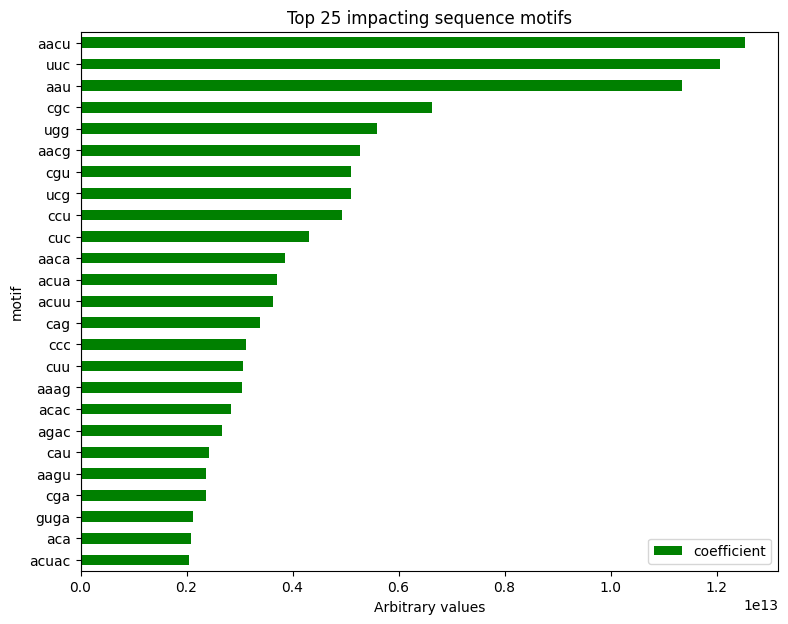

In [127]:
coefs[-25:].plot.barh(figsize=(9, 7), color='green')
plt.title("Top 25 impacting sequence motifs")
plt.axvline(x=0, color=".5")
plt.xlabel("Arbitrary values")
#plt.subplots_adjust(left=0.3)

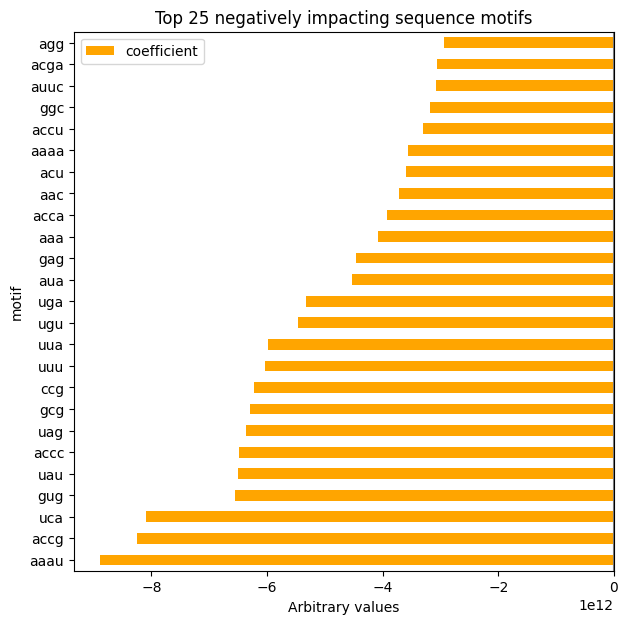

In [104]:
coefs[:25].plot.barh(figsize=(9, 7), color='orange')
plt.title("Top 25 negatively impacting sequence motifs")
plt.axvline(x=0, color=".5")
plt.xlabel("Arbitrary values")
plt.subplots_adjust(left=0.3)

In [77]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

array([-4.07243326e+12, -3.71402791e+12, -2.03884254e+12, ...,
       -1.08849582e+11,  2.21245452e+10,  3.44819815e+11])

In [ ]:
aaa

In [ ]:
#X = pd.concat([thermo_feats.drop('fluo', axis=1), seq_feats], axis=1)
#X = seq_feats.copy()

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2)

estimator = HistGradientBoostingRegressor()
#estimator = XGBRegressor()
#estimator = RandomForestRegressor()
#estimator = LGBMRegressor()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(r2_score(y_test, y_pred))
plt.figure(figsize=[3, 3])
sns.regplot(y_test, y_pred)
plt.title('R2={}'.format(np.round(r2_score(y_test, y_pred), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [ ]:
kf = KFold(n_splits=6, shuffle=True)
r2_scores = []
y_tests = []
y_preds = []
X = thermo_feats.copy()
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    
    X_train = X.loc[train_index].drop('fluo', axis=1).values
    X_test = X.loc[test_index].drop('fluo', axis=1).values
    y_train = X.loc[train_index]['fluo'].values
    y_test = X.loc[test_index]['fluo'].values
    
    estimator = HistGradientBoostingRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    y_tests.extend(y_test.tolist())
    y_preds.extend(y_pred.tolist())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

regressors = [
    #KNeighborsRegressor(3),
    #SVR(kernel="rbf", C=0.025),
    #NuSVC(probability=True),
    #DecisionTreeRegressor(),
    RandomForestRegressor(),
    #AdaBoostRegressor(),
    GradientBoostingRegressor(),
    MLPRegressor()
    ]
for regressor in regressors:
    
    pipe = Pipeline(steps=[#('preprocessor', preprocessor),
                      ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)
    print("model score: %.3f" % pipe.score(X_test, y_test))

In [ ]:
np.mean(r2_scores), np.std(r2_scores)

In [ ]:
kf = KFold(n_splits=6, shuffle=True)
r2_scores = []
y_tests = []
y_preds = []
X = thermo_feats.copy()
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    
    X_train = X.loc[train_index].drop('fluo', axis=1).values
    X_test = X.loc[test_index].drop('fluo', axis=1).values
    y_train = X.loc[train_index]['fluo'].values
    y_test = X.loc[test_index]['fluo'].values
    
    estimator = MLPRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    y_tests.extend(y_test.tolist())
    y_preds.extend(y_pred.tolist())
    
np.mean(r2_scores), np.std(r2_scores)

Sequence motifs.

In [ ]:
seq_feats = generate_seq_features(data, kmers=[3, 4, 5, 6])
seq_feats.shape

In [ ]:
kf = KFold(n_splits=6, shuffle=True)
r2_scores = []
y_tests = []
y_preds = []
X = pd.concat([seq_feats, thermo_feats], axis=1)
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    
    X_train = X.loc[train_index].drop('fluo', axis=1).values
    X_test = X.loc[test_index].drop('fluo', axis=1).values
    y_train = X.loc[train_index]['fluo'].values
    y_test = X.loc[test_index]['fluo'].values
    
    estimator = HistGradientBoostingRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    y_tests.extend(y_test.tolist())
    y_preds.extend(y_pred.tolist())
    
np.mean(r2_scores), np.std(r2_scores)

In [ ]:
estimator = HistGradientBoostingRegressor()
prediction = cross_val_predict(estimator, X.drop('fluo', axis=1), X['fluo'], cv=5)
r = r2_score(y, prediction)
sns.regplot(y, prediction, label='r2:{}'.format(np.round(r, 2)))
plt.legend()
sns.despine()

In [ ]:
4**20

In [ ]:
data['len3'].unique()

In [ ]:
#double check if there is any non-numeric features
set([thermo_feats[col].dtype for col in thermo_feats.columns])

In [ ]:
seq_feats = generate_seq_features(data, [3, 6, 9])

In [ ]:
X = pd.concat([thermo_feats.drop('fluo', axis=1), seq_feats], axis=1)
#X = seq_feats.copy()
#X = thermo_feats.drop('fluo', axis=1)
y = thermo_feats['fluo']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2)

In [ ]:
#estimator = HistGradientBoostingRegressor()
#estimator = XGBRegressor()
estimator = RandomForestRegressor()
#estimator = LGBMRegressor()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
plt.figure(figsize=[3, 3])
sns.regplot(y_test, y_pred)
plt.title('Random Forest, R2={}'.format(np.round(r2_score(y_test, y_pred), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [129]:
#X = pd.concat([thermo_feats.drop('fluo', axis=1), seq_feats], axis=1)
#X = seq_feats.copy()
X = thermo_feats.drop('fluo', axis=1)
y = thermo_feats['fluo']

In [130]:
estimator = RandomForestRegressor()
estimator.fit(X, y)
importances = estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)

In [131]:
importances

array([0.        , 0.        , 0.02306942, ..., 0.00063402, 0.        ,
       0.00042322])

In [135]:
pd.DataFrame([(a, b) for a, b in zip(X.columns, importances)])

,0,1
0,len5,0.00
1,len3,0.00
2,pfunc-0_0,0.02
3,pfunc-1_0,0.03
4,pfunc-0_1,0.01
...,...,...
6474,mfe_structure_0_right_bracket,0.00
6475,mfe_structure_1_dot,0.00
6476,mfe_structure_1_left_bracket,0.00
6477,mfe_structure_1_plus,0.00


In [140]:
rf_coefs2 = pd.DataFrame([(a, b) for a, b in zip(X.columns, importances)], columns=['motif', 'coefficient'])
rf_coefs2 = rf_coefs2.sort_values('coefficient', ascending=False)
rf_coefs2 = rf_coefs2.set_index('motif')
rf_coefs2

,coefficient
motif,
C3,0.22
pfunc-1_0,0.03
weight5,0.02
pfunc-0_0,0.02
ensemble_0,0.02
...,...
mme_0_1623,0.00
mme_0_1621,0.00
mme_1_1260,0.00


In [143]:
rf_coefs2.to_csv('{}/model/thermodynamics-rf-feature-explainability.csv'.format(CONFIG['path']))

Text(0.5, 0, 'Arbitrary values')

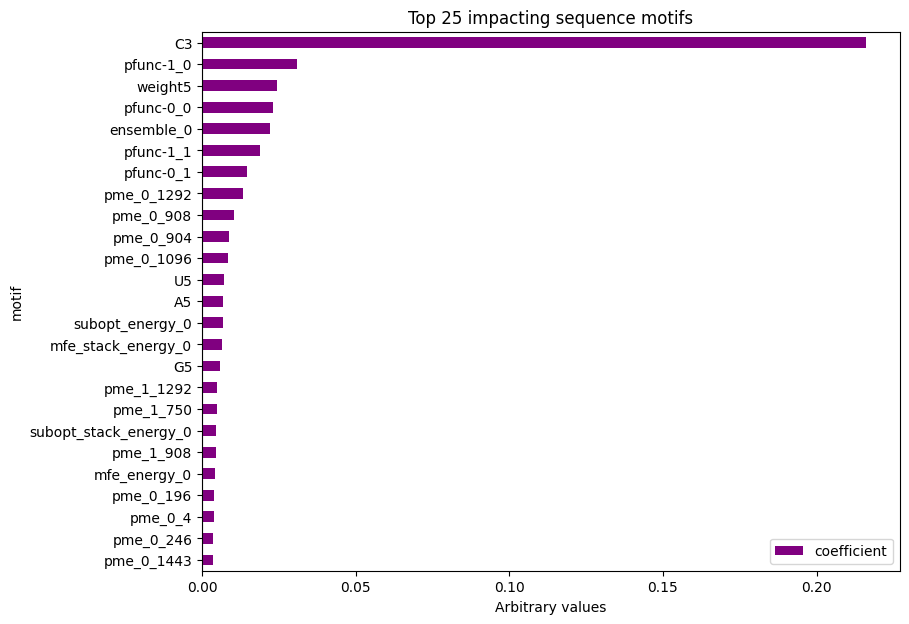

In [142]:
rf_coefs2[:25].sort_values('coefficient', ascending=True).plot.barh(figsize=(9, 7), color='purple')
plt.title("Top 25 impacting sequence motifs")
plt.axvline(x=0, color=".5")
plt.xlabel("Arbitrary values")

In [ ]:
X2 = X.copy()
X2.columns = np.arange(X2.shape[1])
X_new = X2[pd.Series(importances).sort_values(ascending=False)[:25].index.tolist()]
X_train, X_test, y_train, y_test = train_test_split(X_new.values, y, test_size=0.2)

In [ ]:
X2

In [ ]:
[X.columns[i] for i in X_new.columns]

In [ ]:
estimator = RandomForestRegressor()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
plt.figure(figsize=[3, 3])
sns.regplot(y_test, y_pred)
plt.title('Random Forest, R2={}'.format(np.round(r2_score(y_test, y_pred), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

#### Train-test split manually

In [ ]:
#estimator = HistGradientBoostingRegressor()
estimator = LinearRegression()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
r2_score(y_test, y_pred)

In [ ]:
plt.figure(figsize=[3, 3])
sns.regplot(y_test, y_pred)
plt.title('Split later, R2={}'.format(np.round(r2_score(y_test, y_pred), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

#### Cross-validation within training datasets

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
r2_scores = []
y_tests = []
y_preds = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    #print(train_index, test_index)
    X_train = X_cv.loc[train_index].drop('target', axis=1).values
    X_test = X_cv.loc[test_index].drop('target', axis=1).values
    y_train = X_cv.loc[train_index]['target'].values
    y_test = X_cv.loc[test_index]['target'].values
    
    estimator = MLPRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    y_tests.extend(y_test.tolist())
    y_preds.extend(y_pred.tolist())

In [ ]:
np.std(r2_scores)

In [ ]:
plt.figure(figsize=[3, 3])
sns.regplot(y_tests, y_preds)
plt.title('Neural Network, R2={}'.format(np.round(r2_score(y_tests, y_preds), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
rf_r2_scores = []
rf_y_tests = []
rf_y_preds = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    #print(train_index, test_index)
    X_train = X_cv.loc[train_index].drop('target', axis=1).values
    X_test = X_cv.loc[test_index].drop('target', axis=1).values
    y_train = X_cv.loc[train_index]['target'].values
    y_test = X_cv.loc[test_index]['target'].values
    
    estimator = RandomForestRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    rf_r2_scores.append(r2_score(y_test, y_pred))
    rf_y_tests.extend(y_test.tolist())
    rf_y_preds.extend(y_pred.tolist())

In [ ]:
np.std(rf_r2_scores)

In [ ]:
plt.figure(figsize=[3, 3])
sns.regplot(rf_y_tests, rf_y_preds)
plt.title('Random Forest, R2={}'.format(np.round(r2_score(rf_y_tests, rf_y_preds), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
gb_r2_scores = []
gb_y_tests = []
gb_y_preds = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    #print(train_index, test_index)
    X_train = X_cv.loc[train_index].drop('target', axis=1).values
    X_test = X_cv.loc[test_index].drop('target', axis=1).values
    y_train = X_cv.loc[train_index]['target'].values
    y_test = X_cv.loc[test_index]['target'].values
    
    estimator = GradientBoostingRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    gb_r2_scores.append(r2_score(y_test, y_pred))
    gb_y_tests.extend(y_test.tolist())
    gb_y_preds.extend(y_pred.tolist())

In [ ]:
np.std(gb_r2_scores)

In [ ]:
plt.figure(figsize=[3, 3])
sns.regplot(gb_y_tests, gb_y_preds)
plt.title('Gradient Boosting, R2={}'.format(np.round(r2_score(gb_y_tests, gb_y_preds), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
gp_r2_scores = []
gp_y_tests = []
gp_y_preds = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    #print(train_index, test_index)
    X_train = X_cv.loc[train_index].drop('target', axis=1).values
    X_test = X_cv.loc[test_index].drop('target', axis=1).values
    y_train = X_cv.loc[train_index]['target'].values
    y_test = X_cv.loc[test_index]['target'].values
    
    estimator = gp.GaussianProcessRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    gp_r2_scores.append(r2_score(y_test, y_pred))
    gp_y_tests.extend(y_test.tolist())
    gp_y_preds.extend(y_pred.tolist())

In [ ]:
np.std(gp_r2_scores)

In [ ]:
f, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(12, 3))
axr = axs.ravel()

sns.regplot(y_tests, y_preds, ax=axr[0])
axr[0].set_title('Neural Network, R2={}'.format(np.round(r2_score(y_tests, y_preds), 2)))
axr[0].set_xlabel('Experiment(log RPU)')
axr[0].set_ylabel('Prediction(log RPU)')
sns.despine()

sns.regplot(rf_y_tests, rf_y_preds, ax=axr[1])
axr[1].set_title('Random Forest, R2={}'.format(np.round(r2_score(rf_y_tests, rf_y_preds), 2)))
axr[1].set_xlabel('Experiment(log RPU)')
axr[1].set_ylabel('Prediction(log RPU)')
sns.despine()

sns.regplot(gb_y_tests, gb_y_preds, ax=axr[2])
axr[2].set_title('Gradient Boosting, R2={}'.format(np.round(r2_score(gb_y_tests, gb_y_preds), 2)))
axr[2].set_xlabel('Experiment(log RPU)')
axr[2].set_ylabel('Prediction(log RPU)')
sns.despine()

In [ ]:
nn = pd.DataFrame([y_tests, y_preds]).T
rf = pd.DataFrame([rf_y_tests, rf_y_preds]).T
gb = pd.DataFrame([gb_y_tests, gb_y_preds]).T
df = pd.concat([nn, rf, gb], axis=1)
df.columns = ['neural-network-exp', 'neural-network-pred', 'random-forest-exp', 'random-forest-pred', 'gradient-boosting-exp', 'gradient-boosting-pred']

In [ ]:
(10**df).to_csv('datasets/trans-splicing-prediction-linearscale.csv', index=False)

In [ ]:
sns.regplot(10**df['neural-network-exp'], 10**df['neural-network-pred'])
r2_score(10**df['neural-network-exp'], 10**df['neural-network-pred'])
plt.loglog()

In [ ]:
plt.figure(figsize=[3, 3])
sns.regplot(gp_y_tests, gp_y_preds)
plt.title('Gaussian Process, R2={}'.format(np.round(r2_score(gp_y_tests, gp_y_preds), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR#, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

regressors = [
    #KNeighborsRegressor(3),
    #SVR(kernel="rbf", C=0.025),
    #NuSVC(probability=True),
    #DecisionTreeRegressor(),
    RandomForestRegressor(),
    #AdaBoostRegressor(),
    GradientBoostingRegressor(),
    MLPRegressor()
    ]
for regressor in regressors:
    
    pipe = Pipeline(steps=[#('preprocessor', preprocessor),
                      ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)
    print("model score: %.3f" % pipe.score(X_test, y_test))